In [1]:
from os import listdir
from os.path import join, isfile
import numpy as np #1.16.4 otherwise futurewarning tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
import cv2
from sklearn.metrics import roc_auc_score, confusion_matrix

In [2]:
NUM_CLASSES = 2
BATCH_SIZE = 8
NUM_POINTS = 510

# Data

In [3]:
def load_data(syn):
    
    # files with representations
    GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien" 
    syn_csv = GENERAL_DIR+ "\\features_facereader_landmarks_patient_groups.csv"
    ID_csv = GENERAL_DIR+ "\\features_facereader_landmarks_all_controls.csv"
    
    # open directories
    syn_dir = GENERAL_DIR+"\\{}\\{}-patients".format(syn, syn)
    ID_dir = GENERAL_DIR+ "\\{}\\{}-selected-ID-controls".format(syn, syn)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]
    
    data, labels = [], []

    data_syn = []
    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_syn:                 
                fr_rep = [float(f) for f in row[1:]]
                rep = []
                i = 1
                while i < len(row[1:]):
                    rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    i+=3                       
                data_syn.append(rep)
                
                    
    data_ID = []                    
    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_ID:                 
                fr_rep = [float(f) for f in row[1:]]
                rep = []
                i = 1
                while i < len(row[1:]):
                    rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    i+=3                       
                data_ID.append(rep)

    

    for index, (syn_item, ID_item) in enumerate(zip(data_syn, data_ID)):
        if len(syn_item) == 510 and len(ID_item) == 510:               
            data.append(syn_item)
            labels.append(1)
            data.append(ID_item)
            labels.append(0)

    return np.array(data), np.array(labels)


In [4]:
def augment(points, label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    points = tf.random.shuffle(points)
    return points, label

In [5]:
def  split_data(data, left, right):
    
    data_left, data_right  = [], []
    for index, row in enumerate(data):
        
        rep_left, rep_right = [], []
        
        for p, [x, y, z] in enumerate(row):
            
            if p in left:
                rep_left.append([x, y, z])

            elif p in right:
                rep_right.append([x, y, z])

            else:
                print("Error")
                
        data_left.append(rep_left)
        data_right.append(rep_right)
        
    return np.array(data_left), np.array(data_right)


# Model

In [6]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding='valid')(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [7]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
        
    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2,2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [8]:
def tnet(inputs, num_features):
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features, 
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg)(x)
    
    feat_T = layers.Reshape((num_features, num_features))(x)
    
    return layers.Dot(axes=(2,1))([inputs, feat_T])

In [9]:
# model

def generate_model():

    inputs = keras.Input(shape=(NUM_POINTS, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(rate=0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(rate=0.3)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    #model.summary()

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(lr=0.001),
        metrics=["sparse_categorical_accuracy"])
    
    return model

In [10]:
left = [0, 1, 2, 3, 4, 5, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341]
right = [9, 10, 11, 12, 13, 14, 15, 16, 17, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 157, 158, 168, 173, 174, 190, 191, 205, 210, 213, 217, 262, 263, 269, 278, 281, 282, 284, 288, 292, 294, 295, 296, 297, 298, 299, 302, 304, 305, 306, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509]

In [11]:
syn = 'ADNP'

data, labels = load_data(syn)

data_left, data_right = split_data(data, left, right)

<IPython.core.display.Javascript object>


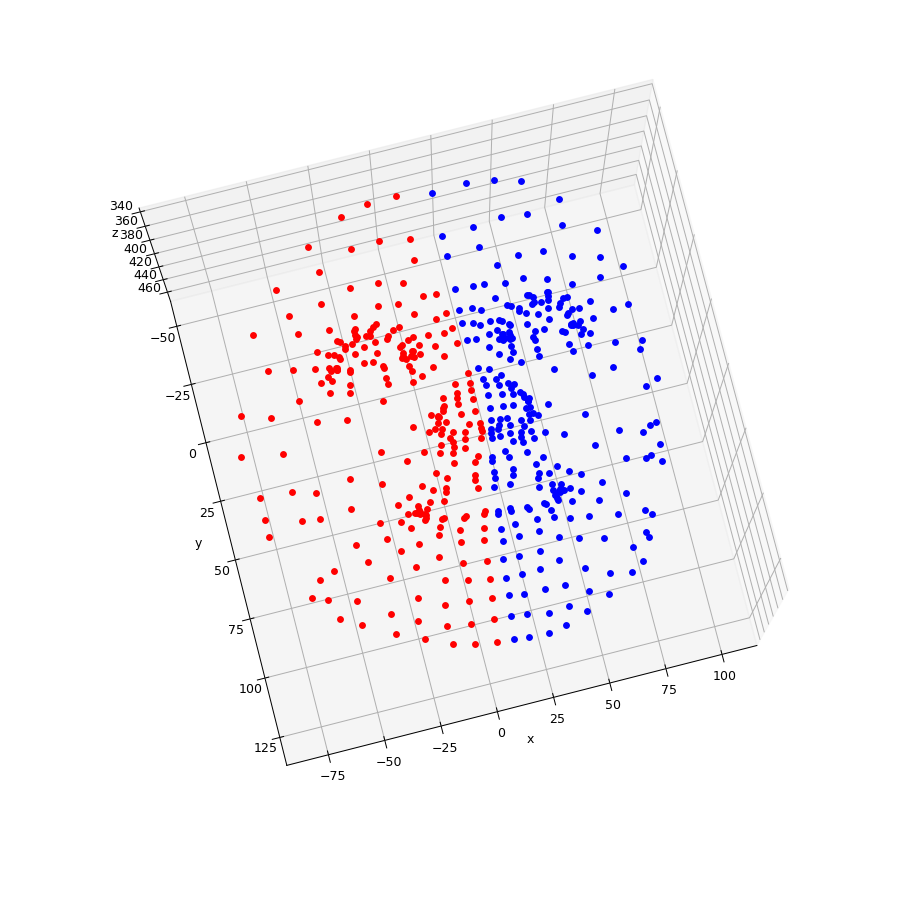

In [14]:
%matplotlib notebook
from matplotlib import pyplot
from pylab import figure
from mpl_toolkits.mplot3d import Axes3D


fig = figure(figsize=(10,10))
ax = Axes3D(fig)

for p in data_left[0]: 
    ax.scatter(p[0], p[1], p[2], color='b') 
    
for p in data_right[0]: 
    ax.scatter(p[0], p[1], p[2], color='r') 
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
pyplot.show()

# Training

In [9]:
run_nr = 1
side = ["LEFT", "RIGHT"]
syn_list = ['ADNP', 'ANKRD11', 'CDK13', 'DEAF1', 'DYRK1A', 'EHMT1', 'FBXO11', 'SON', 'WAC', 'YY1', 'KDVS']

results_file = open("results/pointnet_results_binary_run_split_faces{}.txt".format(run_nr), "w")

for syn in syn_list:
    data, labels = load_data(syn)
    
    data_left, data_right = split_data(data)
    
    for s, data in enumerate([data_left, data_right]):
        results_file.write("Syndrome {} with {} patients and {} controls - {}\n".format(syn, labels.tolist().count(1), labels.tolist().count(0), side[s]))
  
        all_y, all_probs, all_preds = [], [], [] 

        loo = LeaveOneOut()
        for train_index, test_index in tqdm(loo.split(data)):
            X_train, X_test = np.array(data[train_index]), data[test_index]
            y_train, y_test = np.array(labels[train_index]), labels[test_index]

            model = generate_model()
            model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=10, shuffle=True)

            y_pred_array = model.predict(X_test)
            y_pred = tf.math.argmax(y_pred_array, -1).numpy()

            all_y.append(y_test[0])
            all_probs.append(y_pred_array[0][1])
            all_preds.append(y_pred) 

        aroc = roc_auc_score(all_y, all_probs)
        tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
        spec = tn / (tn+fp)  
        sens = tp / (tp+fn)

        results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}\n\n".format(aroc, spec, sens))

    
results_file.close()

0it [00:00, ?it/s]

Epoch 1/10
3/3 [==============================] - 1s 207ms/step - loss: 1.2535 - sparse_categorical_accuracy: 0.6522
Epoch 2/10
3/3 [==============================] - 1s 205ms/step - loss: 0.9007 - sparse_categorical_accuracy: 0.8696
Epoch 3/10
3/3 [==============================] - 1s 205ms/step - loss: 1.0224 - sparse_categorical_accuracy: 0.9130
Epoch 4/10
3/3 [==============================] - 1s 206ms/step - loss: 0.9740 - sparse_categorical_accuracy: 0.9565
Epoch 5/10
3/3 [==============================] - 1s 205ms/step - loss: 1.1935 - sparse_categorical_accuracy: 0.7826
Epoch 6/10
3/3 [==============================] - 1s 206ms/step - loss: 0.9023 - sparse_categorical_accuracy: 0.9130
Epoch 7/10
3/3 [==============================] - 1s 205ms/step - loss: 1.0410 - sparse_categorical_accuracy: 0.8696
Epoch 8/10
3/3 [==============================] - 1s 210ms/step - loss: 0.7359 - sparse_categorical_accuracy: 0.9130
Epoch 9/10
3/3 [==============================] - 1s 206ms/step 

1it [00:14, 14.83s/it]

Epoch 1/10
3/3 [==============================] - 1s 209ms/step - loss: 1.2164 - sparse_categorical_accuracy: 0.6522
Epoch 2/10
3/3 [==============================] - 1s 203ms/step - loss: 1.0486 - sparse_categorical_accuracy: 0.7391
Epoch 3/10
3/3 [==============================] - 1s 205ms/step - loss: 0.9707 - sparse_categorical_accuracy: 0.9130
Epoch 4/10
3/3 [==============================] - 1s 205ms/step - loss: 0.9267 - sparse_categorical_accuracy: 0.9565
Epoch 5/10
3/3 [==============================] - 1s 206ms/step - loss: 0.8627 - sparse_categorical_accuracy: 0.9565
Epoch 6/10
3/3 [==============================] - 1s 204ms/step - loss: 0.8944 - sparse_categorical_accuracy: 0.8696
Epoch 7/10
3/3 [==============================] - 1s 205ms/step - loss: 0.9024 - sparse_categorical_accuracy: 0.9130
Epoch 8/10
3/3 [==============================] - 1s 206ms/step - loss: 0.8602 - sparse_categorical_accuracy: 0.9130
Epoch 9/10
3/3 [==============================] - 1s 203ms/step 

2it [00:29, 14.77s/it]

Epoch 1/10
3/3 [==============================] - 1s 208ms/step - loss: 1.1892 - sparse_categorical_accuracy: 0.6957
Epoch 2/10
3/3 [==============================] - 1s 205ms/step - loss: 1.2175 - sparse_categorical_accuracy: 0.6957
Epoch 3/10
3/3 [==============================] - 1s 203ms/step - loss: 0.8417 - sparse_categorical_accuracy: 0.9565
Epoch 4/10
3/3 [==============================] - 1s 204ms/step - loss: 0.9779 - sparse_categorical_accuracy: 0.9130
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 1.3483 - sparse_categorical_accuracy: 0.9130
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9350 - sparse_categorical_accuracy: 0.9130
Epoch 7/10
3/3 [==============================] - 1s 204ms/step - loss: 1.0771 - sparse_categorical_accuracy: 0.7826
Epoch 8/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9679 - sparse_categorical_accuracy: 0.9130
Epoch 9/10
3/3 [==============================] - 1s 205ms/step 

3it [00:44, 14.71s/it]

Epoch 1/10
3/3 [==============================] - 1s 211ms/step - loss: 1.0227 - sparse_categorical_accuracy: 0.6957
Epoch 2/10
3/3 [==============================] - 1s 204ms/step - loss: 0.7699 - sparse_categorical_accuracy: 0.9565
Epoch 3/10
3/3 [==============================] - 1s 205ms/step - loss: 0.7942 - sparse_categorical_accuracy: 0.9565
Epoch 4/10
3/3 [==============================] - 1s 205ms/step - loss: 0.7187 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 1s 207ms/step - loss: 1.0915 - sparse_categorical_accuracy: 0.8261
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1777 - sparse_categorical_accuracy: 0.8261
Epoch 7/10
3/3 [==============================] - 1s 205ms/step - loss: 0.9630 - sparse_categorical_accuracy: 0.8261
Epoch 8/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9637 - sparse_categorical_accuracy: 0.8696
Epoch 9/10
3/3 [==============================] - 1s 205ms/step 

4it [00:58, 14.70s/it]

Epoch 1/10
3/3 [==============================] - 1s 212ms/step - loss: 1.4461 - sparse_categorical_accuracy: 0.4348
Epoch 2/10
3/3 [==============================] - 1s 204ms/step - loss: 1.4951 - sparse_categorical_accuracy: 0.6522
Epoch 3/10
3/3 [==============================] - 1s 203ms/step - loss: 1.0481 - sparse_categorical_accuracy: 0.9565
Epoch 4/10
3/3 [==============================] - 1s 210ms/step - loss: 1.1065 - sparse_categorical_accuracy: 0.9130
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1283 - sparse_categorical_accuracy: 0.9565
Epoch 6/10
3/3 [==============================] - 1s 211ms/step - loss: 1.1554 - sparse_categorical_accuracy: 0.8696
Epoch 7/10
3/3 [==============================] - 1s 213ms/step - loss: 1.5216 - sparse_categorical_accuracy: 0.7391
Epoch 8/10
3/3 [==============================] - 1s 217ms/step - loss: 1.0295 - sparse_categorical_accuracy: 0.9565
Epoch 9/10
3/3 [==============================] - 1s 220ms/step 

5it [01:13, 14.72s/it]

Epoch 1/10
3/3 [==============================] - 1s 206ms/step - loss: 1.6237 - sparse_categorical_accuracy: 0.4783
Epoch 2/10
3/3 [==============================] - 1s 207ms/step - loss: 1.0643 - sparse_categorical_accuracy: 0.7391
Epoch 3/10
3/3 [==============================] - 1s 209ms/step - loss: 0.9355 - sparse_categorical_accuracy: 0.9130
Epoch 4/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9852 - sparse_categorical_accuracy: 0.9130
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 0.8697 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 0.8224 - sparse_categorical_accuracy: 0.9565
Epoch 7/10
3/3 [==============================] - 1s 203ms/step - loss: 0.8536 - sparse_categorical_accuracy: 0.9565
Epoch 8/10
3/3 [==============================] - 1s 204ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.9565
Epoch 9/10
3/3 [==============================] - 1s 199ms/step 

6it [01:27, 14.66s/it]

Epoch 1/10
3/3 [==============================] - 1s 208ms/step - loss: 1.0549 - sparse_categorical_accuracy: 0.6957
Epoch 2/10
3/3 [==============================] - 1s 202ms/step - loss: 0.9924 - sparse_categorical_accuracy: 0.7826
Epoch 3/10
3/3 [==============================] - 1s 213ms/step - loss: 0.8213 - sparse_categorical_accuracy: 0.9565
Epoch 4/10
3/3 [==============================] - 1s 204ms/step - loss: 1.1403 - sparse_categorical_accuracy: 0.8696
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9800 - sparse_categorical_accuracy: 0.9130
Epoch 6/10
3/3 [==============================] - 1s 204ms/step - loss: 0.9604 - sparse_categorical_accuracy: 0.8696
Epoch 7/10
3/3 [==============================] - 1s 199ms/step - loss: 0.6690 - sparse_categorical_accuracy: 0.9130
Epoch 8/10
3/3 [==============================] - 1s 200ms/step - loss: 0.6221 - sparse_categorical_accuracy: 0.9565
Epoch 9/10
3/3 [==============================] - 1s 203ms/step 

7it [01:42, 14.57s/it]

Epoch 1/10
3/3 [==============================] - 1s 235ms/step - loss: 1.2509 - sparse_categorical_accuracy: 0.5652
Epoch 2/10
3/3 [==============================] - 1s 214ms/step - loss: 1.4330 - sparse_categorical_accuracy: 0.5217
Epoch 3/10
3/3 [==============================] - 1s 214ms/step - loss: 1.4923 - sparse_categorical_accuracy: 0.6087
Epoch 4/10
3/3 [==============================] - 1s 214ms/step - loss: 1.2983 - sparse_categorical_accuracy: 0.7826
Epoch 5/10
3/3 [==============================] - 1s 219ms/step - loss: 1.2622 - sparse_categorical_accuracy: 0.7826
Epoch 6/10
3/3 [==============================] - 1s 215ms/step - loss: 1.3137 - sparse_categorical_accuracy: 0.8261
Epoch 7/10
3/3 [==============================] - 1s 214ms/step - loss: 0.9079 - sparse_categorical_accuracy: 0.9565
Epoch 8/10
3/3 [==============================] - 1s 219ms/step - loss: 0.9720 - sparse_categorical_accuracy: 0.8696
Epoch 9/10
3/3 [==============================] - 1s 219ms/step 

8it [01:58, 14.92s/it]

Epoch 1/10
3/3 [==============================] - 1s 204ms/step - loss: 0.9848 - sparse_categorical_accuracy: 0.8696
Epoch 2/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9703 - sparse_categorical_accuracy: 0.8696
Epoch 3/10
3/3 [==============================] - 1s 202ms/step - loss: 0.9117 - sparse_categorical_accuracy: 0.9565
Epoch 4/10
3/3 [==============================] - 1s 202ms/step - loss: 1.0535 - sparse_categorical_accuracy: 0.9565
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1975 - sparse_categorical_accuracy: 0.8261
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 0.7347 - sparse_categorical_accuracy: 0.9565
Epoch 7/10
3/3 [==============================] - 1s 202ms/step - loss: 0.7944 - sparse_categorical_accuracy: 0.9565
Epoch 8/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9458 - sparse_categorical_accuracy: 0.8696
Epoch 9/10
3/3 [==============================] - 1s 202ms/step 

9it [02:12, 14.80s/it]

Epoch 1/10
3/3 [==============================] - 1s 207ms/step - loss: 1.4913 - sparse_categorical_accuracy: 0.6522
Epoch 2/10
3/3 [==============================] - 1s 202ms/step - loss: 0.8251 - sparse_categorical_accuracy: 0.9130
Epoch 3/10
3/3 [==============================] - 1s 202ms/step - loss: 1.0050 - sparse_categorical_accuracy: 0.7826
Epoch 4/10
3/3 [==============================] - 1s 202ms/step - loss: 1.1760 - sparse_categorical_accuracy: 0.9130
Epoch 5/10
3/3 [==============================] - 1s 197ms/step - loss: 0.8965 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 1s 208ms/step - loss: 0.7888 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 208ms/step - loss: 0.9459 - sparse_categorical_accuracy: 0.8696
Epoch 8/10
3/3 [==============================] - 1s 203ms/step - loss: 0.6857 - sparse_categorical_accuracy: 0.9565
Epoch 9/10
3/3 [==============================] - 1s 205ms/step 

10it [02:26, 14.63s/it]

Epoch 1/10
3/3 [==============================] - 1s 209ms/step - loss: 1.7330 - sparse_categorical_accuracy: 0.4348
Epoch 2/10
3/3 [==============================] - 1s 201ms/step - loss: 1.0646 - sparse_categorical_accuracy: 0.8261
Epoch 3/10
3/3 [==============================] - 1s 203ms/step - loss: 1.0825 - sparse_categorical_accuracy: 0.9565
Epoch 4/10
3/3 [==============================] - 1s 207ms/step - loss: 1.1196 - sparse_categorical_accuracy: 0.9130
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 1.4002 - sparse_categorical_accuracy: 0.7391
Epoch 6/10
3/3 [==============================] - 1s 219ms/step - loss: 0.7563 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 225ms/step - loss: 1.0668 - sparse_categorical_accuracy: 0.8261
Epoch 8/10
3/3 [==============================] - 1s 220ms/step - loss: 0.6244 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 1s 219ms/step 

11it [02:41, 14.66s/it]

Epoch 1/10
3/3 [==============================] - 1s 209ms/step - loss: 2.0784 - sparse_categorical_accuracy: 0.3913
Epoch 2/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1299 - sparse_categorical_accuracy: 0.7826
Epoch 3/10
3/3 [==============================] - 1s 224ms/step - loss: 0.9990 - sparse_categorical_accuracy: 0.9130
Epoch 4/10
3/3 [==============================] - 1s 231ms/step - loss: 1.2469 - sparse_categorical_accuracy: 0.8696
Epoch 5/10
3/3 [==============================] - 1s 214ms/step - loss: 1.0010 - sparse_categorical_accuracy: 0.9565
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9484 - sparse_categorical_accuracy: 0.9130
Epoch 7/10
3/3 [==============================] - 1s 208ms/step - loss: 1.1818 - sparse_categorical_accuracy: 0.7826
Epoch 8/10
3/3 [==============================] - 1s 207ms/step - loss: 0.8402 - sparse_categorical_accuracy: 0.9130
Epoch 9/10
3/3 [==============================] - 1s 207ms/step 

12it [02:56, 14.75s/it]

Epoch 1/10
3/3 [==============================] - 1s 214ms/step - loss: 1.5857 - sparse_categorical_accuracy: 0.4348
Epoch 2/10
3/3 [==============================] - 1s 203ms/step - loss: 1.0934 - sparse_categorical_accuracy: 0.7826
Epoch 3/10
3/3 [==============================] - 1s 218ms/step - loss: 1.1345 - sparse_categorical_accuracy: 0.8261
Epoch 4/10
3/3 [==============================] - 1s 227ms/step - loss: 1.0632 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 1s 208ms/step - loss: 1.0695 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 1s 202ms/step - loss: 0.9758 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 203ms/step - loss: 0.8581 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
3/3 [==============================] - 1s 208ms/step - loss: 0.7480 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 1s 225ms/step 

13it [03:11, 14.75s/it]

Epoch 1/10
3/3 [==============================] - 1s 222ms/step - loss: 1.0120 - sparse_categorical_accuracy: 0.8261
Epoch 2/10
3/3 [==============================] - 1s 208ms/step - loss: 1.0425 - sparse_categorical_accuracy: 0.8261
Epoch 3/10
3/3 [==============================] - 1s 203ms/step - loss: 1.0550 - sparse_categorical_accuracy: 0.8261
Epoch 4/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9896 - sparse_categorical_accuracy: 0.8696
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 1.3189 - sparse_categorical_accuracy: 0.7391
Epoch 6/10
3/3 [==============================] - 1s 207ms/step - loss: 1.0929 - sparse_categorical_accuracy: 0.8261
Epoch 7/10
3/3 [==============================] - 1s 225ms/step - loss: 0.8546 - sparse_categorical_accuracy: 0.9130
Epoch 8/10
3/3 [==============================] - 1s 225ms/step - loss: 0.6396 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 1s 209ms/step 

14it [03:26, 14.77s/it]

Epoch 1/10
3/3 [==============================] - 1s 208ms/step - loss: 1.2268 - sparse_categorical_accuracy: 0.6522
Epoch 2/10
3/3 [==============================] - 1s 224ms/step - loss: 0.8815 - sparse_categorical_accuracy: 0.8696
Epoch 3/10
3/3 [==============================] - 1s 207ms/step - loss: 0.8594 - sparse_categorical_accuracy: 0.9565
Epoch 4/10
3/3 [==============================] - 1s 200ms/step - loss: 1.1924 - sparse_categorical_accuracy: 0.8261
Epoch 5/10
3/3 [==============================] - 1s 202ms/step - loss: 0.8484 - sparse_categorical_accuracy: 0.9565
Epoch 6/10
3/3 [==============================] - 1s 208ms/step - loss: 0.8741 - sparse_categorical_accuracy: 0.9565
Epoch 7/10
3/3 [==============================] - 1s 203ms/step - loss: 0.6718 - sparse_categorical_accuracy: 0.9565
Epoch 8/10
3/3 [==============================] - 1s 220ms/step - loss: 0.6007 - sparse_categorical_accuracy: 0.9565
Epoch 9/10
3/3 [==============================] - 1s 236ms/step 

15it [03:41, 14.85s/it]

Epoch 1/10
3/3 [==============================] - 1s 205ms/step - loss: 1.8453 - sparse_categorical_accuracy: 0.4348
Epoch 2/10
3/3 [==============================] - 1s 203ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.6957
Epoch 3/10
3/3 [==============================] - 1s 208ms/step - loss: 1.3204 - sparse_categorical_accuracy: 0.7391
Epoch 4/10
3/3 [==============================] - 1s 203ms/step - loss: 1.3954 - sparse_categorical_accuracy: 0.7391
Epoch 5/10
3/3 [==============================] - 1s 218ms/step - loss: 1.3333 - sparse_categorical_accuracy: 0.8696
Epoch 6/10
3/3 [==============================] - 1s 209ms/step - loss: 1.1974 - sparse_categorical_accuracy: 0.8696
Epoch 7/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1529 - sparse_categorical_accuracy: 0.9130
Epoch 8/10
3/3 [==============================] - 1s 207ms/step - loss: 0.8942 - sparse_categorical_accuracy: 0.9565
Epoch 9/10
3/3 [==============================] - 1s 201ms/step 

16it [03:55, 14.69s/it]

Epoch 1/10
3/3 [==============================] - 1s 212ms/step - loss: 1.3177 - sparse_categorical_accuracy: 0.5652
Epoch 2/10
3/3 [==============================] - 1s 207ms/step - loss: 1.3081 - sparse_categorical_accuracy: 0.6522
Epoch 3/10
3/3 [==============================] - 1s 208ms/step - loss: 1.0708 - sparse_categorical_accuracy: 0.8696
Epoch 4/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1261 - sparse_categorical_accuracy: 0.7826
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1094 - sparse_categorical_accuracy: 0.8261
Epoch 6/10
3/3 [==============================] - 1s 208ms/step - loss: 0.7981 - sparse_categorical_accuracy: 0.8696
Epoch 7/10
3/3 [==============================] - 1s 203ms/step - loss: 0.6758 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
3/3 [==============================] - 1s 208ms/step - loss: 0.7190 - sparse_categorical_accuracy: 0.9565
Epoch 9/10
3/3 [==============================] - 1s 208ms/step 

17it [04:10, 14.66s/it]

Epoch 1/10
3/3 [==============================] - 1s 207ms/step - loss: 1.4303 - sparse_categorical_accuracy: 0.5652
Epoch 2/10
3/3 [==============================] - 1s 200ms/step - loss: 0.9963 - sparse_categorical_accuracy: 0.8261
Epoch 3/10
3/3 [==============================] - 1s 199ms/step - loss: 1.2714 - sparse_categorical_accuracy: 0.8261
Epoch 4/10
3/3 [==============================] - 1s 224ms/step - loss: 1.0368 - sparse_categorical_accuracy: 0.9130
Epoch 5/10
3/3 [==============================] - 1s 202ms/step - loss: 1.0172 - sparse_categorical_accuracy: 0.9565
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 1.5271 - sparse_categorical_accuracy: 0.6957
Epoch 7/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9081 - sparse_categorical_accuracy: 0.9130
Epoch 8/10
3/3 [==============================] - 1s 203ms/step - loss: 0.7150 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 1s 203ms/step 

18it [04:24, 14.55s/it]

Epoch 1/10
3/3 [==============================] - 1s 214ms/step - loss: 1.3283 - sparse_categorical_accuracy: 0.6087
Epoch 2/10
3/3 [==============================] - 1s 208ms/step - loss: 0.8943 - sparse_categorical_accuracy: 0.9565
Epoch 3/10
3/3 [==============================] - 1s 202ms/step - loss: 1.1406 - sparse_categorical_accuracy: 0.9130
Epoch 4/10
3/3 [==============================] - 1s 208ms/step - loss: 1.1114 - sparse_categorical_accuracy: 0.8696
Epoch 5/10
3/3 [==============================] - 1s 202ms/step - loss: 0.9867 - sparse_categorical_accuracy: 0.9565
Epoch 6/10
3/3 [==============================] - 1s 207ms/step - loss: 0.9988 - sparse_categorical_accuracy: 0.9130
Epoch 7/10
3/3 [==============================] - 1s 203ms/step - loss: 0.8281 - sparse_categorical_accuracy: 0.9130
Epoch 8/10
3/3 [==============================] - 1s 207ms/step - loss: 0.8290 - sparse_categorical_accuracy: 0.9130
Epoch 9/10
3/3 [==============================] - 1s 206ms/step 

19it [04:38, 14.57s/it]

Epoch 1/10
3/3 [==============================] - 1s 210ms/step - loss: 1.1734 - sparse_categorical_accuracy: 0.5652
Epoch 2/10
3/3 [==============================] - 1s 206ms/step - loss: 0.9181 - sparse_categorical_accuracy: 0.8696
Epoch 3/10
3/3 [==============================] - 1s 204ms/step - loss: 0.8782 - sparse_categorical_accuracy: 0.8696
Epoch 4/10
3/3 [==============================] - 1s 202ms/step - loss: 1.0561 - sparse_categorical_accuracy: 0.9130
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 0.9406 - sparse_categorical_accuracy: 0.9130
Epoch 6/10
3/3 [==============================] - 1s 207ms/step - loss: 1.4569 - sparse_categorical_accuracy: 0.7391
Epoch 7/10
3/3 [==============================] - 1s 203ms/step - loss: 1.2252 - sparse_categorical_accuracy: 0.6522
Epoch 8/10
3/3 [==============================] - 1s 214ms/step - loss: 0.9689 - sparse_categorical_accuracy: 0.9130
Epoch 9/10
3/3 [==============================] - 1s 214ms/step 

20it [04:53, 14.49s/it]

Epoch 1/10
3/3 [==============================] - 1s 204ms/step - loss: 1.4616 - sparse_categorical_accuracy: 0.6087
Epoch 2/10
3/3 [==============================] - 1s 203ms/step - loss: 1.2443 - sparse_categorical_accuracy: 0.6522
Epoch 3/10
3/3 [==============================] - 1s 202ms/step - loss: 1.0690 - sparse_categorical_accuracy: 0.8261
Epoch 4/10
3/3 [==============================] - 1s 207ms/step - loss: 0.8981 - sparse_categorical_accuracy: 0.9565
Epoch 5/10
3/3 [==============================] - 1s 208ms/step - loss: 1.2504 - sparse_categorical_accuracy: 0.8261
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 0.7710 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 206ms/step - loss: 0.9045 - sparse_categorical_accuracy: 0.8261
Epoch 8/10
3/3 [==============================] - 1s 201ms/step - loss: 1.0350 - sparse_categorical_accuracy: 0.6957
Epoch 9/10
3/3 [==============================] - 1s 203ms/step 

21it [05:07, 14.51s/it]

Epoch 1/10
3/3 [==============================] - 1s 205ms/step - loss: 1.3391 - sparse_categorical_accuracy: 0.6087
Epoch 2/10
3/3 [==============================] - 1s 203ms/step - loss: 1.0651 - sparse_categorical_accuracy: 0.8261
Epoch 3/10
3/3 [==============================] - 1s 203ms/step - loss: 1.3940 - sparse_categorical_accuracy: 0.6957
Epoch 4/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1629 - sparse_categorical_accuracy: 0.9130
Epoch 5/10
3/3 [==============================] - 1s 208ms/step - loss: 0.9240 - sparse_categorical_accuracy: 0.9565
Epoch 6/10
3/3 [==============================] - 1s 202ms/step - loss: 0.9002 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 218ms/step - loss: 0.8392 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
3/3 [==============================] - 1s 208ms/step - loss: 0.7242 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 1s 203ms/step 

22it [05:22, 14.45s/it]

Epoch 1/10
3/3 [==============================] - 1s 218ms/step - loss: 1.2892 - sparse_categorical_accuracy: 0.7826
Epoch 2/10
3/3 [==============================] - 1s 202ms/step - loss: 0.8782 - sparse_categorical_accuracy: 0.8261
Epoch 3/10
3/3 [==============================] - 1s 208ms/step - loss: 0.8839 - sparse_categorical_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1925 - sparse_categorical_accuracy: 0.8696
Epoch 5/10
3/3 [==============================] - 1s 203ms/step - loss: 1.4228 - sparse_categorical_accuracy: 0.8261
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 1.0740 - sparse_categorical_accuracy: 0.9130
Epoch 7/10
3/3 [==============================] - 1s 208ms/step - loss: 1.1193 - sparse_categorical_accuracy: 0.7826
Epoch 8/10
3/3 [==============================] - 1s 203ms/step - loss: 0.8185 - sparse_categorical_accuracy: 0.9130
Epoch 9/10
3/3 [==============================] - 1s 208ms/step 

23it [05:36, 14.54s/it]

Epoch 1/10
3/3 [==============================] - 1s 218ms/step - loss: 1.3855 - sparse_categorical_accuracy: 0.5217
Epoch 2/10
3/3 [==============================] - 1s 205ms/step - loss: 1.0281 - sparse_categorical_accuracy: 0.8261
Epoch 3/10
3/3 [==============================] - 1s 203ms/step - loss: 0.8587 - sparse_categorical_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 1s 206ms/step - loss: 0.9537 - sparse_categorical_accuracy: 0.9130
Epoch 5/10
3/3 [==============================] - 1s 208ms/step - loss: 0.8258 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 1.1381 - sparse_categorical_accuracy: 0.8696
Epoch 7/10
3/3 [==============================] - 1s 203ms/step - loss: 0.7871 - sparse_categorical_accuracy: 0.9130
Epoch 8/10
3/3 [==============================] - 1s 203ms/step - loss: 0.8158 - sparse_categorical_accuracy: 0.9130
Epoch 9/10
3/3 [==============================] - 1s 208ms/step 

24it [05:51, 14.63s/it]
0it [00:00, ?it/s]

Epoch 1/10
5/5 [==============================] - 1s 245ms/step - loss: 1.1207 - sparse_categorical_accuracy: 0.7297
Epoch 2/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1306 - sparse_categorical_accuracy: 0.7568
Epoch 3/10
5/5 [==============================] - 1s 237ms/step - loss: 0.8647 - sparse_categorical_accuracy: 0.9459
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8162 - sparse_categorical_accuracy: 0.9189
Epoch 5/10
5/5 [==============================] - 1s 237ms/step - loss: 0.8185 - sparse_categorical_accuracy: 0.9189
Epoch 6/10
5/5 [==============================] - 1s 237ms/step - loss: 0.9907 - sparse_categorical_accuracy: 0.8649
Epoch 7/10
5/5 [==============================] - 1s 239ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 237ms/step - loss: 0.5245 - sparse_categorical_accuracy: 0.9459
Epoch 9/10
5/5 [==============================] - 1s 236ms/step 

1it [00:20, 20.41s/it]

Epoch 1/10
5/5 [==============================] - 1s 241ms/step - loss: 0.8644 - sparse_categorical_accuracy: 0.8919
Epoch 2/10
5/5 [==============================] - 1s 247ms/step - loss: 0.9820 - sparse_categorical_accuracy: 0.8919
Epoch 3/10
5/5 [==============================] - 1s 239ms/step - loss: 0.9805 - sparse_categorical_accuracy: 0.8649
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8017 - sparse_categorical_accuracy: 0.9459
Epoch 5/10
5/5 [==============================] - 1s 239ms/step - loss: 0.7212 - sparse_categorical_accuracy: 0.9189
Epoch 6/10
5/5 [==============================] - 1s 236ms/step - loss: 0.8413 - sparse_categorical_accuracy: 0.8649
Epoch 7/10
5/5 [==============================] - 1s 237ms/step - loss: 0.7068 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 239ms/step - loss: 0.6620 - sparse_categorical_accuracy: 0.9459
Epoch 9/10
5/5 [==============================] - 1s 234ms/step 

2it [00:40, 20.32s/it]

Epoch 1/10
5/5 [==============================] - 1s 239ms/step - loss: 0.9577 - sparse_categorical_accuracy: 0.8378
Epoch 2/10
5/5 [==============================] - 1s 239ms/step - loss: 1.1101 - sparse_categorical_accuracy: 0.8108
Epoch 3/10
5/5 [==============================] - 1s 237ms/step - loss: 0.9647 - sparse_categorical_accuracy: 0.8649
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0380 - sparse_categorical_accuracy: 0.8108
Epoch 5/10
5/5 [==============================] - 1s 238ms/step - loss: 0.6744 - sparse_categorical_accuracy: 0.9459
Epoch 6/10
5/5 [==============================] - 1s 235ms/step - loss: 0.6206 - sparse_categorical_accuracy: 0.9459
Epoch 7/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8353 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.5873 - sparse_categorical_accuracy: 0.9189
Epoch 9/10
5/5 [==============================] - 1s 237ms/step 

3it [01:00, 20.36s/it]

Epoch 1/10
5/5 [==============================] - 1s 236ms/step - loss: 1.0636 - sparse_categorical_accuracy: 0.7568
Epoch 2/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0024 - sparse_categorical_accuracy: 0.7838
Epoch 3/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9882 - sparse_categorical_accuracy: 0.8108
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7913 - sparse_categorical_accuracy: 0.8919
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9716 - sparse_categorical_accuracy: 0.8649
Epoch 6/10
5/5 [==============================] - 1s 233ms/step - loss: 1.0291 - sparse_categorical_accuracy: 0.8108
Epoch 7/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7601 - sparse_categorical_accuracy: 0.8649
Epoch 8/10
5/5 [==============================] - 1s 236ms/step - loss: 0.6710 - sparse_categorical_accuracy: 0.8649
Epoch 9/10
5/5 [==============================] - 1s 238ms/step 

4it [01:20, 20.26s/it]

Epoch 1/10
5/5 [==============================] - 1s 237ms/step - loss: 1.2942 - sparse_categorical_accuracy: 0.5946
Epoch 2/10
5/5 [==============================] - 1s 249ms/step - loss: 1.1657 - sparse_categorical_accuracy: 0.8378
Epoch 3/10
5/5 [==============================] - 1s 236ms/step - loss: 0.9358 - sparse_categorical_accuracy: 0.9730
Epoch 4/10
5/5 [==============================] - 1s 236ms/step - loss: 0.9480 - sparse_categorical_accuracy: 0.9189
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 1.1040 - sparse_categorical_accuracy: 0.8378
Epoch 6/10
5/5 [==============================] - 1s 235ms/step - loss: 0.6587 - sparse_categorical_accuracy: 0.9459
Epoch 7/10
5/5 [==============================] - 1s 234ms/step - loss: 0.8567 - sparse_categorical_accuracy: 0.8378
Epoch 8/10
5/5 [==============================] - 1s 238ms/step - loss: 0.7582 - sparse_categorical_accuracy: 0.8649
Epoch 9/10
5/5 [==============================] - 1s 237ms/step 

5it [01:41, 20.33s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1602 - sparse_categorical_accuracy: 0.5676
Epoch 2/10
5/5 [==============================] - 1s 232ms/step - loss: 1.3646 - sparse_categorical_accuracy: 0.8108
Epoch 3/10
5/5 [==============================] - 1s 234ms/step - loss: 1.4923 - sparse_categorical_accuracy: 0.6757
Epoch 4/10
5/5 [==============================] - 1s 239ms/step - loss: 1.1178 - sparse_categorical_accuracy: 0.8108
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8830 - sparse_categorical_accuracy: 0.8919
Epoch 6/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8068 - sparse_categorical_accuracy: 0.9459
Epoch 7/10
5/5 [==============================] - 1s 236ms/step - loss: 1.2085 - sparse_categorical_accuracy: 0.7838
Epoch 8/10
5/5 [==============================] - 1s 236ms/step - loss: 0.8884 - sparse_categorical_accuracy: 0.8919
Epoch 9/10
5/5 [==============================] - 1s 234ms/step 

6it [02:01, 20.25s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.2240 - sparse_categorical_accuracy: 0.6757
Epoch 2/10
5/5 [==============================] - 1s 234ms/step - loss: 1.1038 - sparse_categorical_accuracy: 0.8378
Epoch 3/10
5/5 [==============================] - 1s 235ms/step - loss: 1.1888 - sparse_categorical_accuracy: 0.8378
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 1.0540 - sparse_categorical_accuracy: 0.8919
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9668 - sparse_categorical_accuracy: 0.8378
Epoch 6/10
5/5 [==============================] - 1s 233ms/step - loss: 0.7083 - sparse_categorical_accuracy: 0.8919
Epoch 7/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8887 - sparse_categorical_accuracy: 0.8649
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.6332 - sparse_categorical_accuracy: 0.9459
Epoch 9/10
5/5 [==============================] - 1s 234ms/step 

7it [02:21, 20.16s/it]

Epoch 1/10
5/5 [==============================] - 1s 241ms/step - loss: 1.1612 - sparse_categorical_accuracy: 0.7297
Epoch 2/10
5/5 [==============================] - 1s 245ms/step - loss: 1.0350 - sparse_categorical_accuracy: 0.8649
Epoch 3/10
5/5 [==============================] - 1s 238ms/step - loss: 0.9341 - sparse_categorical_accuracy: 0.9459
Epoch 4/10
5/5 [==============================] - 1s 236ms/step - loss: 0.8279 - sparse_categorical_accuracy: 0.9189
Epoch 5/10
5/5 [==============================] - 1s 237ms/step - loss: 0.9225 - sparse_categorical_accuracy: 0.9189
Epoch 6/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9051 - sparse_categorical_accuracy: 0.8919
Epoch 7/10
5/5 [==============================] - 1s 238ms/step - loss: 0.6987 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 237ms/step - loss: 0.5064 - sparse_categorical_accuracy: 0.9730
Epoch 9/10
5/5 [==============================] - 1s 238ms/step 

8it [02:42, 20.28s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.3616 - sparse_categorical_accuracy: 0.5946
Epoch 2/10
5/5 [==============================] - 1s 239ms/step - loss: 1.0345 - sparse_categorical_accuracy: 0.8378
Epoch 3/10
5/5 [==============================] - 1s 235ms/step - loss: 1.0378 - sparse_categorical_accuracy: 0.9189
Epoch 4/10
5/5 [==============================] - 1s 234ms/step - loss: 0.8280 - sparse_categorical_accuracy: 0.9189
Epoch 5/10
5/5 [==============================] - 1s 236ms/step - loss: 0.9477 - sparse_categorical_accuracy: 0.8378
Epoch 6/10
5/5 [==============================] - 1s 234ms/step - loss: 0.6187 - sparse_categorical_accuracy: 0.9730
Epoch 7/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7368 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 236ms/step - loss: 0.9545 - sparse_categorical_accuracy: 0.8108
Epoch 9/10
5/5 [==============================] - 1s 235ms/step 

9it [03:02, 20.22s/it]

Epoch 1/10
5/5 [==============================] - 1s 236ms/step - loss: 0.9744 - sparse_categorical_accuracy: 0.7297
Epoch 2/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9433 - sparse_categorical_accuracy: 0.9459
Epoch 3/10
5/5 [==============================] - 1s 236ms/step - loss: 1.2577 - sparse_categorical_accuracy: 0.8108
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9711 - sparse_categorical_accuracy: 0.8649
Epoch 5/10
5/5 [==============================] - 1s 236ms/step - loss: 1.0725 - sparse_categorical_accuracy: 0.8108
Epoch 6/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8935 - sparse_categorical_accuracy: 0.8378
Epoch 7/10
5/5 [==============================] - 1s 235ms/step - loss: 0.6723 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 237ms/step - loss: 0.6799 - sparse_categorical_accuracy: 0.9189
Epoch 9/10
5/5 [==============================] - 1s 235ms/step 

10it [03:22, 20.17s/it]

Epoch 1/10
5/5 [==============================] - 1s 236ms/step - loss: 1.0965 - sparse_categorical_accuracy: 0.7027
Epoch 2/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9466 - sparse_categorical_accuracy: 0.8649
Epoch 3/10
5/5 [==============================] - 1s 242ms/step - loss: 1.0471 - sparse_categorical_accuracy: 0.9189
Epoch 4/10
5/5 [==============================] - 1s 234ms/step - loss: 0.8512 - sparse_categorical_accuracy: 0.9730
Epoch 5/10
5/5 [==============================] - 1s 238ms/step - loss: 0.9577 - sparse_categorical_accuracy: 0.9189
Epoch 6/10
5/5 [==============================] - 1s 248ms/step - loss: 1.0519 - sparse_categorical_accuracy: 0.8378
Epoch 7/10
5/5 [==============================] - 1s 240ms/step - loss: 0.6756 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.5707 - sparse_categorical_accuracy: 0.8919
Epoch 9/10
5/5 [==============================] - 1s 236ms/step 

11it [03:42, 20.33s/it]

Epoch 1/10
5/5 [==============================] - 1s 241ms/step - loss: 1.0511 - sparse_categorical_accuracy: 0.7027
Epoch 2/10
5/5 [==============================] - 1s 237ms/step - loss: 1.0131 - sparse_categorical_accuracy: 0.8919
Epoch 3/10
5/5 [==============================] - 1s 236ms/step - loss: 1.0057 - sparse_categorical_accuracy: 0.9189
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8094 - sparse_categorical_accuracy: 0.9730
Epoch 5/10
5/5 [==============================] - 1s 239ms/step - loss: 0.8519 - sparse_categorical_accuracy: 0.8378
Epoch 6/10
5/5 [==============================] - 1s 235ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.9459
Epoch 7/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7025 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 1.0142 - sparse_categorical_accuracy: 0.8108
Epoch 9/10
5/5 [==============================] - 1s 235ms/step 

12it [04:03, 20.28s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.2657 - sparse_categorical_accuracy: 0.6216
Epoch 2/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8507 - sparse_categorical_accuracy: 0.9730
Epoch 3/10
5/5 [==============================] - 1s 234ms/step - loss: 1.5515 - sparse_categorical_accuracy: 0.8108
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1700 - sparse_categorical_accuracy: 0.8378
Epoch 5/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8187 - sparse_categorical_accuracy: 0.9459
Epoch 6/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9205 - sparse_categorical_accuracy: 0.8649
Epoch 7/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8123 - sparse_categorical_accuracy: 0.8649
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8921 - sparse_categorical_accuracy: 0.8108
Epoch 9/10
5/5 [==============================] - 1s 239ms/step 

13it [04:23, 20.21s/it]

Epoch 1/10
5/5 [==============================] - 1s 241ms/step - loss: 1.2816 - sparse_categorical_accuracy: 0.6486
Epoch 2/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0208 - sparse_categorical_accuracy: 0.8378
Epoch 3/10
5/5 [==============================] - 1s 245ms/step - loss: 0.8917 - sparse_categorical_accuracy: 0.9730
Epoch 4/10
5/5 [==============================] - 1s 239ms/step - loss: 0.7887 - sparse_categorical_accuracy: 0.9730
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9464 - sparse_categorical_accuracy: 0.8919
Epoch 6/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8370 - sparse_categorical_accuracy: 0.9189
Epoch 7/10
5/5 [==============================] - 1s 239ms/step - loss: 0.5882 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 236ms/step - loss: 0.5586 - sparse_categorical_accuracy: 0.9459
Epoch 9/10
5/5 [==============================] - 1s 238ms/step 

14it [04:43, 20.31s/it]

Epoch 1/10
5/5 [==============================] - 1s 239ms/step - loss: 1.3746 - sparse_categorical_accuracy: 0.5405
Epoch 2/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9515 - sparse_categorical_accuracy: 0.8919
Epoch 3/10
5/5 [==============================] - 1s 235ms/step - loss: 1.1593 - sparse_categorical_accuracy: 0.8919
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8916 - sparse_categorical_accuracy: 0.9730
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7560 - sparse_categorical_accuracy: 0.9730
Epoch 6/10
5/5 [==============================] - 1s 236ms/step - loss: 0.7705 - sparse_categorical_accuracy: 0.9189
Epoch 7/10
5/5 [==============================] - 1s 239ms/step - loss: 0.8124 - sparse_categorical_accuracy: 0.8649
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.5247 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
5/5 [==============================] - 1s 235ms/step 

15it [05:03, 20.30s/it]

Epoch 1/10
5/5 [==============================] - 1s 233ms/step - loss: 1.0470 - sparse_categorical_accuracy: 0.7838
Epoch 2/10
5/5 [==============================] - 1s 235ms/step - loss: 1.2471 - sparse_categorical_accuracy: 0.8108
Epoch 3/10
5/5 [==============================] - 1s 232ms/step - loss: 0.9185 - sparse_categorical_accuracy: 0.9730
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1111 - sparse_categorical_accuracy: 0.8108
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9042 - sparse_categorical_accuracy: 0.8919
Epoch 6/10
5/5 [==============================] - 1s 234ms/step - loss: 0.9183 - sparse_categorical_accuracy: 0.8919
Epoch 7/10
5/5 [==============================] - 1s 234ms/step - loss: 0.9099 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 238ms/step - loss: 0.7279 - sparse_categorical_accuracy: 0.8108
Epoch 9/10
5/5 [==============================] - 1s 235ms/step 

16it [05:23, 20.22s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.3503 - sparse_categorical_accuracy: 0.5135
Epoch 2/10
5/5 [==============================] - 1s 242ms/step - loss: 1.2231 - sparse_categorical_accuracy: 0.7027
Epoch 3/10
5/5 [==============================] - 1s 243ms/step - loss: 1.0466 - sparse_categorical_accuracy: 0.8378
Epoch 4/10
5/5 [==============================] - 1s 237ms/step - loss: 0.9198 - sparse_categorical_accuracy: 0.9189
Epoch 5/10
5/5 [==============================] - 1s 237ms/step - loss: 0.9952 - sparse_categorical_accuracy: 0.8378
Epoch 6/10
5/5 [==============================] - 1s 240ms/step - loss: 0.8403 - sparse_categorical_accuracy: 0.8919
Epoch 7/10
5/5 [==============================] - 1s 237ms/step - loss: 0.7502 - sparse_categorical_accuracy: 0.8378
Epoch 8/10
5/5 [==============================] - 1s 237ms/step - loss: 0.7558 - sparse_categorical_accuracy: 0.8378
Epoch 9/10
5/5 [==============================] - 1s 240ms/step 

17it [05:44, 20.38s/it]

Epoch 1/10
5/5 [==============================] - 1s 242ms/step - loss: 0.9080 - sparse_categorical_accuracy: 0.8649
Epoch 2/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0085 - sparse_categorical_accuracy: 0.8649
Epoch 3/10
5/5 [==============================] - 1s 240ms/step - loss: 0.9853 - sparse_categorical_accuracy: 0.8919
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8739 - sparse_categorical_accuracy: 0.9189
Epoch 5/10
5/5 [==============================] - 1s 237ms/step - loss: 1.0363 - sparse_categorical_accuracy: 0.8108
Epoch 6/10
5/5 [==============================] - 1s 240ms/step - loss: 0.6205 - sparse_categorical_accuracy: 0.9189
Epoch 7/10
5/5 [==============================] - 1s 238ms/step - loss: 0.5541 - sparse_categorical_accuracy: 0.9459
Epoch 8/10
5/5 [==============================] - 1s 237ms/step - loss: 0.6045 - sparse_categorical_accuracy: 0.9459
Epoch 9/10
5/5 [==============================] - 1s 237ms/step 

18it [06:05, 20.38s/it]

Epoch 1/10
5/5 [==============================] - 1s 240ms/step - loss: 1.1968 - sparse_categorical_accuracy: 0.7568
Epoch 2/10
5/5 [==============================] - 1s 237ms/step - loss: 1.1490 - sparse_categorical_accuracy: 0.8108
Epoch 3/10
5/5 [==============================] - 1s 237ms/step - loss: 0.9299 - sparse_categorical_accuracy: 0.9730
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7582 - sparse_categorical_accuracy: 0.9730
Epoch 5/10
5/5 [==============================] - 1s 239ms/step - loss: 0.9136 - sparse_categorical_accuracy: 0.9189
Epoch 6/10
5/5 [==============================] - 1s 236ms/step - loss: 0.8957 - sparse_categorical_accuracy: 0.8649
Epoch 7/10
5/5 [==============================] - 1s 240ms/step - loss: 0.6832 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 239ms/step - loss: 0.7182 - sparse_categorical_accuracy: 0.9189
Epoch 9/10
5/5 [==============================] - 1s 238ms/step 

19it [06:25, 20.33s/it]

Epoch 1/10
5/5 [==============================] - 1s 242ms/step - loss: 1.1358 - sparse_categorical_accuracy: 0.5946
Epoch 2/10
5/5 [==============================] - 1s 255ms/step - loss: 1.0501 - sparse_categorical_accuracy: 0.8378
Epoch 3/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0938 - sparse_categorical_accuracy: 0.9189
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0932 - sparse_categorical_accuracy: 0.8649
Epoch 5/10
5/5 [==============================] - 1s 236ms/step - loss: 0.8544 - sparse_categorical_accuracy: 0.8919
Epoch 6/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0249 - sparse_categorical_accuracy: 0.8108 0s - loss: 1.0249 - sparse_categorical_accuracy: 0.810
Epoch 7/10
5/5 [==============================] - 1s 240ms/step - loss: 1.0073 - sparse_categorical_accuracy: 0.8378
Epoch 8/10
5/5 [==============================] - 1s 236ms/step - loss: 1.1825 - sparse_categorical_accuracy: 0.7838
Epoch 9/1

20it [06:46, 20.49s/it]

Epoch 1/10
5/5 [==============================] - 1s 241ms/step - loss: 1.2470 - sparse_categorical_accuracy: 0.7568
Epoch 2/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9592 - sparse_categorical_accuracy: 0.8919
Epoch 3/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8322 - sparse_categorical_accuracy: 0.9730
Epoch 4/10
5/5 [==============================] - 1s 240ms/step - loss: 1.1107 - sparse_categorical_accuracy: 0.8919
Epoch 5/10
5/5 [==============================] - 1s 237ms/step - loss: 1.1330 - sparse_categorical_accuracy: 0.7297
Epoch 6/10
5/5 [==============================] - 1s 239ms/step - loss: 0.7138 - sparse_categorical_accuracy: 0.9189
Epoch 7/10
5/5 [==============================] - 1s 237ms/step - loss: 1.0940 - sparse_categorical_accuracy: 0.7838
Epoch 8/10
5/5 [==============================] - 1s 237ms/step - loss: 0.6807 - sparse_categorical_accuracy: 0.9459
Epoch 9/10
5/5 [==============================] - 1s 245ms/step 

21it [07:06, 20.45s/it]

Epoch 1/10
5/5 [==============================] - 1s 235ms/step - loss: 1.3405 - sparse_categorical_accuracy: 0.5946
Epoch 2/10
5/5 [==============================] - 1s 237ms/step - loss: 0.9971 - sparse_categorical_accuracy: 0.9189
Epoch 3/10
5/5 [==============================] - 1s 237ms/step - loss: 1.0475 - sparse_categorical_accuracy: 0.8919
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 1.0176 - sparse_categorical_accuracy: 0.9459
Epoch 5/10
5/5 [==============================] - 1s 238ms/step - loss: 0.9281 - sparse_categorical_accuracy: 0.9189
Epoch 6/10
5/5 [==============================] - 1s 237ms/step - loss: 0.6427 - sparse_categorical_accuracy: 0.9730
Epoch 7/10
5/5 [==============================] - 1s 234ms/step - loss: 0.6424 - sparse_categorical_accuracy: 0.9459
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.6483 - sparse_categorical_accuracy: 0.8649
Epoch 9/10
5/5 [==============================] - 1s 239ms/step 

22it [07:26, 20.37s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1479 - sparse_categorical_accuracy: 0.7297
Epoch 2/10
5/5 [==============================] - 1s 251ms/step - loss: 1.0532 - sparse_categorical_accuracy: 0.8108
Epoch 3/10
5/5 [==============================] - 1s 233ms/step - loss: 0.9913 - sparse_categorical_accuracy: 0.8649
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 1.3401 - sparse_categorical_accuracy: 0.8378
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7734 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8573 - sparse_categorical_accuracy: 0.8108
Epoch 7/10
5/5 [==============================] - 1s 236ms/step - loss: 0.7198 - sparse_categorical_accuracy: 0.9459
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.5597 - sparse_categorical_accuracy: 0.9189
Epoch 9/10
5/5 [==============================] - 1s 238ms/step 

23it [07:46, 20.31s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0873 - sparse_categorical_accuracy: 0.7027
Epoch 2/10
5/5 [==============================] - 1s 235ms/step - loss: 1.0633 - sparse_categorical_accuracy: 0.8919
Epoch 3/10
5/5 [==============================] - 1s 235ms/step - loss: 1.0222 - sparse_categorical_accuracy: 0.9189
Epoch 4/10
5/5 [==============================] - 1s 236ms/step - loss: 0.9609 - sparse_categorical_accuracy: 0.9189
Epoch 5/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1162 - sparse_categorical_accuracy: 0.8108
Epoch 6/10
5/5 [==============================] - 1s 237ms/step - loss: 1.0377 - sparse_categorical_accuracy: 0.7568
Epoch 7/10
5/5 [==============================] - 1s 237ms/step - loss: 0.7328 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 238ms/step - loss: 0.6503 - sparse_categorical_accuracy: 0.9730
Epoch 9/10
5/5 [==============================] - 1s 238ms/step 

24it [08:07, 20.42s/it]

Epoch 1/10
5/5 [==============================] - 1s 242ms/step - loss: 1.0607 - sparse_categorical_accuracy: 0.7297
Epoch 2/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9527 - sparse_categorical_accuracy: 0.8649
Epoch 3/10
5/5 [==============================] - 1s 237ms/step - loss: 0.8287 - sparse_categorical_accuracy: 0.9189
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8105 - sparse_categorical_accuracy: 0.9730
Epoch 5/10
5/5 [==============================] - 1s 236ms/step - loss: 0.7114 - sparse_categorical_accuracy: 0.9459
Epoch 6/10
5/5 [==============================] - 1s 238ms/step - loss: 0.5359 - sparse_categorical_accuracy: 0.9730
Epoch 7/10
5/5 [==============================] - 1s 237ms/step - loss: 0.6038 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.9189
Epoch 9/10
5/5 [==============================] - 1s 238ms/step 

25it [08:27, 20.37s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.3880 - sparse_categorical_accuracy: 0.5676
Epoch 2/10
5/5 [==============================] - 1s 250ms/step - loss: 1.0420 - sparse_categorical_accuracy: 0.8378
Epoch 3/10
5/5 [==============================] - 1s 245ms/step - loss: 1.1157 - sparse_categorical_accuracy: 0.8919
Epoch 4/10
5/5 [==============================] - 1s 237ms/step - loss: 1.3474 - sparse_categorical_accuracy: 0.8108
Epoch 5/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8959 - sparse_categorical_accuracy: 0.9189
Epoch 6/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7094 - sparse_categorical_accuracy: 0.9189
Epoch 7/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7505 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 238ms/step - loss: 0.7970 - sparse_categorical_accuracy: 0.8378
Epoch 9/10
5/5 [==============================] - 1s 236ms/step 

26it [08:48, 20.35s/it]

Epoch 1/10
5/5 [==============================] - 1s 241ms/step - loss: 1.5041 - sparse_categorical_accuracy: 0.5405
Epoch 2/10
5/5 [==============================] - 1s 233ms/step - loss: 1.3300 - sparse_categorical_accuracy: 0.8378
Epoch 3/10
5/5 [==============================] - 1s 235ms/step - loss: 1.2485 - sparse_categorical_accuracy: 0.8919
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8911 - sparse_categorical_accuracy: 0.9459
Epoch 5/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8657 - sparse_categorical_accuracy: 0.9189
Epoch 6/10
5/5 [==============================] - 1s 234ms/step - loss: 0.9886 - sparse_categorical_accuracy: 0.8649
Epoch 7/10
5/5 [==============================] - 1s 238ms/step - loss: 0.9308 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 237ms/step - loss: 0.7422 - sparse_categorical_accuracy: 0.8919
Epoch 9/10
5/5 [==============================] - 1s 239ms/step 

27it [09:08, 20.31s/it]

Epoch 1/10
5/5 [==============================] - 1s 242ms/step - loss: 1.2900 - sparse_categorical_accuracy: 0.6757
Epoch 2/10
5/5 [==============================] - 1s 236ms/step - loss: 1.1325 - sparse_categorical_accuracy: 0.8108
Epoch 3/10
5/5 [==============================] - 1s 238ms/step - loss: 1.4125 - sparse_categorical_accuracy: 0.7027
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 1.2773 - sparse_categorical_accuracy: 0.7568
Epoch 5/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8476 - sparse_categorical_accuracy: 0.9459
Epoch 6/10
5/5 [==============================] - 1s 238ms/step - loss: 0.7873 - sparse_categorical_accuracy: 0.8919
Epoch 7/10
5/5 [==============================] - 1s 238ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.9730
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8241 - sparse_categorical_accuracy: 0.8919
Epoch 9/10
5/5 [==============================] - 1s 237ms/step 

28it [09:29, 20.47s/it]

Epoch 1/10
5/5 [==============================] - 1s 241ms/step - loss: 1.2174 - sparse_categorical_accuracy: 0.5405
Epoch 2/10
5/5 [==============================] - 1s 248ms/step - loss: 1.3216 - sparse_categorical_accuracy: 0.7297
Epoch 3/10
5/5 [==============================] - 1s 234ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.8378
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 1.1230 - sparse_categorical_accuracy: 0.8919
Epoch 5/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1456 - sparse_categorical_accuracy: 0.8919
Epoch 6/10
5/5 [==============================] - 1s 240ms/step - loss: 0.8349 - sparse_categorical_accuracy: 0.9730
Epoch 7/10
5/5 [==============================] - 1s 234ms/step - loss: 0.7328 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 236ms/step - loss: 0.5821 - sparse_categorical_accuracy: 0.9730
Epoch 9/10
5/5 [==============================] - 1s 234ms/step 

29it [09:49, 20.41s/it]

Epoch 1/10
5/5 [==============================] - 1s 241ms/step - loss: 1.4541 - sparse_categorical_accuracy: 0.6757
Epoch 2/10
5/5 [==============================] - 1s 237ms/step - loss: 0.9686 - sparse_categorical_accuracy: 0.8919
Epoch 3/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1808 - sparse_categorical_accuracy: 0.8649
Epoch 4/10
5/5 [==============================] - 1s 235ms/step - loss: 0.9172 - sparse_categorical_accuracy: 0.9189
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 1.1788 - sparse_categorical_accuracy: 0.8649
Epoch 6/10
5/5 [==============================] - 1s 239ms/step - loss: 0.9899 - sparse_categorical_accuracy: 0.8108
Epoch 7/10
5/5 [==============================] - 1s 234ms/step - loss: 0.9158 - sparse_categorical_accuracy: 0.8378
Epoch 8/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8548 - sparse_categorical_accuracy: 0.7568
Epoch 9/10
5/5 [==============================] - 1s 242ms/step 

30it [10:09, 20.37s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.2224 - sparse_categorical_accuracy: 0.7297
Epoch 2/10
5/5 [==============================] - 1s 245ms/step - loss: 1.0243 - sparse_categorical_accuracy: 0.8378
Epoch 3/10
5/5 [==============================] - 1s 246ms/step - loss: 0.9767 - sparse_categorical_accuracy: 0.8649
Epoch 4/10
5/5 [==============================] - 1s 246ms/step - loss: 1.0553 - sparse_categorical_accuracy: 0.8378
Epoch 5/10
5/5 [==============================] - 1s 237ms/step - loss: 1.0773 - sparse_categorical_accuracy: 0.8378
Epoch 6/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8635 - sparse_categorical_accuracy: 0.9189
Epoch 7/10
5/5 [==============================] - 1s 235ms/step - loss: 0.7316 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 239ms/step - loss: 1.0892 - sparse_categorical_accuracy: 0.8378
Epoch 9/10
5/5 [==============================] - 1s 236ms/step 

31it [10:30, 20.38s/it]

Epoch 1/10
5/5 [==============================] - 1s 250ms/step - loss: 0.9437 - sparse_categorical_accuracy: 0.8378
Epoch 2/10
5/5 [==============================] - 1s 240ms/step - loss: 0.9253 - sparse_categorical_accuracy: 0.8378
Epoch 3/10
5/5 [==============================] - 1s 238ms/step - loss: 0.7954 - sparse_categorical_accuracy: 0.9459
Epoch 4/10
5/5 [==============================] - 1s 242ms/step - loss: 0.7170 - sparse_categorical_accuracy: 0.9459
Epoch 5/10
5/5 [==============================] - 1s 239ms/step - loss: 1.0548 - sparse_categorical_accuracy: 0.8108
Epoch 6/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1401 - sparse_categorical_accuracy: 0.7297
Epoch 7/10
5/5 [==============================] - 1s 238ms/step - loss: 0.8722 - sparse_categorical_accuracy: 0.8378
Epoch 8/10
5/5 [==============================] - 1s 239ms/step - loss: 1.0996 - sparse_categorical_accuracy: 0.8108
Epoch 9/10
5/5 [==============================] - 1s 236ms/step 

32it [10:51, 20.58s/it]

Epoch 1/10
5/5 [==============================] - 1s 242ms/step - loss: 1.2025 - sparse_categorical_accuracy: 0.6757
Epoch 2/10
5/5 [==============================] - 1s 240ms/step - loss: 1.3550 - sparse_categorical_accuracy: 0.6757
Epoch 3/10
5/5 [==============================] - 1s 239ms/step - loss: 1.0522 - sparse_categorical_accuracy: 0.8919
Epoch 4/10
5/5 [==============================] - 1s 236ms/step - loss: 1.0274 - sparse_categorical_accuracy: 0.8108
Epoch 5/10
5/5 [==============================] - 1s 240ms/step - loss: 0.8142 - sparse_categorical_accuracy: 0.8919
Epoch 6/10
5/5 [==============================] - 1s 239ms/step - loss: 0.8552 - sparse_categorical_accuracy: 0.9189
Epoch 7/10
5/5 [==============================] - 1s 242ms/step - loss: 0.6578 - sparse_categorical_accuracy: 0.9459
Epoch 8/10
5/5 [==============================] - 1s 237ms/step - loss: 0.8422 - sparse_categorical_accuracy: 0.7568
Epoch 9/10
5/5 [==============================] - 1s 252ms/step 

33it [11:11, 20.53s/it]

Epoch 1/10
5/5 [==============================] - 1s 241ms/step - loss: 1.2140 - sparse_categorical_accuracy: 0.6486
Epoch 2/10
5/5 [==============================] - 1s 236ms/step - loss: 1.0840 - sparse_categorical_accuracy: 0.7568
Epoch 3/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0647 - sparse_categorical_accuracy: 0.8108
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 0.9922 - sparse_categorical_accuracy: 0.8649
Epoch 5/10
5/5 [==============================] - 1s 237ms/step - loss: 1.1165 - sparse_categorical_accuracy: 0.8378
Epoch 6/10
5/5 [==============================] - 1s 237ms/step - loss: 0.8143 - sparse_categorical_accuracy: 0.8649
Epoch 7/10
5/5 [==============================] - 1s 236ms/step - loss: 0.7581 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 237ms/step - loss: 0.6257 - sparse_categorical_accuracy: 0.9459
Epoch 9/10
5/5 [==============================] - 1s 238ms/step 

34it [11:31, 20.46s/it]

Epoch 1/10
5/5 [==============================] - 1s 254ms/step - loss: 1.0391 - sparse_categorical_accuracy: 0.6757
Epoch 2/10
5/5 [==============================] - 1s 235ms/step - loss: 1.1717 - sparse_categorical_accuracy: 0.7568
Epoch 3/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0927 - sparse_categorical_accuracy: 0.8649
Epoch 4/10
5/5 [==============================] - 1s 238ms/step - loss: 0.9244 - sparse_categorical_accuracy: 0.8919
Epoch 5/10
5/5 [==============================] - 1s 237ms/step - loss: 0.6976 - sparse_categorical_accuracy: 0.9459
Epoch 6/10
5/5 [==============================] - 1s 238ms/step - loss: 0.9342 - sparse_categorical_accuracy: 0.7297
Epoch 7/10
5/5 [==============================] - 1s 238ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.8919
Epoch 8/10
5/5 [==============================] - 1s 238ms/step - loss: 0.7591 - sparse_categorical_accuracy: 0.9189
Epoch 9/10
5/5 [==============================] - 1s 239ms/step 

35it [11:52, 20.42s/it]

Epoch 1/10
5/5 [==============================] - 1s 242ms/step - loss: 1.4441 - sparse_categorical_accuracy: 0.6486
Epoch 2/10
5/5 [==============================] - 1s 241ms/step - loss: 0.9220 - sparse_categorical_accuracy: 0.9189
Epoch 3/10
5/5 [==============================] - 1s 238ms/step - loss: 0.9750 - sparse_categorical_accuracy: 0.8919
Epoch 4/10
5/5 [==============================] - 1s 240ms/step - loss: 0.7789 - sparse_categorical_accuracy: 0.9730
Epoch 5/10
5/5 [==============================] - 1s 240ms/step - loss: 0.7335 - sparse_categorical_accuracy: 0.9459
Epoch 6/10
5/5 [==============================] - 1s 239ms/step - loss: 0.7385 - sparse_categorical_accuracy: 0.9459
Epoch 7/10
5/5 [==============================] - 1s 243ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.9189
Epoch 8/10
5/5 [==============================] - 1s 257ms/step - loss: 0.8860 - sparse_categorical_accuracy: 0.8108
Epoch 9/10
5/5 [==============================] - 1s 239ms/step 

36it [12:13, 20.70s/it]

Epoch 1/10
5/5 [==============================] - 1s 239ms/step - loss: 1.3271 - sparse_categorical_accuracy: 0.6486
Epoch 2/10
5/5 [==============================] - 1s 243ms/step - loss: 1.0376 - sparse_categorical_accuracy: 0.8649
Epoch 3/10
5/5 [==============================] - 1s 237ms/step - loss: 1.0914 - sparse_categorical_accuracy: 0.9189
Epoch 4/10
5/5 [==============================] - 1s 239ms/step - loss: 1.1204 - sparse_categorical_accuracy: 0.8378
Epoch 5/10
5/5 [==============================] - 1s 243ms/step - loss: 0.8910 - sparse_categorical_accuracy: 0.9459
Epoch 6/10
5/5 [==============================] - 1s 241ms/step - loss: 0.8138 - sparse_categorical_accuracy: 0.9189
Epoch 7/10
5/5 [==============================] - 1s 242ms/step - loss: 0.5907 - sparse_categorical_accuracy: 0.9730
Epoch 8/10
5/5 [==============================] - 1s 241ms/step - loss: 1.1596 - sparse_categorical_accuracy: 0.7027
Epoch 9/10
5/5 [==============================] - 1s 240ms/step 

37it [12:34, 20.64s/it]

Epoch 1/10
5/5 [==============================] - 1s 245ms/step - loss: 1.3018 - sparse_categorical_accuracy: 0.6486
Epoch 2/10
5/5 [==============================] - 1s 241ms/step - loss: 0.9929 - sparse_categorical_accuracy: 0.8649
Epoch 3/10
5/5 [==============================] - 1s 239ms/step - loss: 1.0317 - sparse_categorical_accuracy: 0.8919
Epoch 4/10
5/5 [==============================] - 1s 241ms/step - loss: 1.0950 - sparse_categorical_accuracy: 0.8649
Epoch 5/10
5/5 [==============================] - 1s 242ms/step - loss: 0.9107 - sparse_categorical_accuracy: 0.8919
Epoch 6/10
5/5 [==============================] - 1s 242ms/step - loss: 0.8666 - sparse_categorical_accuracy: 0.9189
Epoch 7/10
5/5 [==============================] - 1s 242ms/step - loss: 1.1757 - sparse_categorical_accuracy: 0.7297
Epoch 8/10
5/5 [==============================] - 1s 242ms/step - loss: 0.5516 - sparse_categorical_accuracy: 0.9730
Epoch 9/10
5/5 [==============================] - 1s 240ms/step 

38it [12:54, 20.38s/it]
0it [00:00, ?it/s]

Epoch 1/10
5/5 [==============================] - 1s 213ms/step - loss: 1.2351 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 213ms/step - loss: 1.3325 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
5/5 [==============================] - 1s 208ms/step - loss: 1.3802 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 211ms/step - loss: 1.0876 - sparse_categorical_accuracy: 0.9697
Epoch 5/10
5/5 [==============================] - 1s 208ms/step - loss: 0.8654 - sparse_categorical_accuracy: 0.9394
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 0.6918 - sparse_categorical_accuracy: 0.9697
Epoch 7/10
5/5 [==============================] - 1s 221ms/step - loss: 1.0804 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 210ms/step - loss: 0.6830 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 208ms/step 

1it [00:19, 19.35s/it]

Epoch 1/10
5/5 [==============================] - 1s 210ms/step - loss: 1.2698 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 208ms/step - loss: 1.2129 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9498 - sparse_categorical_accuracy: 0.9394
Epoch 4/10
5/5 [==============================] - 1s 210ms/step - loss: 0.7547 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 1s 215ms/step - loss: 0.8609 - sparse_categorical_accuracy: 0.8485
Epoch 6/10
5/5 [==============================] - 1s 214ms/step - loss: 0.7726 - sparse_categorical_accuracy: 0.7879
Epoch 7/10
5/5 [==============================] - 1s 212ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 209ms/step - loss: 0.6724 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 210ms/step 

2it [00:39, 19.53s/it]

Epoch 1/10
5/5 [==============================] - 1s 214ms/step - loss: 1.1091 - sparse_categorical_accuracy: 0.7273
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.1377 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 208ms/step - loss: 0.9787 - sparse_categorical_accuracy: 0.9091
Epoch 4/10
5/5 [==============================] - 1s 206ms/step - loss: 1.3062 - sparse_categorical_accuracy: 0.6970
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 0.9184 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 208ms/step - loss: 1.0496 - sparse_categorical_accuracy: 0.6667
Epoch 7/10
5/5 [==============================] - 1s 210ms/step - loss: 1.1455 - sparse_categorical_accuracy: 0.7576
Epoch 8/10
5/5 [==============================] - 1s 210ms/step - loss: 0.8436 - sparse_categorical_accuracy: 0.7879
Epoch 9/10
5/5 [==============================] - 1s 211ms/step 

3it [00:58, 19.46s/it]

Epoch 1/10
5/5 [==============================] - 1s 212ms/step - loss: 1.0185 - sparse_categorical_accuracy: 0.7879
Epoch 2/10
5/5 [==============================] - 1s 215ms/step - loss: 1.0993 - sparse_categorical_accuracy: 0.8485
Epoch 3/10
5/5 [==============================] - 1s 208ms/step - loss: 1.2698 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 215ms/step - loss: 1.1650 - sparse_categorical_accuracy: 0.7576
Epoch 5/10
5/5 [==============================] - 1s 211ms/step - loss: 0.8898 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 208ms/step - loss: 0.9070 - sparse_categorical_accuracy: 0.8788
Epoch 7/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9669 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 211ms/step - loss: 0.7649 - sparse_categorical_accuracy: 0.8182
Epoch 9/10
5/5 [==============================] - 1s 222ms/step 

4it [01:17, 19.40s/it]

Epoch 1/10
5/5 [==============================] - 1s 210ms/step - loss: 1.0567 - sparse_categorical_accuracy: 0.7576
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.2078 - sparse_categorical_accuracy: 0.6970
Epoch 3/10
5/5 [==============================] - 1s 207ms/step - loss: 1.3546 - sparse_categorical_accuracy: 0.7576
Epoch 4/10
5/5 [==============================] - 1s 211ms/step - loss: 1.1294 - sparse_categorical_accuracy: 0.7576
Epoch 5/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9280 - sparse_categorical_accuracy: 0.7879
Epoch 6/10
5/5 [==============================] - 1s 210ms/step - loss: 0.8561 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 209ms/step - loss: 0.8431 - sparse_categorical_accuracy: 0.7576
Epoch 8/10
5/5 [==============================] - 1s 208ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.8182
Epoch 9/10
5/5 [==============================] - 1s 209ms/step 

5it [01:37, 19.32s/it]

Epoch 1/10
5/5 [==============================] - 1s 220ms/step - loss: 1.2388 - sparse_categorical_accuracy: 0.6970
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.1063 - sparse_categorical_accuracy: 0.9091
Epoch 3/10
5/5 [==============================] - 1s 205ms/step - loss: 1.0547 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 205ms/step - loss: 1.0361 - sparse_categorical_accuracy: 0.8788
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 0.7073 - sparse_categorical_accuracy: 0.9697
Epoch 6/10
5/5 [==============================] - 1s 207ms/step - loss: 0.8308 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 207ms/step - loss: 1.0310 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 206ms/step - loss: 0.8761 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 205ms/step 

6it [01:56, 19.26s/it]

Epoch 1/10
5/5 [==============================] - 1s 210ms/step - loss: 1.2968 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 210ms/step - loss: 1.1015 - sparse_categorical_accuracy: 0.8788
Epoch 3/10
5/5 [==============================] - 1s 210ms/step - loss: 1.6469 - sparse_categorical_accuracy: 0.6970
Epoch 4/10
5/5 [==============================] - 1s 208ms/step - loss: 1.1520 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 213ms/step - loss: 1.4075 - sparse_categorical_accuracy: 0.7879
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 1.3381 - sparse_categorical_accuracy: 0.7273
Epoch 7/10
5/5 [==============================] - 1s 208ms/step - loss: 1.1006 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9264 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 208ms/step 

7it [02:16, 19.49s/it]

Epoch 1/10
5/5 [==============================] - 1s 212ms/step - loss: 1.3954 - sparse_categorical_accuracy: 0.5758
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.3026 - sparse_categorical_accuracy: 0.7576
Epoch 3/10
5/5 [==============================] - 1s 206ms/step - loss: 1.2333 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 208ms/step - loss: 1.0867 - sparse_categorical_accuracy: 0.8788
Epoch 5/10
5/5 [==============================] - 1s 207ms/step - loss: 0.8686 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
5/5 [==============================] - 1s 208ms/step - loss: 0.9296 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 207ms/step - loss: 0.7714 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 210ms/step - loss: 0.6912 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 208ms/step 

8it [02:35, 19.42s/it]

Epoch 1/10
5/5 [==============================] - 1s 212ms/step - loss: 1.7274 - sparse_categorical_accuracy: 0.4545
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.1517 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 218ms/step - loss: 1.2757 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 214ms/step - loss: 0.9736 - sparse_categorical_accuracy: 0.8788
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 0.8516 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 207ms/step - loss: 1.1160 - sparse_categorical_accuracy: 0.6970
Epoch 7/10
5/5 [==============================] - 1s 208ms/step - loss: 0.6976 - sparse_categorical_accuracy: 0.9697
Epoch 8/10
5/5 [==============================] - 1s 207ms/step - loss: 0.7427 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
5/5 [==============================] - 1s 209ms/step 

9it [02:54, 19.36s/it]

Epoch 1/10
5/5 [==============================] - 1s 209ms/step - loss: 1.2929 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
5/5 [==============================] - 1s 207ms/step - loss: 1.3538 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
5/5 [==============================] - 1s 209ms/step - loss: 1.3192 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 207ms/step - loss: 1.3200 - sparse_categorical_accuracy: 0.7879
Epoch 5/10
5/5 [==============================] - 1s 207ms/step - loss: 1.0782 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9143 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 208ms/step - loss: 0.9443 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 208ms/step - loss: 1.0074 - sparse_categorical_accuracy: 0.7576
Epoch 9/10
5/5 [==============================] - 1s 207ms/step 

10it [03:13, 19.29s/it]

Epoch 1/10
5/5 [==============================] - 1s 211ms/step - loss: 1.5044 - sparse_categorical_accuracy: 0.5758
Epoch 2/10
5/5 [==============================] - 1s 213ms/step - loss: 1.3974 - sparse_categorical_accuracy: 0.6667
Epoch 3/10
5/5 [==============================] - 1s 208ms/step - loss: 1.2257 - sparse_categorical_accuracy: 0.9091
Epoch 4/10
5/5 [==============================] - 1s 211ms/step - loss: 1.1959 - sparse_categorical_accuracy: 0.8788
Epoch 5/10
5/5 [==============================] - 1s 208ms/step - loss: 1.2932 - sparse_categorical_accuracy: 0.7879
Epoch 6/10
5/5 [==============================] - 1s 206ms/step - loss: 1.0971 - sparse_categorical_accuracy: 0.7879
Epoch 7/10
5/5 [==============================] - 1s 210ms/step - loss: 0.9350 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 215ms/step - loss: 0.8179 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 207ms/step 

11it [03:32, 19.25s/it]

Epoch 1/10
5/5 [==============================] - 1s 212ms/step - loss: 1.0544 - sparse_categorical_accuracy: 0.7576
Epoch 2/10
5/5 [==============================] - 1s 208ms/step - loss: 1.5936 - sparse_categorical_accuracy: 0.6667
Epoch 3/10
5/5 [==============================] - 1s 208ms/step - loss: 1.4033 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 214ms/step - loss: 1.1243 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 0.9539 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 206ms/step - loss: 1.3372 - sparse_categorical_accuracy: 0.6364
Epoch 7/10
5/5 [==============================] - 1s 209ms/step - loss: 1.0942 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 210ms/step - loss: 0.8652 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 210ms/step 

12it [03:53, 19.52s/it]

Epoch 1/10
5/5 [==============================] - 1s 212ms/step - loss: 1.0648 - sparse_categorical_accuracy: 0.6970
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.4472 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
5/5 [==============================] - 1s 208ms/step - loss: 1.1400 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 207ms/step - loss: 1.2168 - sparse_categorical_accuracy: 0.6970
Epoch 5/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9799 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9197 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 216ms/step - loss: 0.9127 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 215ms/step - loss: 0.7578 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
5/5 [==============================] - 1s 214ms/step 

13it [04:12, 19.47s/it]

Epoch 1/10
5/5 [==============================] - 1s 213ms/step - loss: 1.0603 - sparse_categorical_accuracy: 0.7879
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.2532 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
5/5 [==============================] - 1s 209ms/step - loss: 1.4688 - sparse_categorical_accuracy: 0.6061
Epoch 4/10
5/5 [==============================] - 1s 210ms/step - loss: 1.2943 - sparse_categorical_accuracy: 0.7576
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 1.0630 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 213ms/step - loss: 1.1898 - sparse_categorical_accuracy: 0.7879
Epoch 7/10
5/5 [==============================] - 1s 208ms/step - loss: 0.9337 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 210ms/step - loss: 1.1344 - sparse_categorical_accuracy: 0.7273
Epoch 9/10
5/5 [==============================] - 1s 209ms/step 

14it [04:31, 19.42s/it]

Epoch 1/10
5/5 [==============================] - 1s 210ms/step - loss: 1.3503 - sparse_categorical_accuracy: 0.6061
Epoch 2/10
5/5 [==============================] - 1s 208ms/step - loss: 1.2896 - sparse_categorical_accuracy: 0.6970
Epoch 3/10
5/5 [==============================] - 1s 210ms/step - loss: 1.2671 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 215ms/step - loss: 1.0094 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
5/5 [==============================] - 1s 207ms/step - loss: 1.3018 - sparse_categorical_accuracy: 0.6364
Epoch 6/10
5/5 [==============================] - 1s 212ms/step - loss: 0.9044 - sparse_categorical_accuracy: 0.7879
Epoch 7/10
5/5 [==============================] - 1s 212ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 210ms/step - loss: 0.8001 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 209ms/step 

15it [04:50, 19.37s/it]

Epoch 1/10
5/5 [==============================] - 1s 216ms/step - loss: 1.3006 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 208ms/step - loss: 1.1850 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 207ms/step - loss: 1.1665 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 210ms/step - loss: 1.1998 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
5/5 [==============================] - 1s 208ms/step - loss: 0.9219 - sparse_categorical_accuracy: 0.8485
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9272 - sparse_categorical_accuracy: 0.8788
Epoch 7/10
5/5 [==============================] - 1s 208ms/step - loss: 0.8192 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 210ms/step - loss: 0.9839 - sparse_categorical_accuracy: 0.7576
Epoch 9/10
5/5 [==============================] - 1s 209ms/step 

16it [05:10, 19.33s/it]

Epoch 1/10
5/5 [==============================] - 1s 223ms/step - loss: 1.3671 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
5/5 [==============================] - 1s 215ms/step - loss: 1.3718 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
5/5 [==============================] - 1s 210ms/step - loss: 1.1883 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 209ms/step - loss: 1.2377 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 1.1413 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 211ms/step - loss: 1.1371 - sparse_categorical_accuracy: 0.7273
Epoch 7/10
5/5 [==============================] - 1s 210ms/step - loss: 0.8288 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 210ms/step - loss: 0.8780 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 212ms/step 

17it [05:30, 19.61s/it]

Epoch 1/10
5/5 [==============================] - 1s 209ms/step - loss: 1.2654 - sparse_categorical_accuracy: 0.7879
Epoch 2/10
5/5 [==============================] - 1s 210ms/step - loss: 1.0722 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 216ms/step - loss: 1.2326 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 209ms/step - loss: 1.1843 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 228ms/step - loss: 0.9342 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9652 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 211ms/step - loss: 0.8020 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 222ms/step - loss: 0.8091 - sparse_categorical_accuracy: 0.8182
Epoch 9/10
5/5 [==============================] - 1s 211ms/step 

18it [05:50, 19.61s/it]

Epoch 1/10
5/5 [==============================] - 1s 217ms/step - loss: 1.0409 - sparse_categorical_accuracy: 0.7273
Epoch 2/10
5/5 [==============================] - 1s 208ms/step - loss: 1.3070 - sparse_categorical_accuracy: 0.9091
Epoch 3/10
5/5 [==============================] - 1s 209ms/step - loss: 1.2189 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 207ms/step - loss: 1.2212 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 0.9329 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 210ms/step - loss: 0.9791 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 211ms/step - loss: 1.0255 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 208ms/step - loss: 0.7916 - sparse_categorical_accuracy: 0.7879
Epoch 9/10
5/5 [==============================] - 1s 214ms/step 

19it [06:09, 19.53s/it]

Epoch 1/10
5/5 [==============================] - 1s 216ms/step - loss: 1.0010 - sparse_categorical_accuracy: 0.7879
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.0749 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 221ms/step - loss: 0.9741 - sparse_categorical_accuracy: 0.9091
Epoch 4/10
5/5 [==============================] - 1s 212ms/step - loss: 1.0134 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 208ms/step - loss: 1.1243 - sparse_categorical_accuracy: 0.7879
Epoch 6/10
5/5 [==============================] - 1s 208ms/step - loss: 1.4136 - sparse_categorical_accuracy: 0.7879
Epoch 7/10
5/5 [==============================] - 1s 208ms/step - loss: 0.8895 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 208ms/step - loss: 0.9968 - sparse_categorical_accuracy: 0.7273
Epoch 9/10
5/5 [==============================] - 1s 209ms/step 

20it [06:28, 19.47s/it]

Epoch 1/10
5/5 [==============================] - 1s 210ms/step - loss: 1.3516 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
5/5 [==============================] - 1s 212ms/step - loss: 1.3912 - sparse_categorical_accuracy: 0.6667
Epoch 3/10
5/5 [==============================] - 1s 206ms/step - loss: 1.2248 - sparse_categorical_accuracy: 0.9091
Epoch 4/10
5/5 [==============================] - 1s 210ms/step - loss: 1.2532 - sparse_categorical_accuracy: 0.7879
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 1.4767 - sparse_categorical_accuracy: 0.6364
Epoch 6/10
5/5 [==============================] - 1s 211ms/step - loss: 0.8653 - sparse_categorical_accuracy: 0.8788
Epoch 7/10
5/5 [==============================] - 1s 209ms/step - loss: 0.7078 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 215ms/step - loss: 0.6771 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
5/5 [==============================] - 1s 210ms/step 

21it [06:48, 19.44s/it]

Epoch 1/10
5/5 [==============================] - 1s 210ms/step - loss: 1.5886 - sparse_categorical_accuracy: 0.4545
Epoch 2/10
5/5 [==============================] - 1s 207ms/step - loss: 1.5212 - sparse_categorical_accuracy: 0.4545
Epoch 3/10
5/5 [==============================] - 1s 208ms/step - loss: 1.5102 - sparse_categorical_accuracy: 0.7576
Epoch 4/10
5/5 [==============================] - 1s 211ms/step - loss: 1.3977 - sparse_categorical_accuracy: 0.7576
Epoch 5/10
5/5 [==============================] - 1s 207ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.7879
Epoch 6/10
5/5 [==============================] - 1s 207ms/step - loss: 0.9354 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
5/5 [==============================] - 1s 208ms/step - loss: 0.9403 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 208ms/step - loss: 0.8049 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 215ms/step 

22it [07:07, 19.40s/it]

Epoch 1/10
5/5 [==============================] - 1s 218ms/step - loss: 1.0991 - sparse_categorical_accuracy: 0.6970
Epoch 2/10
5/5 [==============================] - 1s 212ms/step - loss: 1.1395 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 215ms/step - loss: 1.1421 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 225ms/step - loss: 1.1772 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 215ms/step - loss: 0.9723 - sparse_categorical_accuracy: 0.8485
Epoch 6/10
5/5 [==============================] - 1s 210ms/step - loss: 1.2220 - sparse_categorical_accuracy: 0.7273
Epoch 7/10
5/5 [==============================] - 1s 216ms/step - loss: 0.7878 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
5/5 [==============================] - 1s 226ms/step - loss: 0.7421 - sparse_categorical_accuracy: 0.9394
Epoch 9/10
5/5 [==============================] - 1s 208ms/step 

23it [07:28, 19.79s/it]

Epoch 1/10
5/5 [==============================] - 1s 221ms/step - loss: 1.1687 - sparse_categorical_accuracy: 0.7273
Epoch 2/10
5/5 [==============================] - 1s 211ms/step - loss: 0.9895 - sparse_categorical_accuracy: 0.8485
Epoch 3/10
5/5 [==============================] - 1s 211ms/step - loss: 1.3861 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 210ms/step - loss: 1.6240 - sparse_categorical_accuracy: 0.6061
Epoch 5/10
5/5 [==============================] - 1s 211ms/step - loss: 1.1732 - sparse_categorical_accuracy: 0.7576
Epoch 6/10
5/5 [==============================] - 1s 210ms/step - loss: 0.9242 - sparse_categorical_accuracy: 0.7879
Epoch 7/10
5/5 [==============================] - 1s 211ms/step - loss: 1.0570 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 208ms/step - loss: 0.8303 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 211ms/step 

24it [07:47, 19.74s/it]

Epoch 1/10
5/5 [==============================] - 1s 212ms/step - loss: 1.3394 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.2262 - sparse_categorical_accuracy: 0.8788
Epoch 3/10
5/5 [==============================] - 1s 212ms/step - loss: 1.1001 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 209ms/step - loss: 1.1246 - sparse_categorical_accuracy: 0.7879
Epoch 5/10
5/5 [==============================] - 1s 208ms/step - loss: 1.1804 - sparse_categorical_accuracy: 0.7273
Epoch 6/10
5/5 [==============================] - 1s 212ms/step - loss: 0.8481 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 209ms/step - loss: 0.8541 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 211ms/step - loss: 0.8527 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 213ms/step 

25it [08:07, 19.65s/it]

Epoch 1/10
5/5 [==============================] - 1s 213ms/step - loss: 1.3193 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 208ms/step - loss: 1.2608 - sparse_categorical_accuracy: 0.6970
Epoch 3/10
5/5 [==============================] - 1s 211ms/step - loss: 1.2459 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 209ms/step - loss: 1.5081 - sparse_categorical_accuracy: 0.7273
Epoch 5/10
5/5 [==============================] - 1s 213ms/step - loss: 1.1704 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 218ms/step - loss: 1.0052 - sparse_categorical_accuracy: 0.7879
Epoch 7/10
5/5 [==============================] - 1s 209ms/step - loss: 0.8798 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 211ms/step - loss: 1.0989 - sparse_categorical_accuracy: 0.6364
Epoch 9/10
5/5 [==============================] - 1s 209ms/step 

26it [08:26, 19.60s/it]

Epoch 1/10
5/5 [==============================] - 1s 211ms/step - loss: 1.3949 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.2318 - sparse_categorical_accuracy: 0.7576
Epoch 3/10
5/5 [==============================] - 1s 209ms/step - loss: 1.5714 - sparse_categorical_accuracy: 0.6970
Epoch 4/10
5/5 [==============================] - 1s 210ms/step - loss: 1.2629 - sparse_categorical_accuracy: 0.7879
Epoch 5/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9104 - sparse_categorical_accuracy: 0.9394
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 0.8782 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 211ms/step - loss: 0.7118 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
5/5 [==============================] - 1s 215ms/step - loss: 0.8776 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 210ms/step 

27it [08:46, 19.54s/it]

Epoch 1/10
5/5 [==============================] - 1s 213ms/step - loss: 1.2590 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 210ms/step - loss: 1.0145 - sparse_categorical_accuracy: 0.8485
Epoch 3/10
5/5 [==============================] - 1s 209ms/step - loss: 1.2094 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 210ms/step - loss: 0.9856 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
5/5 [==============================] - 1s 209ms/step - loss: 0.8931 - sparse_categorical_accuracy: 0.8485
Epoch 6/10
5/5 [==============================] - 1s 208ms/step - loss: 0.9524 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 211ms/step - loss: 0.8088 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 207ms/step - loss: 1.0178 - sparse_categorical_accuracy: 0.7576
Epoch 9/10
5/5 [==============================] - 1s 209ms/step 

28it [09:05, 19.50s/it]

Epoch 1/10
5/5 [==============================] - 1s 215ms/step - loss: 1.3505 - sparse_categorical_accuracy: 0.6061
Epoch 2/10
5/5 [==============================] - 1s 209ms/step - loss: 1.3355 - sparse_categorical_accuracy: 0.8485
Epoch 3/10
5/5 [==============================] - 1s 212ms/step - loss: 1.2933 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 212ms/step - loss: 1.6199 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 211ms/step - loss: 1.0997 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 214ms/step - loss: 0.9541 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 218ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.9697
Epoch 8/10
5/5 [==============================] - 1s 210ms/step - loss: 1.0390 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 214ms/step 

29it [09:26, 19.82s/it]

Epoch 1/10
5/5 [==============================] - 1s 214ms/step - loss: 1.6423 - sparse_categorical_accuracy: 0.4242
Epoch 2/10
5/5 [==============================] - 1s 211ms/step - loss: 1.4617 - sparse_categorical_accuracy: 0.6970
Epoch 3/10
5/5 [==============================] - 1s 216ms/step - loss: 1.5362 - sparse_categorical_accuracy: 0.7273
Epoch 4/10
5/5 [==============================] - 1s 210ms/step - loss: 1.3755 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 215ms/step - loss: 1.0636 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 211ms/step - loss: 1.1681 - sparse_categorical_accuracy: 0.7879
Epoch 7/10
5/5 [==============================] - 1s 211ms/step - loss: 1.0706 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 217ms/step - loss: 0.8142 - sparse_categorical_accuracy: 0.8182
Epoch 9/10
5/5 [==============================] - 1s 211ms/step 

30it [09:45, 19.74s/it]

Epoch 1/10
5/5 [==============================] - 1s 214ms/step - loss: 1.4776 - sparse_categorical_accuracy: 0.4848
Epoch 2/10
5/5 [==============================] - 1s 211ms/step - loss: 1.3054 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
5/5 [==============================] - 1s 211ms/step - loss: 1.4616 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 211ms/step - loss: 1.2696 - sparse_categorical_accuracy: 0.7273
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 1.2494 - sparse_categorical_accuracy: 0.6667
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 0.8616 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 211ms/step - loss: 1.1735 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 218ms/step - loss: 1.1094 - sparse_categorical_accuracy: 0.6970
Epoch 9/10
5/5 [==============================] - 1s 211ms/step 

31it [10:05, 19.72s/it]

Epoch 1/10
5/5 [==============================] - 1s 210ms/step - loss: 1.3093 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 211ms/step - loss: 1.2418 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 209ms/step - loss: 1.4398 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 211ms/step - loss: 1.4352 - sparse_categorical_accuracy: 0.7576
Epoch 5/10
5/5 [==============================] - 1s 212ms/step - loss: 1.2912 - sparse_categorical_accuracy: 0.8485
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 1.0389 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 209ms/step - loss: 0.8959 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 223ms/step - loss: 0.9870 - sparse_categorical_accuracy: 0.6667
Epoch 9/10
5/5 [==============================] - 1s 209ms/step 

32it [10:24, 19.69s/it]

Epoch 1/10
5/5 [==============================] - 1s 216ms/step - loss: 1.5044 - sparse_categorical_accuracy: 0.6061
Epoch 2/10
5/5 [==============================] - 1s 210ms/step - loss: 1.3108 - sparse_categorical_accuracy: 0.6970
Epoch 3/10
5/5 [==============================] - 1s 212ms/step - loss: 1.1385 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 211ms/step - loss: 1.2762 - sparse_categorical_accuracy: 0.6970
Epoch 5/10
5/5 [==============================] - 1s 210ms/step - loss: 1.1722 - sparse_categorical_accuracy: 0.7576
Epoch 6/10
5/5 [==============================] - 1s 209ms/step - loss: 0.8941 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 211ms/step - loss: 1.0235 - sparse_categorical_accuracy: 0.7576
Epoch 8/10
5/5 [==============================] - 1s 211ms/step - loss: 0.7500 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 216ms/step 

33it [10:44, 19.65s/it]

Epoch 1/10
5/5 [==============================] - 1s 213ms/step - loss: 1.5961 - sparse_categorical_accuracy: 0.4848
Epoch 2/10
5/5 [==============================] - 1s 210ms/step - loss: 1.1158 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 215ms/step - loss: 1.2964 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 212ms/step - loss: 1.2267 - sparse_categorical_accuracy: 0.7879
Epoch 5/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9711 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 210ms/step - loss: 0.9487 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 211ms/step - loss: 0.8679 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 209ms/step - loss: 0.9973 - sparse_categorical_accuracy: 0.7879
Epoch 9/10
5/5 [==============================] - 1s 210ms/step 

34it [11:03, 19.53s/it]
0it [00:00, ?it/s]

Epoch 1/10
4/4 [==============================] - 1s 219ms/step - loss: 1.3037 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 215ms/step - loss: 0.9828 - sparse_categorical_accuracy: 0.8621
Epoch 3/10
4/4 [==============================] - 1s 211ms/step - loss: 1.0362 - sparse_categorical_accuracy: 0.8276
Epoch 4/10
4/4 [==============================] - 1s 215ms/step - loss: 1.2986 - sparse_categorical_accuracy: 0.8276
Epoch 5/10
4/4 [==============================] - 1s 212ms/step - loss: 1.1744 - sparse_categorical_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 1s 217ms/step - loss: 1.0612 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 214ms/step - loss: 1.0566 - sparse_categorical_accuracy: 0.8621
Epoch 8/10
4/4 [==============================] - 1s 214ms/step - loss: 0.9129 - sparse_categorical_accuracy: 0.8276
Epoch 9/10
4/4 [==============================] - 1s 211ms/step 

1it [00:18, 18.25s/it]

Epoch 1/10
4/4 [==============================] - 1s 217ms/step - loss: 1.1828 - sparse_categorical_accuracy: 0.7241
Epoch 2/10
4/4 [==============================] - 1s 214ms/step - loss: 1.4139 - sparse_categorical_accuracy: 0.7586
Epoch 3/10
4/4 [==============================] - 1s 220ms/step - loss: 1.5085 - sparse_categorical_accuracy: 0.7931
Epoch 4/10
4/4 [==============================] - 1s 218ms/step - loss: 1.1335 - sparse_categorical_accuracy: 0.8966
Epoch 5/10
4/4 [==============================] - 1s 216ms/step - loss: 1.0324 - sparse_categorical_accuracy: 0.8621
Epoch 6/10
4/4 [==============================] - 1s 219ms/step - loss: 0.9720 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 218ms/step - loss: 0.9327 - sparse_categorical_accuracy: 0.8621
Epoch 8/10
4/4 [==============================] - 1s 216ms/step - loss: 0.8491 - sparse_categorical_accuracy: 0.8966
Epoch 9/10
4/4 [==============================] - 1s 219ms/step 

2it [00:35, 18.07s/it]

Epoch 1/10
4/4 [==============================] - 1s 220ms/step - loss: 1.0898 - sparse_categorical_accuracy: 0.8276
Epoch 2/10
4/4 [==============================] - 1s 223ms/step - loss: 1.0168 - sparse_categorical_accuracy: 0.8621
Epoch 3/10
4/4 [==============================] - 1s 221ms/step - loss: 1.1625 - sparse_categorical_accuracy: 0.8276
Epoch 4/10
4/4 [==============================] - 1s 215ms/step - loss: 1.1495 - sparse_categorical_accuracy: 0.8276
Epoch 5/10
4/4 [==============================] - 1s 215ms/step - loss: 1.2403 - sparse_categorical_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 1s 215ms/step - loss: 0.9541 - sparse_categorical_accuracy: 0.8621
Epoch 7/10
4/4 [==============================] - 1s 215ms/step - loss: 0.9763 - sparse_categorical_accuracy: 0.8621
Epoch 8/10
4/4 [==============================] - 1s 215ms/step - loss: 0.8911 - sparse_categorical_accuracy: 0.7241
Epoch 9/10
4/4 [==============================] - 1s 216ms/step 

3it [00:53, 17.95s/it]

Epoch 1/10
4/4 [==============================] - 1s 219ms/step - loss: 1.6582 - sparse_categorical_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 1s 213ms/step - loss: 1.3554 - sparse_categorical_accuracy: 0.6207
Epoch 3/10
4/4 [==============================] - 1s 215ms/step - loss: 1.6165 - sparse_categorical_accuracy: 0.6897
Epoch 4/10
4/4 [==============================] - 1s 222ms/step - loss: 1.4620 - sparse_categorical_accuracy: 0.7931
Epoch 5/10
4/4 [==============================] - 1s 212ms/step - loss: 1.4105 - sparse_categorical_accuracy: 0.7931
Epoch 6/10
4/4 [==============================] - 1s 214ms/step - loss: 1.3423 - sparse_categorical_accuracy: 0.7931
Epoch 7/10
4/4 [==============================] - 1s 217ms/step - loss: 1.3244 - sparse_categorical_accuracy: 0.7931
Epoch 8/10
4/4 [==============================] - 1s 217ms/step - loss: 1.1219 - sparse_categorical_accuracy: 0.7241
Epoch 9/10
4/4 [==============================] - 1s 216ms/step 

4it [01:11, 17.82s/it]

Epoch 1/10
4/4 [==============================] - 1s 241ms/step - loss: 1.0759 - sparse_categorical_accuracy: 0.6552
Epoch 2/10
4/4 [==============================] - 1s 212ms/step - loss: 1.1366 - sparse_categorical_accuracy: 0.7241
Epoch 3/10
4/4 [==============================] - 1s 215ms/step - loss: 1.2439 - sparse_categorical_accuracy: 0.8276
Epoch 4/10
4/4 [==============================] - 1s 215ms/step - loss: 1.1635 - sparse_categorical_accuracy: 0.7931
Epoch 5/10
4/4 [==============================] - 1s 218ms/step - loss: 1.0993 - sparse_categorical_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 1s 212ms/step - loss: 1.2671 - sparse_categorical_accuracy: 0.7586
Epoch 7/10
4/4 [==============================] - 1s 214ms/step - loss: 0.9141 - sparse_categorical_accuracy: 0.8276
Epoch 8/10
4/4 [==============================] - 1s 215ms/step - loss: 1.0595 - sparse_categorical_accuracy: 0.8276
Epoch 9/10
4/4 [==============================] - 1s 217ms/step 

5it [01:28, 17.78s/it]

Epoch 1/10
4/4 [==============================] - 1s 218ms/step - loss: 1.5943 - sparse_categorical_accuracy: 0.4483
Epoch 2/10
4/4 [==============================] - 1s 214ms/step - loss: 1.2773 - sparse_categorical_accuracy: 0.7586
Epoch 3/10
4/4 [==============================] - 1s 216ms/step - loss: 1.1746 - sparse_categorical_accuracy: 0.8966
Epoch 4/10
4/4 [==============================] - 1s 219ms/step - loss: 1.4549 - sparse_categorical_accuracy: 0.6897
Epoch 5/10
4/4 [==============================] - 1s 212ms/step - loss: 1.2030 - sparse_categorical_accuracy: 0.8966
Epoch 6/10
4/4 [==============================] - 1s 216ms/step - loss: 1.0526 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 215ms/step - loss: 0.9904 - sparse_categorical_accuracy: 0.8276
Epoch 8/10
4/4 [==============================] - 1s 214ms/step - loss: 0.9165 - sparse_categorical_accuracy: 0.8966
Epoch 9/10
4/4 [==============================] - 1s 231ms/step 

6it [01:46, 17.68s/it]

Epoch 1/10
4/4 [==============================] - 1s 218ms/step - loss: 1.4010 - sparse_categorical_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 1s 215ms/step - loss: 1.3979 - sparse_categorical_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 1s 215ms/step - loss: 1.5546 - sparse_categorical_accuracy: 0.6897
Epoch 4/10
4/4 [==============================] - 1s 215ms/step - loss: 1.7259 - sparse_categorical_accuracy: 0.7241
Epoch 5/10
4/4 [==============================] - 1s 215ms/step - loss: 1.3401 - sparse_categorical_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 1s 215ms/step - loss: 1.6576 - sparse_categorical_accuracy: 0.5862
Epoch 7/10
4/4 [==============================] - 1s 215ms/step - loss: 1.3304 - sparse_categorical_accuracy: 0.7586
Epoch 8/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0479 - sparse_categorical_accuracy: 0.7931
Epoch 9/10
4/4 [==============================] - 1s 215ms/step 

7it [02:03, 17.61s/it]

Epoch 1/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1244 - sparse_categorical_accuracy: 0.6897
Epoch 2/10
4/4 [==============================] - 1s 219ms/step - loss: 0.9247 - sparse_categorical_accuracy: 0.8966
Epoch 3/10
4/4 [==============================] - 1s 219ms/step - loss: 1.4005 - sparse_categorical_accuracy: 0.7586
Epoch 4/10
4/4 [==============================] - 1s 220ms/step - loss: 1.1594 - sparse_categorical_accuracy: 0.8276
Epoch 5/10
4/4 [==============================] - 1s 216ms/step - loss: 1.0667 - sparse_categorical_accuracy: 0.8621
Epoch 6/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1320 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 231ms/step - loss: 1.0844 - sparse_categorical_accuracy: 0.7931
Epoch 8/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0135 - sparse_categorical_accuracy: 0.7586
Epoch 9/10
4/4 [==============================] - 1s 220ms/step 

8it [02:22, 17.94s/it]

Epoch 1/10
4/4 [==============================] - 1s 222ms/step - loss: 1.1033 - sparse_categorical_accuracy: 0.6897
Epoch 2/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1200 - sparse_categorical_accuracy: 0.8276
Epoch 3/10
4/4 [==============================] - 1s 219ms/step - loss: 1.3467 - sparse_categorical_accuracy: 0.7586
Epoch 4/10
4/4 [==============================] - 1s 221ms/step - loss: 1.0847 - sparse_categorical_accuracy: 0.8966
Epoch 5/10
4/4 [==============================] - 1s 221ms/step - loss: 1.1008 - sparse_categorical_accuracy: 0.8621
Epoch 6/10
4/4 [==============================] - 1s 218ms/step - loss: 1.3687 - sparse_categorical_accuracy: 0.6897
Epoch 7/10
4/4 [==============================] - 1s 218ms/step - loss: 1.1588 - sparse_categorical_accuracy: 0.7241
Epoch 8/10
4/4 [==============================] - 1s 221ms/step - loss: 0.8809 - sparse_categorical_accuracy: 0.8621
Epoch 9/10
4/4 [==============================] - 1s 218ms/step 

9it [02:39, 17.84s/it]

Epoch 1/10
4/4 [==============================] - 1s 222ms/step - loss: 1.3294 - sparse_categorical_accuracy: 0.6552
Epoch 2/10
4/4 [==============================] - 1s 221ms/step - loss: 1.4312 - sparse_categorical_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 1s 219ms/step - loss: 1.2266 - sparse_categorical_accuracy: 0.7241
Epoch 4/10
4/4 [==============================] - 1s 217ms/step - loss: 1.0507 - sparse_categorical_accuracy: 0.8621
Epoch 5/10
4/4 [==============================] - 1s 215ms/step - loss: 0.9092 - sparse_categorical_accuracy: 0.9310
Epoch 6/10
4/4 [==============================] - 1s 219ms/step - loss: 0.8957 - sparse_categorical_accuracy: 0.9310
Epoch 7/10
4/4 [==============================] - 1s 215ms/step - loss: 1.1333 - sparse_categorical_accuracy: 0.7931
Epoch 8/10
4/4 [==============================] - 1s 219ms/step - loss: 0.9873 - sparse_categorical_accuracy: 0.7931
Epoch 9/10
4/4 [==============================] - 1s 221ms/step 

10it [02:57, 17.84s/it]

Epoch 1/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0918 - sparse_categorical_accuracy: 0.6897
Epoch 2/10
4/4 [==============================] - 1s 221ms/step - loss: 1.3111 - sparse_categorical_accuracy: 0.7241
Epoch 3/10
4/4 [==============================] - 1s 219ms/step - loss: 1.3876 - sparse_categorical_accuracy: 0.8621
Epoch 4/10
4/4 [==============================] - 1s 217ms/step - loss: 1.3325 - sparse_categorical_accuracy: 0.7931
Epoch 5/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.7931
Epoch 6/10
4/4 [==============================] - 1s 219ms/step - loss: 0.9948 - sparse_categorical_accuracy: 0.7931
Epoch 7/10
4/4 [==============================] - 1s 215ms/step - loss: 1.0271 - sparse_categorical_accuracy: 0.7586
Epoch 8/10
4/4 [==============================] - 1s 215ms/step - loss: 1.0224 - sparse_categorical_accuracy: 0.7586
Epoch 9/10
4/4 [==============================] - 1s 219ms/step 

11it [03:15, 17.81s/it]

Epoch 1/10
4/4 [==============================] - 1s 220ms/step - loss: 1.2301 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 216ms/step - loss: 1.1853 - sparse_categorical_accuracy: 0.6552
Epoch 3/10
4/4 [==============================] - 1s 216ms/step - loss: 1.1251 - sparse_categorical_accuracy: 0.8966
Epoch 4/10
4/4 [==============================] - 1s 218ms/step - loss: 1.2326 - sparse_categorical_accuracy: 0.7931
Epoch 5/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1921 - sparse_categorical_accuracy: 0.9310
Epoch 6/10
4/4 [==============================] - 1s 215ms/step - loss: 0.9124 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 220ms/step - loss: 1.0938 - sparse_categorical_accuracy: 0.8276
Epoch 8/10
4/4 [==============================] - 1s 220ms/step - loss: 0.7645 - sparse_categorical_accuracy: 0.8966
Epoch 9/10
4/4 [==============================] - 1s 215ms/step 

12it [03:33, 17.77s/it]

Epoch 1/10
4/4 [==============================] - 1s 222ms/step - loss: 1.3035 - sparse_categorical_accuracy: 0.6552
Epoch 2/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0062 - sparse_categorical_accuracy: 0.8966
Epoch 3/10
4/4 [==============================] - 1s 215ms/step - loss: 1.2937 - sparse_categorical_accuracy: 0.7931
Epoch 4/10
4/4 [==============================] - 1s 215ms/step - loss: 1.2254 - sparse_categorical_accuracy: 0.8276
Epoch 5/10
4/4 [==============================] - 1s 215ms/step - loss: 1.5649 - sparse_categorical_accuracy: 0.7586
Epoch 6/10
4/4 [==============================] - 1s 236ms/step - loss: 1.0744 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 217ms/step - loss: 0.8307 - sparse_categorical_accuracy: 0.9655
Epoch 8/10
4/4 [==============================] - 1s 216ms/step - loss: 0.9838 - sparse_categorical_accuracy: 0.7931
Epoch 9/10
4/4 [==============================] - 1s 217ms/step 

13it [03:50, 17.73s/it]

Epoch 1/10
4/4 [==============================] - 1s 218ms/step - loss: 1.3868 - sparse_categorical_accuracy: 0.5172
Epoch 2/10
4/4 [==============================] - 1s 215ms/step - loss: 1.6972 - sparse_categorical_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 1s 215ms/step - loss: 1.4226 - sparse_categorical_accuracy: 0.7241
Epoch 4/10
4/4 [==============================] - 1s 217ms/step - loss: 1.2031 - sparse_categorical_accuracy: 0.8621
Epoch 5/10
4/4 [==============================] - 1s 215ms/step - loss: 1.1648 - sparse_categorical_accuracy: 0.8621
Epoch 6/10
4/4 [==============================] - 1s 215ms/step - loss: 1.0124 - sparse_categorical_accuracy: 0.8966
Epoch 7/10
4/4 [==============================] - 1s 215ms/step - loss: 0.8989 - sparse_categorical_accuracy: 0.8966
Epoch 8/10
4/4 [==============================] - 1s 215ms/step - loss: 1.1097 - sparse_categorical_accuracy: 0.7586
Epoch 9/10
4/4 [==============================] - 1s 219ms/step 

14it [04:08, 17.66s/it]

Epoch 1/10
4/4 [==============================] - 1s 218ms/step - loss: 1.2167 - sparse_categorical_accuracy: 0.6207
Epoch 2/10
4/4 [==============================] - 1s 212ms/step - loss: 1.0760 - sparse_categorical_accuracy: 0.8276
Epoch 3/10
4/4 [==============================] - 1s 212ms/step - loss: 1.2182 - sparse_categorical_accuracy: 0.7586
Epoch 4/10
4/4 [==============================] - 1s 214ms/step - loss: 1.2827 - sparse_categorical_accuracy: 0.7241
Epoch 5/10
4/4 [==============================] - 1s 231ms/step - loss: 1.1941 - sparse_categorical_accuracy: 0.7586
Epoch 6/10
4/4 [==============================] - 1s 216ms/step - loss: 1.0315 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 215ms/step - loss: 0.8857 - sparse_categorical_accuracy: 0.8621
Epoch 8/10
4/4 [==============================] - 1s 215ms/step - loss: 0.7651 - sparse_categorical_accuracy: 0.8621
Epoch 9/10
4/4 [==============================] - 1s 212ms/step 

15it [04:25, 17.63s/it]

Epoch 1/10
4/4 [==============================] - 1s 226ms/step - loss: 1.2016 - sparse_categorical_accuracy: 0.6552
Epoch 2/10
4/4 [==============================] - 1s 221ms/step - loss: 1.2338 - sparse_categorical_accuracy: 0.6897
Epoch 3/10
4/4 [==============================] - 1s 224ms/step - loss: 1.2188 - sparse_categorical_accuracy: 0.7586
Epoch 4/10
4/4 [==============================] - 1s 221ms/step - loss: 1.5141 - sparse_categorical_accuracy: 0.6552
Epoch 5/10
4/4 [==============================] - 1s 232ms/step - loss: 1.2065 - sparse_categorical_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 1s 221ms/step - loss: 1.0331 - sparse_categorical_accuracy: 0.8621
Epoch 7/10
4/4 [==============================] - 1s 219ms/step - loss: 0.9007 - sparse_categorical_accuracy: 0.8621
Epoch 8/10
4/4 [==============================] - 1s 223ms/step - loss: 1.0055 - sparse_categorical_accuracy: 0.8621
Epoch 9/10
4/4 [==============================] - 1s 219ms/step 

16it [04:44, 18.06s/it]

Epoch 1/10
4/4 [==============================] - 1s 221ms/step - loss: 1.1512 - sparse_categorical_accuracy: 0.7241
Epoch 2/10
4/4 [==============================] - 1s 220ms/step - loss: 1.2580 - sparse_categorical_accuracy: 0.6552
Epoch 3/10
4/4 [==============================] - 1s 222ms/step - loss: 1.1381 - sparse_categorical_accuracy: 0.8621
Epoch 4/10
4/4 [==============================] - 1s 222ms/step - loss: 1.1509 - sparse_categorical_accuracy: 0.8966
Epoch 5/10
4/4 [==============================] - 1s 220ms/step - loss: 1.2682 - sparse_categorical_accuracy: 0.7241
Epoch 6/10
4/4 [==============================] - 1s 221ms/step - loss: 1.1266 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 223ms/step - loss: 1.0319 - sparse_categorical_accuracy: 0.8276
Epoch 8/10
4/4 [==============================] - 1s 222ms/step - loss: 1.0941 - sparse_categorical_accuracy: 0.7586
Epoch 9/10
4/4 [==============================] - 1s 222ms/step 

17it [05:02, 18.03s/it]

Epoch 1/10
4/4 [==============================] - 1s 223ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 217ms/step - loss: 1.1455 - sparse_categorical_accuracy: 0.7931
Epoch 3/10
4/4 [==============================] - 1s 222ms/step - loss: 1.3415 - sparse_categorical_accuracy: 0.7931
Epoch 4/10
4/4 [==============================] - 1s 223ms/step - loss: 1.2655 - sparse_categorical_accuracy: 0.8276
Epoch 5/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0908 - sparse_categorical_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 1s 223ms/step - loss: 0.9937 - sparse_categorical_accuracy: 0.7241
Epoch 7/10
4/4 [==============================] - 1s 219ms/step - loss: 0.8604 - sparse_categorical_accuracy: 0.8966
Epoch 8/10
4/4 [==============================] - 1s 217ms/step - loss: 0.8720 - sparse_categorical_accuracy: 0.8276
Epoch 9/10
4/4 [==============================] - 1s 219ms/step 

18it [05:20, 17.99s/it]

Epoch 1/10
4/4 [==============================] - 1s 223ms/step - loss: 1.2464 - sparse_categorical_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 1s 221ms/step - loss: 1.3031 - sparse_categorical_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0403 - sparse_categorical_accuracy: 0.8621
Epoch 4/10
4/4 [==============================] - 1s 220ms/step - loss: 1.2276 - sparse_categorical_accuracy: 0.7586
Epoch 5/10
4/4 [==============================] - 1s 218ms/step - loss: 1.0722 - sparse_categorical_accuracy: 0.7586
Epoch 6/10
4/4 [==============================] - 1s 219ms/step - loss: 0.9750 - sparse_categorical_accuracy: 0.8621
Epoch 7/10
4/4 [==============================] - 1s 219ms/step - loss: 1.2121 - sparse_categorical_accuracy: 0.7586
Epoch 8/10
4/4 [==============================] - 1s 216ms/step - loss: 0.9245 - sparse_categorical_accuracy: 0.7931
Epoch 9/10
4/4 [==============================] - 1s 220ms/step 

19it [05:38, 17.91s/it]

Epoch 1/10
4/4 [==============================] - 1s 223ms/step - loss: 1.3187 - sparse_categorical_accuracy: 0.7241
Epoch 2/10
4/4 [==============================] - 1s 234ms/step - loss: 1.3056 - sparse_categorical_accuracy: 0.7586
Epoch 3/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1212 - sparse_categorical_accuracy: 0.8621
Epoch 4/10
4/4 [==============================] - 1s 220ms/step - loss: 1.2113 - sparse_categorical_accuracy: 0.8621
Epoch 5/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0526 - sparse_categorical_accuracy: 0.8621
Epoch 6/10
4/4 [==============================] - 1s 221ms/step - loss: 0.9178 - sparse_categorical_accuracy: 0.8621
Epoch 7/10
4/4 [==============================] - 1s 221ms/step - loss: 0.9692 - sparse_categorical_accuracy: 0.8966
Epoch 8/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0709 - sparse_categorical_accuracy: 0.8966
Epoch 9/10
4/4 [==============================] - 1s 219ms/step 

20it [05:56, 17.87s/it]

Epoch 1/10
4/4 [==============================] - 1s 223ms/step - loss: 1.4193 - sparse_categorical_accuracy: 0.4483
Epoch 2/10
4/4 [==============================] - 1s 219ms/step - loss: 1.2894 - sparse_categorical_accuracy: 0.7241
Epoch 3/10
4/4 [==============================] - 1s 216ms/step - loss: 1.4077 - sparse_categorical_accuracy: 0.7586
Epoch 4/10
4/4 [==============================] - 1s 219ms/step - loss: 1.3125 - sparse_categorical_accuracy: 0.7931 0s - loss: 1.3125 - sparse_categorical_accuracy: 0.793
Epoch 5/10
4/4 [==============================] - 1s 215ms/step - loss: 1.3904 - sparse_categorical_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0801 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1292 - sparse_categorical_accuracy: 0.7241
Epoch 8/10
4/4 [==============================] - 1s 217ms/step - loss: 1.1356 - sparse_categorical_accuracy: 0.7241
Epoch 9/1

21it [06:14, 17.81s/it]

Epoch 1/10
4/4 [==============================] - 1s 222ms/step - loss: 1.1621 - sparse_categorical_accuracy: 0.7931
Epoch 2/10
4/4 [==============================] - 1s 227ms/step - loss: 1.0643 - sparse_categorical_accuracy: 0.7586
Epoch 3/10
4/4 [==============================] - 1s 219ms/step - loss: 1.2445 - sparse_categorical_accuracy: 0.8276
Epoch 4/10
4/4 [==============================] - 1s 216ms/step - loss: 1.1816 - sparse_categorical_accuracy: 0.8966
Epoch 5/10
4/4 [==============================] - 1s 220ms/step - loss: 1.3702 - sparse_categorical_accuracy: 0.7931
Epoch 6/10
4/4 [==============================] - 1s 216ms/step - loss: 1.1760 - sparse_categorical_accuracy: 0.8621
Epoch 7/10
4/4 [==============================] - 1s 216ms/step - loss: 1.2866 - sparse_categorical_accuracy: 0.7931
Epoch 8/10
4/4 [==============================] - 1s 217ms/step - loss: 0.9719 - sparse_categorical_accuracy: 0.8276
Epoch 9/10
4/4 [==============================] - 1s 221ms/step 

22it [06:31, 17.79s/it]

Epoch 1/10
4/4 [==============================] - 1s 220ms/step - loss: 1.3793 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 216ms/step - loss: 0.9348 - sparse_categorical_accuracy: 0.8276
Epoch 3/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1348 - sparse_categorical_accuracy: 0.8621
Epoch 4/10
4/4 [==============================] - 1s 217ms/step - loss: 1.4139 - sparse_categorical_accuracy: 0.7586
Epoch 5/10
4/4 [==============================] - 1s 217ms/step - loss: 1.2701 - sparse_categorical_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 1s 218ms/step - loss: 1.1891 - sparse_categorical_accuracy: 0.7931
Epoch 7/10
4/4 [==============================] - 1s 215ms/step - loss: 0.9941 - sparse_categorical_accuracy: 0.8966
Epoch 8/10
4/4 [==============================] - 1s 225ms/step - loss: 0.8930 - sparse_categorical_accuracy: 0.8276
Epoch 9/10
4/4 [==============================] - 1s 218ms/step 

23it [06:50, 18.06s/it]

Epoch 1/10
4/4 [==============================] - 1s 220ms/step - loss: 1.2956 - sparse_categorical_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 1s 220ms/step - loss: 1.0229 - sparse_categorical_accuracy: 0.7931
Epoch 3/10
4/4 [==============================] - 1s 221ms/step - loss: 1.0594 - sparse_categorical_accuracy: 0.8276
Epoch 4/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1362 - sparse_categorical_accuracy: 0.8621
Epoch 5/10
4/4 [==============================] - 1s 221ms/step - loss: 0.9957 - sparse_categorical_accuracy: 0.9310
Epoch 6/10
4/4 [==============================] - 1s 231ms/step - loss: 0.9351 - sparse_categorical_accuracy: 0.7931
Epoch 7/10
4/4 [==============================] - 1s 221ms/step - loss: 1.2053 - sparse_categorical_accuracy: 0.7241
Epoch 8/10
4/4 [==============================] - 1s 227ms/step - loss: 0.9649 - sparse_categorical_accuracy: 0.8276
Epoch 9/10
4/4 [==============================] - 1s 223ms/step 

24it [07:08, 18.02s/it]

Epoch 1/10
4/4 [==============================] - 1s 224ms/step - loss: 1.2253 - sparse_categorical_accuracy: 0.6207
Epoch 2/10
4/4 [==============================] - 1s 219ms/step - loss: 1.0919 - sparse_categorical_accuracy: 0.7931
Epoch 3/10
4/4 [==============================] - 1s 220ms/step - loss: 1.2625 - sparse_categorical_accuracy: 0.8621
Epoch 4/10
4/4 [==============================] - 1s 218ms/step - loss: 1.1933 - sparse_categorical_accuracy: 0.8621
Epoch 5/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1741 - sparse_categorical_accuracy: 0.7241
Epoch 6/10
4/4 [==============================] - 1s 219ms/step - loss: 1.2674 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 237ms/step - loss: 1.1380 - sparse_categorical_accuracy: 0.8621
Epoch 8/10
4/4 [==============================] - 1s 219ms/step - loss: 1.2282 - sparse_categorical_accuracy: 0.8276
Epoch 9/10
4/4 [==============================] - 1s 219ms/step 

25it [07:26, 17.98s/it]

Epoch 1/10
4/4 [==============================] - 1s 225ms/step - loss: 1.6000 - sparse_categorical_accuracy: 0.4483
Epoch 2/10
4/4 [==============================] - 1s 219ms/step - loss: 1.1891 - sparse_categorical_accuracy: 0.7586
Epoch 3/10
4/4 [==============================] - 1s 217ms/step - loss: 1.2027 - sparse_categorical_accuracy: 0.7931
Epoch 4/10
4/4 [==============================] - 1s 219ms/step - loss: 1.6350 - sparse_categorical_accuracy: 0.6897
Epoch 5/10
4/4 [==============================] - 1s 219ms/step - loss: 1.2915 - sparse_categorical_accuracy: 0.7586
Epoch 6/10
4/4 [==============================] - 1s 220ms/step - loss: 1.0102 - sparse_categorical_accuracy: 0.8966
Epoch 7/10
4/4 [==============================] - 1s 220ms/step - loss: 0.9419 - sparse_categorical_accuracy: 0.8966
Epoch 8/10
4/4 [==============================] - 1s 218ms/step - loss: 0.9476 - sparse_categorical_accuracy: 0.7931
Epoch 9/10
4/4 [==============================] - 1s 221ms/step 

26it [07:44, 17.97s/it]

Epoch 1/10
4/4 [==============================] - 1s 222ms/step - loss: 1.2408 - sparse_categorical_accuracy: 0.6207
Epoch 2/10
4/4 [==============================] - 1s 219ms/step - loss: 1.3299 - sparse_categorical_accuracy: 0.7586
Epoch 3/10
4/4 [==============================] - 1s 217ms/step - loss: 1.2748 - sparse_categorical_accuracy: 0.7931
Epoch 4/10
4/4 [==============================] - 1s 217ms/step - loss: 1.3294 - sparse_categorical_accuracy: 0.7931
Epoch 5/10
4/4 [==============================] - 1s 219ms/step - loss: 1.2741 - sparse_categorical_accuracy: 0.8276
Epoch 6/10
4/4 [==============================] - 1s 221ms/step - loss: 1.1136 - sparse_categorical_accuracy: 0.7931
Epoch 7/10
4/4 [==============================] - 1s 215ms/step - loss: 1.0743 - sparse_categorical_accuracy: 0.7931
Epoch 8/10
4/4 [==============================] - 1s 220ms/step - loss: 1.1964 - sparse_categorical_accuracy: 0.6897
Epoch 9/10
4/4 [==============================] - 1s 221ms/step 

27it [08:02, 17.96s/it]

Epoch 1/10
4/4 [==============================] - 1s 219ms/step - loss: 1.5832 - sparse_categorical_accuracy: 0.4828
Epoch 2/10
4/4 [==============================] - 1s 220ms/step - loss: 1.5771 - sparse_categorical_accuracy: 0.5172
Epoch 3/10
4/4 [==============================] - 1s 217ms/step - loss: 1.3231 - sparse_categorical_accuracy: 0.8276
Epoch 4/10
4/4 [==============================] - 1s 215ms/step - loss: 1.0492 - sparse_categorical_accuracy: 0.9655
Epoch 5/10
4/4 [==============================] - 1s 215ms/step - loss: 1.4441 - sparse_categorical_accuracy: 0.7586
Epoch 6/10
4/4 [==============================] - 1s 220ms/step - loss: 1.0788 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 216ms/step - loss: 1.0004 - sparse_categorical_accuracy: 0.7931
Epoch 8/10
4/4 [==============================] - 1s 221ms/step - loss: 1.0487 - sparse_categorical_accuracy: 0.7931
Epoch 9/10
4/4 [==============================] - 1s 216ms/step 

28it [08:19, 17.88s/it]

Epoch 1/10
4/4 [==============================] - 1s 220ms/step - loss: 1.3694 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 220ms/step - loss: 1.3756 - sparse_categorical_accuracy: 0.6552
Epoch 3/10
4/4 [==============================] - 1s 217ms/step - loss: 1.4320 - sparse_categorical_accuracy: 0.7241
Epoch 4/10
4/4 [==============================] - 1s 221ms/step - loss: 1.3632 - sparse_categorical_accuracy: 0.7586
Epoch 5/10
4/4 [==============================] - 1s 217ms/step - loss: 1.4196 - sparse_categorical_accuracy: 0.7931
Epoch 6/10
4/4 [==============================] - 1s 221ms/step - loss: 1.2376 - sparse_categorical_accuracy: 0.7931
Epoch 7/10
4/4 [==============================] - 1s 216ms/step - loss: 1.5406 - sparse_categorical_accuracy: 0.6897
Epoch 8/10
4/4 [==============================] - 1s 216ms/step - loss: 0.9824 - sparse_categorical_accuracy: 0.8621
Epoch 9/10
4/4 [==============================] - 1s 216ms/step 

29it [08:37, 17.85s/it]

Epoch 1/10
4/4 [==============================] - 1s 220ms/step - loss: 1.2678 - sparse_categorical_accuracy: 0.6552
Epoch 2/10
4/4 [==============================] - 1s 217ms/step - loss: 1.3868 - sparse_categorical_accuracy: 0.7586
Epoch 3/10
4/4 [==============================] - 1s 217ms/step - loss: 1.2944 - sparse_categorical_accuracy: 0.8276
Epoch 4/10
4/4 [==============================] - 1s 224ms/step - loss: 1.2301 - sparse_categorical_accuracy: 0.8276
Epoch 5/10
4/4 [==============================] - 1s 226ms/step - loss: 1.4372 - sparse_categorical_accuracy: 0.6552
Epoch 6/10
4/4 [==============================] - 1s 217ms/step - loss: 1.0613 - sparse_categorical_accuracy: 0.8276
Epoch 7/10
4/4 [==============================] - 1s 219ms/step - loss: 0.9003 - sparse_categorical_accuracy: 0.8621
Epoch 8/10
4/4 [==============================] - 1s 215ms/step - loss: 0.8137 - sparse_categorical_accuracy: 0.8276
Epoch 9/10
4/4 [==============================] - 1s 219ms/step 

30it [08:55, 17.85s/it]
0it [00:00, ?it/s]

Epoch 1/10
3/3 [==============================] - 0s 159ms/step - loss: 1.1274 - sparse_categorical_accuracy: 0.5789
Epoch 2/10
3/3 [==============================] - 0s 150ms/step - loss: 1.2404 - sparse_categorical_accuracy: 0.6316
Epoch 3/10
3/3 [==============================] - 0s 149ms/step - loss: 1.3383 - sparse_categorical_accuracy: 0.5263
Epoch 4/10
3/3 [==============================] - 0s 156ms/step - loss: 1.3874 - sparse_categorical_accuracy: 0.7368
Epoch 5/10
3/3 [==============================] - 0s 148ms/step - loss: 1.2683 - sparse_categorical_accuracy: 0.8421
Epoch 6/10
3/3 [==============================] - 0s 146ms/step - loss: 1.3982 - sparse_categorical_accuracy: 0.9474
Epoch 7/10
3/3 [==============================] - 0s 147ms/step - loss: 1.6432 - sparse_categorical_accuracy: 0.6842
Epoch 8/10
3/3 [==============================] - 0s 148ms/step - loss: 1.2099 - sparse_categorical_accuracy: 0.8947
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

1it [00:13, 13.60s/it]

Epoch 1/10
3/3 [==============================] - 0s 159ms/step - loss: 1.1297 - sparse_categorical_accuracy: 0.7368
Epoch 2/10
3/3 [==============================] - 0s 153ms/step - loss: 1.0253 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 0.9336 - sparse_categorical_accuracy: 0.8947
Epoch 4/10
3/3 [==============================] - 0s 154ms/step - loss: 1.5257 - sparse_categorical_accuracy: 0.7895
Epoch 5/10
3/3 [==============================] - 0s 153ms/step - loss: 1.3115 - sparse_categorical_accuracy: 0.8947
Epoch 6/10
3/3 [==============================] - 0s 153ms/step - loss: 1.2593 - sparse_categorical_accuracy: 0.9474
Epoch 7/10
3/3 [==============================] - 0s 158ms/step - loss: 1.4593 - sparse_categorical_accuracy: 0.7368
Epoch 8/10
3/3 [==============================] - 0s 155ms/step - loss: 1.4220 - sparse_categorical_accuracy: 0.7368
Epoch 9/10
3/3 [==============================] - 0s 154ms/step 

2it [00:28, 14.03s/it]

Epoch 1/10
3/3 [==============================] - 0s 157ms/step - loss: 1.7047 - sparse_categorical_accuracy: 0.5263
Epoch 2/10
3/3 [==============================] - 0s 149ms/step - loss: 1.3018 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 1.5147 - sparse_categorical_accuracy: 0.6842
Epoch 4/10
3/3 [==============================] - 0s 148ms/step - loss: 1.4754 - sparse_categorical_accuracy: 0.6842
Epoch 5/10
3/3 [==============================] - 0s 148ms/step - loss: 1.8021 - sparse_categorical_accuracy: 0.6842
Epoch 6/10
3/3 [==============================] - 0s 153ms/step - loss: 1.9186 - sparse_categorical_accuracy: 0.6842
Epoch 7/10
3/3 [==============================] - 0s 154ms/step - loss: 1.5676 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 0s 152ms/step - loss: 1.6541 - sparse_categorical_accuracy: 0.8421
Epoch 9/10
3/3 [==============================] - 0s 155ms/step 

3it [00:42, 13.96s/it]

Epoch 1/10
3/3 [==============================] - 0s 155ms/step - loss: 1.4200 - sparse_categorical_accuracy: 0.5789
Epoch 2/10
3/3 [==============================] - 0s 153ms/step - loss: 1.5340 - sparse_categorical_accuracy: 0.6316
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 1.3017 - sparse_categorical_accuracy: 0.5789
Epoch 4/10
3/3 [==============================] - 0s 152ms/step - loss: 1.3760 - sparse_categorical_accuracy: 0.6842
Epoch 5/10
3/3 [==============================] - 0s 153ms/step - loss: 1.5483 - sparse_categorical_accuracy: 0.6842
Epoch 6/10
3/3 [==============================] - 1s 170ms/step - loss: 1.5671 - sparse_categorical_accuracy: 0.7895
Epoch 7/10
3/3 [==============================] - 0s 148ms/step - loss: 1.6002 - sparse_categorical_accuracy: 0.7368
Epoch 8/10
3/3 [==============================] - 0s 154ms/step - loss: 1.5120 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

4it [00:56, 13.89s/it]

Epoch 1/10
3/3 [==============================] - 0s 159ms/step - loss: 1.1791 - sparse_categorical_accuracy: 0.6842
Epoch 2/10
3/3 [==============================] - 0s 155ms/step - loss: 0.9217 - sparse_categorical_accuracy: 0.8421
Epoch 3/10
3/3 [==============================] - 0s 152ms/step - loss: 1.1978 - sparse_categorical_accuracy: 0.6842
Epoch 4/10
3/3 [==============================] - 0s 153ms/step - loss: 1.3466 - sparse_categorical_accuracy: 0.7895
Epoch 5/10
3/3 [==============================] - 0s 151ms/step - loss: 1.1390 - sparse_categorical_accuracy: 0.9474
Epoch 6/10
3/3 [==============================] - 0s 149ms/step - loss: 1.4004 - sparse_categorical_accuracy: 0.7368
Epoch 7/10
3/3 [==============================] - 0s 153ms/step - loss: 1.2765 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 0s 150ms/step - loss: 1.2472 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

5it [01:09, 13.81s/it]

Epoch 1/10
3/3 [==============================] - 0s 154ms/step - loss: 1.2755 - sparse_categorical_accuracy: 0.4737
Epoch 2/10
3/3 [==============================] - 0s 153ms/step - loss: 1.1149 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 1.1637 - sparse_categorical_accuracy: 0.8421
Epoch 4/10
3/3 [==============================] - 0s 148ms/step - loss: 1.1521 - sparse_categorical_accuracy: 0.7895
Epoch 5/10
3/3 [==============================] - 0s 153ms/step - loss: 1.6668 - sparse_categorical_accuracy: 0.6842
Epoch 6/10
3/3 [==============================] - 0s 148ms/step - loss: 1.2268 - sparse_categorical_accuracy: 0.8947
Epoch 7/10
3/3 [==============================] - 0s 149ms/step - loss: 1.1957 - sparse_categorical_accuracy: 0.8947
Epoch 8/10
3/3 [==============================] - 0s 147ms/step - loss: 1.2702 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 0s 149ms/step 

6it [01:23, 13.74s/it]

Epoch 1/10
3/3 [==============================] - 0s 156ms/step - loss: 1.2356 - sparse_categorical_accuracy: 0.5789
Epoch 2/10
3/3 [==============================] - 0s 148ms/step - loss: 1.1563 - sparse_categorical_accuracy: 0.8947
Epoch 3/10
3/3 [==============================] - 0s 154ms/step - loss: 1.3037 - sparse_categorical_accuracy: 0.7368
Epoch 4/10
3/3 [==============================] - 0s 148ms/step - loss: 1.2410 - sparse_categorical_accuracy: 0.8421
Epoch 5/10
3/3 [==============================] - 0s 150ms/step - loss: 1.4857 - sparse_categorical_accuracy: 0.6842
Epoch 6/10
3/3 [==============================] - 0s 147ms/step - loss: 1.5408 - sparse_categorical_accuracy: 0.7895
Epoch 7/10
3/3 [==============================] - 0s 148ms/step - loss: 1.7355 - sparse_categorical_accuracy: 0.6316
Epoch 8/10
3/3 [==============================] - 0s 148ms/step - loss: 1.5357 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

7it [01:36, 13.68s/it]

Epoch 1/10
3/3 [==============================] - 0s 156ms/step - loss: 1.3503 - sparse_categorical_accuracy: 0.4737
Epoch 2/10
3/3 [==============================] - 0s 147ms/step - loss: 1.3188 - sparse_categorical_accuracy: 0.6842
Epoch 3/10
3/3 [==============================] - 0s 152ms/step - loss: 1.0282 - sparse_categorical_accuracy: 0.7368
Epoch 4/10
3/3 [==============================] - 0s 148ms/step - loss: 1.0649 - sparse_categorical_accuracy: 0.8421
Epoch 5/10
3/3 [==============================] - 0s 149ms/step - loss: 1.4270 - sparse_categorical_accuracy: 0.7368
Epoch 6/10
3/3 [==============================] - 0s 145ms/step - loss: 1.4132 - sparse_categorical_accuracy: 0.7368
Epoch 7/10
3/3 [==============================] - 0s 148ms/step - loss: 1.3107 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 0s 148ms/step - loss: 1.3284 - sparse_categorical_accuracy: 0.8947
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

8it [01:50, 13.65s/it]

Epoch 1/10
3/3 [==============================] - 0s 150ms/step - loss: 1.2786 - sparse_categorical_accuracy: 0.4737
Epoch 2/10
3/3 [==============================] - 0s 147ms/step - loss: 1.3234 - sparse_categorical_accuracy: 0.5263
Epoch 3/10
3/3 [==============================] - 0s 154ms/step - loss: 1.0952 - sparse_categorical_accuracy: 0.8947
Epoch 4/10
3/3 [==============================] - 0s 149ms/step - loss: 1.1362 - sparse_categorical_accuracy: 0.8421
Epoch 5/10
3/3 [==============================] - 0s 145ms/step - loss: 1.4035 - sparse_categorical_accuracy: 0.6316
Epoch 6/10
3/3 [==============================] - 0s 146ms/step - loss: 1.5486 - sparse_categorical_accuracy: 0.6316
Epoch 7/10
3/3 [==============================] - 0s 147ms/step - loss: 1.3689 - sparse_categorical_accuracy: 0.7368
Epoch 8/10
3/3 [==============================] - 0s 148ms/step - loss: 1.5566 - sparse_categorical_accuracy: 0.6316
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

9it [02:04, 13.64s/it]

Epoch 1/10
3/3 [==============================] - 0s 149ms/step - loss: 2.0169 - sparse_categorical_accuracy: 0.5263
Epoch 2/10
3/3 [==============================] - 0s 144ms/step - loss: 1.7835 - sparse_categorical_accuracy: 0.5789
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 1.4967 - sparse_categorical_accuracy: 0.5789
Epoch 4/10
3/3 [==============================] - 0s 148ms/step - loss: 1.4607 - sparse_categorical_accuracy: 0.6842
Epoch 5/10
3/3 [==============================] - 0s 148ms/step - loss: 1.3966 - sparse_categorical_accuracy: 0.6316
Epoch 6/10
3/3 [==============================] - 0s 153ms/step - loss: 1.7794 - sparse_categorical_accuracy: 0.6316
Epoch 7/10
3/3 [==============================] - 0s 148ms/step - loss: 1.6838 - sparse_categorical_accuracy: 0.7368
Epoch 8/10
3/3 [==============================] - 0s 148ms/step - loss: 1.6817 - sparse_categorical_accuracy: 0.6842
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

10it [02:18, 13.99s/it]

Epoch 1/10
3/3 [==============================] - 0s 161ms/step - loss: 1.4974 - sparse_categorical_accuracy: 0.4211
Epoch 2/10
3/3 [==============================] - 0s 153ms/step - loss: 0.9165 - sparse_categorical_accuracy: 0.7895
Epoch 3/10
3/3 [==============================] - 0s 158ms/step - loss: 0.9710 - sparse_categorical_accuracy: 0.9474
Epoch 4/10
3/3 [==============================] - 0s 155ms/step - loss: 1.3164 - sparse_categorical_accuracy: 0.6842
Epoch 5/10
3/3 [==============================] - 0s 151ms/step - loss: 1.0790 - sparse_categorical_accuracy: 0.8421
Epoch 6/10
3/3 [==============================] - 0s 148ms/step - loss: 1.5079 - sparse_categorical_accuracy: 0.6842
Epoch 7/10
3/3 [==============================] - 0s 153ms/step - loss: 1.4654 - sparse_categorical_accuracy: 0.7368
Epoch 8/10
3/3 [==============================] - 0s 155ms/step - loss: 1.4972 - sparse_categorical_accuracy: 0.6842
Epoch 9/10
3/3 [==============================] - 0s 152ms/step 

11it [02:32, 13.95s/it]

Epoch 1/10
3/3 [==============================] - 0s 155ms/step - loss: 1.0778 - sparse_categorical_accuracy: 0.5789
Epoch 2/10
3/3 [==============================] - 0s 154ms/step - loss: 0.9037 - sparse_categorical_accuracy: 0.9474
Epoch 3/10
3/3 [==============================] - 0s 153ms/step - loss: 1.0887 - sparse_categorical_accuracy: 0.8421
Epoch 4/10
3/3 [==============================] - 0s 151ms/step - loss: 1.2433 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 0s 153ms/step - loss: 1.3449 - sparse_categorical_accuracy: 0.7895
Epoch 6/10
3/3 [==============================] - 0s 148ms/step - loss: 1.5281 - sparse_categorical_accuracy: 0.6316
Epoch 7/10
3/3 [==============================] - 0s 149ms/step - loss: 1.3643 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 0s 148ms/step - loss: 1.2913 - sparse_categorical_accuracy: 0.8947
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

12it [02:46, 13.88s/it]

Epoch 1/10
3/3 [==============================] - 0s 153ms/step - loss: 1.1993 - sparse_categorical_accuracy: 0.6316
Epoch 2/10
3/3 [==============================] - 0s 160ms/step - loss: 1.0054 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 0s 154ms/step - loss: 1.2176 - sparse_categorical_accuracy: 0.7895
Epoch 4/10
3/3 [==============================] - 0s 153ms/step - loss: 1.0381 - sparse_categorical_accuracy: 0.8421
Epoch 5/10
3/3 [==============================] - 0s 148ms/step - loss: 1.0608 - sparse_categorical_accuracy: 0.8421
Epoch 6/10
3/3 [==============================] - 0s 153ms/step - loss: 1.4614 - sparse_categorical_accuracy: 0.7895
Epoch 7/10
3/3 [==============================] - 0s 153ms/step - loss: 0.9727 - sparse_categorical_accuracy: 0.8947
Epoch 8/10
3/3 [==============================] - 0s 148ms/step - loss: 1.3574 - sparse_categorical_accuracy: 0.7368
Epoch 9/10
3/3 [==============================] - 0s 154ms/step 

13it [03:00, 13.91s/it]

Epoch 1/10
3/3 [==============================] - 0s 155ms/step - loss: 1.1338 - sparse_categorical_accuracy: 0.7368
Epoch 2/10
3/3 [==============================] - 0s 148ms/step - loss: 1.5471 - sparse_categorical_accuracy: 0.6842
Epoch 3/10
3/3 [==============================] - 0s 153ms/step - loss: 1.2755 - sparse_categorical_accuracy: 0.6316
Epoch 4/10
3/3 [==============================] - 0s 154ms/step - loss: 1.7465 - sparse_categorical_accuracy: 0.5263
Epoch 5/10
3/3 [==============================] - 0s 154ms/step - loss: 1.4279 - sparse_categorical_accuracy: 0.5789
Epoch 6/10
3/3 [==============================] - 0s 151ms/step - loss: 1.6470 - sparse_categorical_accuracy: 0.7368
Epoch 7/10
3/3 [==============================] - 0s 148ms/step - loss: 1.4859 - sparse_categorical_accuracy: 0.7368
Epoch 8/10
3/3 [==============================] - 0s 153ms/step - loss: 1.5219 - sparse_categorical_accuracy: 0.6842
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

14it [03:14, 13.85s/it]

Epoch 1/10
3/3 [==============================] - 0s 154ms/step - loss: 1.6457 - sparse_categorical_accuracy: 0.5263
Epoch 2/10
3/3 [==============================] - 0s 148ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 1.2699 - sparse_categorical_accuracy: 0.8421
Epoch 4/10
3/3 [==============================] - 0s 152ms/step - loss: 1.3134 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 0s 153ms/step - loss: 1.4422 - sparse_categorical_accuracy: 0.7368
Epoch 6/10
3/3 [==============================] - 0s 153ms/step - loss: 1.7294 - sparse_categorical_accuracy: 0.7368
Epoch 7/10
3/3 [==============================] - 0s 148ms/step - loss: 1.7233 - sparse_categorical_accuracy: 0.8947
Epoch 8/10
3/3 [==============================] - 0s 153ms/step - loss: 1.8578 - sparse_categorical_accuracy: 0.6842
Epoch 9/10
3/3 [==============================] - 0s 154ms/step 

15it [03:27, 13.80s/it]

Epoch 1/10
3/3 [==============================] - 0s 153ms/step - loss: 1.1036 - sparse_categorical_accuracy: 0.7368
Epoch 2/10
3/3 [==============================] - 0s 148ms/step - loss: 1.2108 - sparse_categorical_accuracy: 0.6316
Epoch 3/10
3/3 [==============================] - 0s 151ms/step - loss: 1.4541 - sparse_categorical_accuracy: 0.6316
Epoch 4/10
3/3 [==============================] - 0s 150ms/step - loss: 1.4089 - sparse_categorical_accuracy: 0.6316
Epoch 5/10
3/3 [==============================] - 0s 153ms/step - loss: 1.4814 - sparse_categorical_accuracy: 0.6842
Epoch 6/10
3/3 [==============================] - 0s 148ms/step - loss: 1.3604 - sparse_categorical_accuracy: 0.7895
Epoch 7/10
3/3 [==============================] - 0s 153ms/step - loss: 1.2206 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 0s 151ms/step - loss: 1.6465 - sparse_categorical_accuracy: 0.5263
Epoch 9/10
3/3 [==============================] - 0s 147ms/step 

16it [03:41, 13.84s/it]

Epoch 1/10
3/3 [==============================] - 0s 155ms/step - loss: 1.0545 - sparse_categorical_accuracy: 0.7895
Epoch 2/10
3/3 [==============================] - 0s 151ms/step - loss: 1.3442 - sparse_categorical_accuracy: 0.6842
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 1.3192 - sparse_categorical_accuracy: 0.5789
Epoch 4/10
3/3 [==============================] - 0s 148ms/step - loss: 1.1540 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 0s 148ms/step - loss: 1.2496 - sparse_categorical_accuracy: 0.7895
Epoch 6/10
3/3 [==============================] - 0s 153ms/step - loss: 1.3809 - sparse_categorical_accuracy: 0.8421
Epoch 7/10
3/3 [==============================] - 0s 151ms/step - loss: 1.4009 - sparse_categorical_accuracy: 0.6842
Epoch 8/10
3/3 [==============================] - 0s 150ms/step - loss: 1.3875 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 0s 165ms/step 

17it [03:55, 13.82s/it]

Epoch 1/10
3/3 [==============================] - 0s 155ms/step - loss: 1.7095 - sparse_categorical_accuracy: 0.4737
Epoch 2/10
3/3 [==============================] - 0s 148ms/step - loss: 1.0953 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 0.9336 - sparse_categorical_accuracy: 0.8947
Epoch 4/10
3/3 [==============================] - 0s 148ms/step - loss: 1.2010 - sparse_categorical_accuracy: 0.7895
Epoch 5/10
3/3 [==============================] - 0s 152ms/step - loss: 1.1873 - sparse_categorical_accuracy: 0.9474
Epoch 6/10
3/3 [==============================] - 0s 148ms/step - loss: 0.9618 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 0s 154ms/step - loss: 1.3709 - sparse_categorical_accuracy: 0.7895
Epoch 8/10
3/3 [==============================] - 0s 148ms/step - loss: 1.6174 - sparse_categorical_accuracy: 0.6316
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

18it [04:09, 13.78s/it]

Epoch 1/10
3/3 [==============================] - 0s 149ms/step - loss: 1.4471 - sparse_categorical_accuracy: 0.5789
Epoch 2/10
3/3 [==============================] - 0s 146ms/step - loss: 1.3388 - sparse_categorical_accuracy: 0.5789
Epoch 3/10
3/3 [==============================] - 0s 149ms/step - loss: 1.2185 - sparse_categorical_accuracy: 0.7368
Epoch 4/10
3/3 [==============================] - 0s 150ms/step - loss: 1.3052 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 0s 155ms/step - loss: 1.0501 - sparse_categorical_accuracy: 0.8947
Epoch 6/10
3/3 [==============================] - 0s 148ms/step - loss: 1.4093 - sparse_categorical_accuracy: 0.6842
Epoch 7/10
3/3 [==============================] - 0s 147ms/step - loss: 1.3813 - sparse_categorical_accuracy: 0.7895
Epoch 8/10
3/3 [==============================] - 0s 147ms/step - loss: 1.0686 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

19it [04:22, 13.73s/it]

Epoch 1/10
3/3 [==============================] - 0s 162ms/step - loss: 1.2909 - sparse_categorical_accuracy: 0.5789
Epoch 2/10
3/3 [==============================] - 0s 153ms/step - loss: 0.8981 - sparse_categorical_accuracy: 0.8421
Epoch 3/10
3/3 [==============================] - 0s 154ms/step - loss: 1.2621 - sparse_categorical_accuracy: 0.6842
Epoch 4/10
3/3 [==============================] - 0s 159ms/step - loss: 1.4573 - sparse_categorical_accuracy: 0.6842
Epoch 5/10
3/3 [==============================] - 0s 154ms/step - loss: 1.3330 - sparse_categorical_accuracy: 0.8421
Epoch 6/10
3/3 [==============================] - 0s 154ms/step - loss: 1.3551 - sparse_categorical_accuracy: 0.7368
Epoch 7/10
3/3 [==============================] - 0s 154ms/step - loss: 1.3595 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 0s 154ms/step - loss: 1.4579 - sparse_categorical_accuracy: 0.7368
Epoch 9/10
3/3 [==============================] - 0s 154ms/step 

20it [04:38, 13.92s/it]
0it [00:00, ?it/s]

Epoch 1/10
5/5 [==============================] - 1s 222ms/step - loss: 1.2818 - sparse_categorical_accuracy: 0.4848
Epoch 2/10
5/5 [==============================] - 1s 217ms/step - loss: 1.1167 - sparse_categorical_accuracy: 0.9091
Epoch 3/10
5/5 [==============================] - 1s 218ms/step - loss: 1.2162 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 216ms/step - loss: 0.8423 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
5/5 [==============================] - 1s 222ms/step - loss: 0.7731 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 221ms/step - loss: 1.1695 - sparse_categorical_accuracy: 0.7576
Epoch 7/10
5/5 [==============================] - 1s 239ms/step - loss: 0.9548 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 225ms/step - loss: 0.8577 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 219ms/step 

1it [00:20, 20.73s/it]

Epoch 1/10
5/5 [==============================] - 1s 222ms/step - loss: 1.2597 - sparse_categorical_accuracy: 0.6061
Epoch 2/10
5/5 [==============================] - 1s 218ms/step - loss: 1.2265 - sparse_categorical_accuracy: 0.6970
Epoch 3/10
5/5 [==============================] - 1s 219ms/step - loss: 1.0458 - sparse_categorical_accuracy: 0.9394
Epoch 4/10
5/5 [==============================] - 1s 217ms/step - loss: 0.8721 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 1s 222ms/step - loss: 0.8840 - sparse_categorical_accuracy: 0.9394
Epoch 6/10
5/5 [==============================] - 1s 218ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 219ms/step - loss: 0.8751 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 217ms/step - loss: 0.8347 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
5/5 [==============================] - 1s 218ms/step 

2it [00:41, 20.65s/it]

Epoch 1/10
5/5 [==============================] - 1s 224ms/step - loss: 1.6585 - sparse_categorical_accuracy: 0.5758
Epoch 2/10
5/5 [==============================] - 1s 227ms/step - loss: 1.3039 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 216ms/step - loss: 1.1445 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 218ms/step - loss: 1.2096 - sparse_categorical_accuracy: 0.7576
Epoch 5/10
5/5 [==============================] - 1s 218ms/step - loss: 0.9665 - sparse_categorical_accuracy: 0.8485
Epoch 6/10
5/5 [==============================] - 1s 221ms/step - loss: 0.8519 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 222ms/step - loss: 0.5420 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
5/5 [==============================] - 1s 218ms/step - loss: 0.5769 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 219ms/step 

3it [01:01, 20.59s/it]

Epoch 1/10
5/5 [==============================] - 1s 230ms/step - loss: 1.3787 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
5/5 [==============================] - 1s 217ms/step - loss: 1.1062 - sparse_categorical_accuracy: 0.8788
Epoch 3/10
5/5 [==============================] - 1s 216ms/step - loss: 0.9513 - sparse_categorical_accuracy: 0.9697
Epoch 4/10
5/5 [==============================] - 1s 221ms/step - loss: 1.0057 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
5/5 [==============================] - 1s 218ms/step - loss: 1.1630 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 221ms/step - loss: 0.6646 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 222ms/step - loss: 0.6795 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 218ms/step - loss: 1.0600 - sparse_categorical_accuracy: 0.7576
Epoch 9/10
5/5 [==============================] - 1s 218ms/step 

4it [01:22, 20.55s/it]

Epoch 1/10
5/5 [==============================] - 1s 219ms/step - loss: 1.3090 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 217ms/step - loss: 1.1462 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 217ms/step - loss: 1.2076 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 216ms/step - loss: 1.0181 - sparse_categorical_accuracy: 0.8788
Epoch 5/10
5/5 [==============================] - 1s 216ms/step - loss: 1.0081 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
5/5 [==============================] - 1s 215ms/step - loss: 1.0616 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 218ms/step - loss: 0.7666 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
5/5 [==============================] - 1s 218ms/step - loss: 0.9494 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
5/5 [==============================] - 1s 219ms/step 

5it [01:42, 20.49s/it]

Epoch 1/10
5/5 [==============================] - 1s 230ms/step - loss: 1.3727 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 217ms/step - loss: 1.2002 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 216ms/step - loss: 1.6838 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 222ms/step - loss: 1.3259 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 222ms/step - loss: 1.1586 - sparse_categorical_accuracy: 0.7576
Epoch 6/10
5/5 [==============================] - 1s 216ms/step - loss: 0.8531 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
5/5 [==============================] - 1s 215ms/step - loss: 0.7358 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
5/5 [==============================] - 1s 216ms/step - loss: 1.0044 - sparse_categorical_accuracy: 0.7273
Epoch 9/10
5/5 [==============================] - 1s 219ms/step 

6it [02:02, 20.45s/it]

Epoch 1/10
5/5 [==============================] - 1s 219ms/step - loss: 1.0641 - sparse_categorical_accuracy: 0.8485
Epoch 2/10
5/5 [==============================] - 1s 219ms/step - loss: 0.9315 - sparse_categorical_accuracy: 0.8485
Epoch 3/10
5/5 [==============================] - 1s 214ms/step - loss: 0.8910 - sparse_categorical_accuracy: 0.9697
Epoch 4/10
5/5 [==============================] - 1s 217ms/step - loss: 0.8577 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
5/5 [==============================] - 1s 222ms/step - loss: 0.8957 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 228ms/step - loss: 1.0256 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 217ms/step - loss: 1.2636 - sparse_categorical_accuracy: 0.7273
Epoch 8/10
5/5 [==============================] - 1s 215ms/step - loss: 1.1439 - sparse_categorical_accuracy: 0.7576
Epoch 9/10
5/5 [==============================] - 1s 216ms/step 

7it [02:23, 20.42s/it]

Epoch 1/10
5/5 [==============================] - 1s 215ms/step - loss: 1.3916 - sparse_categorical_accuracy: 0.6061
Epoch 2/10
5/5 [==============================] - 1s 213ms/step - loss: 0.9911 - sparse_categorical_accuracy: 0.8485
Epoch 3/10
5/5 [==============================] - 1s 219ms/step - loss: 1.1090 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 220ms/step - loss: 1.1881 - sparse_categorical_accuracy: 0.8788
Epoch 5/10
5/5 [==============================] - 1s 215ms/step - loss: 1.0213 - sparse_categorical_accuracy: 0.7879
Epoch 6/10
5/5 [==============================] - 1s 214ms/step - loss: 0.9403 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 214ms/step - loss: 0.6425 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
5/5 [==============================] - 1s 226ms/step - loss: 0.8951 - sparse_categorical_accuracy: 0.7879
Epoch 9/10
5/5 [==============================] - 1s 229ms/step 

8it [02:43, 20.42s/it]

Epoch 1/10
5/5 [==============================] - 1s 226ms/step - loss: 1.0121 - sparse_categorical_accuracy: 0.8182
Epoch 2/10
5/5 [==============================] - 1s 222ms/step - loss: 0.8659 - sparse_categorical_accuracy: 0.9394
Epoch 3/10
5/5 [==============================] - 1s 225ms/step - loss: 0.9731 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 222ms/step - loss: 0.9238 - sparse_categorical_accuracy: 0.9394
Epoch 5/10
5/5 [==============================] - 1s 219ms/step - loss: 0.9238 - sparse_categorical_accuracy: 0.8485
Epoch 6/10
5/5 [==============================] - 1s 220ms/step - loss: 0.6635 - sparse_categorical_accuracy: 0.8788
Epoch 7/10
5/5 [==============================] - 1s 225ms/step - loss: 0.5779 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
5/5 [==============================] - 1s 221ms/step - loss: 1.0593 - sparse_categorical_accuracy: 0.8182
Epoch 9/10
5/5 [==============================] - 1s 219ms/step 

9it [03:05, 20.94s/it]

Epoch 1/10
5/5 [==============================] - 1s 223ms/step - loss: 1.3226 - sparse_categorical_accuracy: 0.6061
Epoch 2/10
5/5 [==============================] - 1s 218ms/step - loss: 1.3375 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 221ms/step - loss: 1.1622 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 218ms/step - loss: 0.9932 - sparse_categorical_accuracy: 0.9697
Epoch 5/10
5/5 [==============================] - 1s 226ms/step - loss: 0.8168 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
5/5 [==============================] - 1s 219ms/step - loss: 0.6157 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 219ms/step - loss: 0.8171 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 219ms/step - loss: 1.2445 - sparse_categorical_accuracy: 0.6364
Epoch 9/10
5/5 [==============================] - 1s 222ms/step 

10it [03:26, 20.91s/it]

Epoch 1/10
5/5 [==============================] - 1s 224ms/step - loss: 1.2120 - sparse_categorical_accuracy: 0.7273
Epoch 2/10
5/5 [==============================] - 1s 219ms/step - loss: 1.3025 - sparse_categorical_accuracy: 0.8485
Epoch 3/10
5/5 [==============================] - 1s 222ms/step - loss: 1.3034 - sparse_categorical_accuracy: 0.6970
Epoch 4/10
5/5 [==============================] - 1s 218ms/step - loss: 1.3315 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 218ms/step - loss: 0.8873 - sparse_categorical_accuracy: 0.9394
Epoch 6/10
5/5 [==============================] - 1s 219ms/step - loss: 0.7879 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 222ms/step - loss: 0.9150 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 218ms/step - loss: 0.6612 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 225ms/step 

11it [03:47, 20.84s/it]

Epoch 1/10
5/5 [==============================] - 1s 225ms/step - loss: 1.1949 - sparse_categorical_accuracy: 0.6970
Epoch 2/10
5/5 [==============================] - 1s 222ms/step - loss: 1.1241 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 217ms/step - loss: 1.0742 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 217ms/step - loss: 1.0734 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 219ms/step - loss: 1.1997 - sparse_categorical_accuracy: 0.7576
Epoch 6/10
5/5 [==============================] - 1s 220ms/step - loss: 0.9851 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 221ms/step - loss: 0.7117 - sparse_categorical_accuracy: 0.9394
Epoch 8/10
5/5 [==============================] - 1s 216ms/step - loss: 0.8237 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
5/5 [==============================] - 1s 218ms/step 

12it [04:07, 20.75s/it]

Epoch 1/10
5/5 [==============================] - 1s 228ms/step - loss: 1.1180 - sparse_categorical_accuracy: 0.6970
Epoch 2/10
5/5 [==============================] - 1s 216ms/step - loss: 1.0307 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 216ms/step - loss: 1.0925 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 231ms/step - loss: 1.2727 - sparse_categorical_accuracy: 0.7576
Epoch 5/10
5/5 [==============================] - 1s 216ms/step - loss: 1.0964 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 220ms/step - loss: 0.7745 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
5/5 [==============================] - 1s 217ms/step - loss: 0.8182 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 217ms/step - loss: 0.6194 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 218ms/step 

13it [04:28, 20.68s/it]

Epoch 1/10
5/5 [==============================] - 1s 223ms/step - loss: 1.3025 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
5/5 [==============================] - 1s 215ms/step - loss: 1.2289 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 216ms/step - loss: 1.1596 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 216ms/step - loss: 1.0330 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 222ms/step - loss: 1.0934 - sparse_categorical_accuracy: 0.7879
Epoch 6/10
5/5 [==============================] - 1s 217ms/step - loss: 0.8281 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 221ms/step - loss: 0.6211 - sparse_categorical_accuracy: 0.9697
Epoch 8/10
5/5 [==============================] - 1s 217ms/step - loss: 0.8856 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 223ms/step 

14it [04:48, 20.60s/it]

Epoch 1/10
5/5 [==============================] - 1s 219ms/step - loss: 1.2022 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 217ms/step - loss: 1.1235 - sparse_categorical_accuracy: 0.8788
Epoch 3/10
5/5 [==============================] - 1s 215ms/step - loss: 1.0682 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 215ms/step - loss: 1.0391 - sparse_categorical_accuracy: 0.8788
Epoch 5/10
5/5 [==============================] - 1s 219ms/step - loss: 0.7639 - sparse_categorical_accuracy: 0.9697
Epoch 6/10
5/5 [==============================] - 1s 215ms/step - loss: 0.8723 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 218ms/step - loss: 0.7311 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
5/5 [==============================] - 1s 216ms/step - loss: 1.0273 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 217ms/step 

15it [05:09, 20.53s/it]

Epoch 1/10
5/5 [==============================] - 1s 221ms/step - loss: 1.3159 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 215ms/step - loss: 1.1599 - sparse_categorical_accuracy: 0.8788
Epoch 3/10
5/5 [==============================] - 1s 229ms/step - loss: 1.1747 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 220ms/step - loss: 1.4763 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 216ms/step - loss: 1.3612 - sparse_categorical_accuracy: 0.7879
Epoch 6/10
5/5 [==============================] - 1s 219ms/step - loss: 0.8798 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
5/5 [==============================] - 1s 216ms/step - loss: 1.1736 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 225ms/step - loss: 0.8785 - sparse_categorical_accuracy: 0.7576
Epoch 9/10
5/5 [==============================] - 1s 219ms/step 

16it [05:29, 20.52s/it]

Epoch 1/10
5/5 [==============================] - 1s 224ms/step - loss: 1.0727 - sparse_categorical_accuracy: 0.7576
Epoch 2/10
5/5 [==============================] - 1s 215ms/step - loss: 1.2746 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 222ms/step - loss: 1.1804 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 216ms/step - loss: 0.9133 - sparse_categorical_accuracy: 0.9394
Epoch 5/10
5/5 [==============================] - 1s 214ms/step - loss: 1.0399 - sparse_categorical_accuracy: 0.8485
Epoch 6/10
5/5 [==============================] - 1s 216ms/step - loss: 0.9646 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 215ms/step - loss: 0.7465 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 217ms/step - loss: 0.6938 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 216ms/step 

17it [05:49, 20.49s/it]

Epoch 1/10
5/5 [==============================] - 1s 224ms/step - loss: 1.3666 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 216ms/step - loss: 1.1923 - sparse_categorical_accuracy: 0.7576
Epoch 3/10
5/5 [==============================] - 1s 214ms/step - loss: 1.2557 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 214ms/step - loss: 1.2663 - sparse_categorical_accuracy: 0.7879
Epoch 5/10
5/5 [==============================] - 1s 219ms/step - loss: 1.0005 - sparse_categorical_accuracy: 0.8485
Epoch 6/10
5/5 [==============================] - 1s 228ms/step - loss: 0.8140 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 215ms/step - loss: 0.7538 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 216ms/step - loss: 0.5800 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
5/5 [==============================] - 1s 216ms/step 

18it [06:10, 20.47s/it]

Epoch 1/10
5/5 [==============================] - 1s 219ms/step - loss: 1.5751 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
5/5 [==============================] - 1s 221ms/step - loss: 1.1175 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 231ms/step - loss: 1.3525 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 222ms/step - loss: 1.2002 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 219ms/step - loss: 1.2482 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 216ms/step - loss: 1.1493 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 216ms/step - loss: 0.7951 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
5/5 [==============================] - 1s 215ms/step - loss: 0.8925 - sparse_categorical_accuracy: 0.8182
Epoch 9/10
5/5 [==============================] - 1s 225ms/step 

19it [06:30, 20.49s/it]

Epoch 1/10
5/5 [==============================] - 1s 227ms/step - loss: 1.1128 - sparse_categorical_accuracy: 0.7576
Epoch 2/10
5/5 [==============================] - 1s 229ms/step - loss: 1.2131 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 225ms/step - loss: 1.1066 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 228ms/step - loss: 1.1977 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 224ms/step - loss: 0.9738 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 225ms/step - loss: 0.9578 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 225ms/step - loss: 0.7865 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 232ms/step - loss: 0.6453 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 238ms/step 

20it [06:53, 21.12s/it]

Epoch 1/10
5/5 [==============================] - 1s 227ms/step - loss: 1.6197 - sparse_categorical_accuracy: 0.4848
Epoch 2/10
5/5 [==============================] - 1s 228ms/step - loss: 1.3674 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
5/5 [==============================] - 1s 229ms/step - loss: 1.4965 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 224ms/step - loss: 1.1028 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 224ms/step - loss: 1.1437 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 222ms/step - loss: 1.0012 - sparse_categorical_accuracy: 0.6667
Epoch 7/10
5/5 [==============================] - 1s 222ms/step - loss: 0.8410 - sparse_categorical_accuracy: 0.7576
Epoch 8/10
5/5 [==============================] - 1s 225ms/step - loss: 0.6810 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 222ms/step 

21it [07:14, 21.06s/it]

Epoch 1/10
5/5 [==============================] - 1s 236ms/step - loss: 1.1814 - sparse_categorical_accuracy: 0.7273
Epoch 2/10
5/5 [==============================] - 1s 224ms/step - loss: 1.3611 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 221ms/step - loss: 1.0283 - sparse_categorical_accuracy: 0.9091
Epoch 4/10
5/5 [==============================] - 1s 228ms/step - loss: 1.0697 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 226ms/step - loss: 0.9216 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 225ms/step - loss: 0.8466 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 229ms/step - loss: 0.6531 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 229ms/step - loss: 0.6675 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 223ms/step 

22it [07:35, 21.09s/it]

Epoch 1/10
5/5 [==============================] - 1s 229ms/step - loss: 1.2363 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 225ms/step - loss: 1.1426 - sparse_categorical_accuracy: 0.8485
Epoch 3/10
5/5 [==============================] - 1s 222ms/step - loss: 1.1227 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 226ms/step - loss: 1.2126 - sparse_categorical_accuracy: 0.7879
Epoch 5/10
5/5 [==============================] - 1s 225ms/step - loss: 0.9944 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 222ms/step - loss: 0.7224 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 235ms/step - loss: 1.1112 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 229ms/step - loss: 0.5233 - sparse_categorical_accuracy: 0.9697
Epoch 9/10
5/5 [==============================] - 1s 221ms/step 

23it [07:56, 21.09s/it]

Epoch 1/10
5/5 [==============================] - 1s 225ms/step - loss: 1.0777 - sparse_categorical_accuracy: 0.6061
Epoch 2/10
5/5 [==============================] - 1s 229ms/step - loss: 0.8485 - sparse_categorical_accuracy: 0.9697
Epoch 3/10
5/5 [==============================] - 1s 225ms/step - loss: 1.2510 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 225ms/step - loss: 1.0478 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 225ms/step - loss: 1.0225 - sparse_categorical_accuracy: 0.7879
Epoch 6/10
5/5 [==============================] - 1s 225ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
5/5 [==============================] - 1s 221ms/step - loss: 0.5478 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
5/5 [==============================] - 1s 226ms/step - loss: 1.0263 - sparse_categorical_accuracy: 0.8182
Epoch 9/10
5/5 [==============================] - 1s 225ms/step 

24it [08:17, 21.01s/it]

Epoch 1/10
5/5 [==============================] - 1s 222ms/step - loss: 1.1906 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 225ms/step - loss: 1.0884 - sparse_categorical_accuracy: 0.8788
Epoch 3/10
5/5 [==============================] - 1s 220ms/step - loss: 1.2560 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 221ms/step - loss: 1.2419 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 220ms/step - loss: 1.1888 - sparse_categorical_accuracy: 0.7273
Epoch 6/10
5/5 [==============================] - 1s 222ms/step - loss: 0.9254 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 221ms/step - loss: 1.0662 - sparse_categorical_accuracy: 0.7576
Epoch 8/10
5/5 [==============================] - 1s 222ms/step - loss: 0.8140 - sparse_categorical_accuracy: 0.7879
Epoch 9/10
5/5 [==============================] - 1s 226ms/step 

25it [08:38, 20.93s/it]

Epoch 1/10
5/5 [==============================] - 1s 222ms/step - loss: 1.2693 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 220ms/step - loss: 1.3131 - sparse_categorical_accuracy: 0.6667
Epoch 3/10
5/5 [==============================] - 1s 226ms/step - loss: 1.1933 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 225ms/step - loss: 1.0168 - sparse_categorical_accuracy: 0.8788
Epoch 5/10
5/5 [==============================] - 1s 218ms/step - loss: 0.7737 - sparse_categorical_accuracy: 0.9394
Epoch 6/10
5/5 [==============================] - 1s 231ms/step - loss: 0.8462 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 226ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 220ms/step - loss: 0.9468 - sparse_categorical_accuracy: 0.7273
Epoch 9/10
5/5 [==============================] - 1s 222ms/step 

26it [08:59, 20.92s/it]

Epoch 1/10
5/5 [==============================] - 1s 222ms/step - loss: 0.9976 - sparse_categorical_accuracy: 0.7879
Epoch 2/10
5/5 [==============================] - 1s 219ms/step - loss: 1.1258 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 219ms/step - loss: 1.5518 - sparse_categorical_accuracy: 0.7273
Epoch 4/10
5/5 [==============================] - 1s 225ms/step - loss: 1.0448 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
5/5 [==============================] - 1s 223ms/step - loss: 0.7714 - sparse_categorical_accuracy: 0.9394
Epoch 6/10
5/5 [==============================] - 1s 219ms/step - loss: 0.8459 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
5/5 [==============================] - 1s 225ms/step - loss: 0.9439 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 225ms/step - loss: 0.5826 - sparse_categorical_accuracy: 0.9394
Epoch 9/10
5/5 [==============================] - 1s 225ms/step 

27it [09:19, 20.85s/it]

Epoch 1/10
5/5 [==============================] - 1s 238ms/step - loss: 1.0558 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 219ms/step - loss: 1.1984 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 223ms/step - loss: 1.1633 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 218ms/step - loss: 0.9229 - sparse_categorical_accuracy: 0.9394
Epoch 5/10
5/5 [==============================] - 1s 219ms/step - loss: 1.1152 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
5/5 [==============================] - 1s 220ms/step - loss: 0.6160 - sparse_categorical_accuracy: 0.9697
Epoch 7/10
5/5 [==============================] - 1s 221ms/step - loss: 0.9145 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 223ms/step - loss: 1.0671 - sparse_categorical_accuracy: 0.8182
Epoch 9/10
5/5 [==============================] - 1s 221ms/step 

28it [09:40, 20.84s/it]

Epoch 1/10
5/5 [==============================] - 1s 231ms/step - loss: 1.4370 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
5/5 [==============================] - 1s 222ms/step - loss: 1.4113 - sparse_categorical_accuracy: 0.5455
Epoch 3/10
5/5 [==============================] - 1s 222ms/step - loss: 1.2150 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 1s 221ms/step - loss: 1.1590 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 235ms/step - loss: 0.8950 - sparse_categorical_accuracy: 0.9697
Epoch 6/10
5/5 [==============================] - 1s 224ms/step - loss: 0.7582 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 225ms/step - loss: 0.6199 - sparse_categorical_accuracy: 0.9394
Epoch 8/10
5/5 [==============================] - 1s 223ms/step - loss: 0.6978 - sparse_categorical_accuracy: 0.9394
Epoch 9/10
5/5 [==============================] - 1s 224ms/step 

29it [10:01, 20.87s/it]

Epoch 1/10
5/5 [==============================] - 1s 221ms/step - loss: 1.3282 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
5/5 [==============================] - 1s 218ms/step - loss: 1.2330 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
5/5 [==============================] - 1s 222ms/step - loss: 1.0468 - sparse_categorical_accuracy: 0.8485
Epoch 4/10
5/5 [==============================] - 1s 225ms/step - loss: 1.0001 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
5/5 [==============================] - 1s 219ms/step - loss: 0.9345 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 220ms/step - loss: 0.6953 - sparse_categorical_accuracy: 0.9394
Epoch 7/10
5/5 [==============================] - 1s 219ms/step - loss: 0.7167 - sparse_categorical_accuracy: 0.7879
Epoch 8/10
5/5 [==============================] - 1s 219ms/step - loss: 1.1300 - sparse_categorical_accuracy: 0.7879
Epoch 9/10
5/5 [==============================] - 1s 219ms/step 

30it [10:22, 20.85s/it]

Epoch 1/10
5/5 [==============================] - 1s 231ms/step - loss: 1.1736 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 229ms/step - loss: 1.2214 - sparse_categorical_accuracy: 0.7879
Epoch 3/10
5/5 [==============================] - 1s 227ms/step - loss: 1.1714 - sparse_categorical_accuracy: 0.8788
Epoch 4/10
5/5 [==============================] - 1s 232ms/step - loss: 1.0862 - sparse_categorical_accuracy: 0.8485
Epoch 5/10
5/5 [==============================] - 1s 232ms/step - loss: 1.1065 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 225ms/step - loss: 0.9629 - sparse_categorical_accuracy: 0.8485
Epoch 7/10
5/5 [==============================] - 1s 232ms/step - loss: 0.9642 - sparse_categorical_accuracy: 0.8485
Epoch 8/10
5/5 [==============================] - 1s 227ms/step - loss: 0.7053 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 226ms/step 

31it [10:45, 21.46s/it]

Epoch 1/10
5/5 [==============================] - 1s 227ms/step - loss: 1.3065 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
5/5 [==============================] - 1s 238ms/step - loss: 1.1328 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 228ms/step - loss: 1.2260 - sparse_categorical_accuracy: 0.7879
Epoch 4/10
5/5 [==============================] - 1s 231ms/step - loss: 1.2300 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 225ms/step - loss: 0.8393 - sparse_categorical_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 1s 232ms/step - loss: 0.7226 - sparse_categorical_accuracy: 0.8788
Epoch 7/10
5/5 [==============================] - 1s 232ms/step - loss: 0.7896 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
5/5 [==============================] - 1s 226ms/step - loss: 0.6226 - sparse_categorical_accuracy: 0.8788
Epoch 9/10
5/5 [==============================] - 1s 242ms/step 

32it [11:06, 21.46s/it]

Epoch 1/10
5/5 [==============================] - 1s 227ms/step - loss: 1.2439 - sparse_categorical_accuracy: 0.6061
Epoch 2/10
5/5 [==============================] - 1s 228ms/step - loss: 1.1220 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
5/5 [==============================] - 1s 228ms/step - loss: 0.9967 - sparse_categorical_accuracy: 0.9394
Epoch 4/10
5/5 [==============================] - 1s 232ms/step - loss: 1.1992 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
5/5 [==============================] - 1s 228ms/step - loss: 0.8965 - sparse_categorical_accuracy: 0.8182
Epoch 6/10
5/5 [==============================] - 1s 229ms/step - loss: 0.9340 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
5/5 [==============================] - 1s 245ms/step - loss: 0.7629 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 224ms/step - loss: 0.7260 - sparse_categorical_accuracy: 0.8485
Epoch 9/10
5/5 [==============================] - 1s 231ms/step 

33it [11:28, 21.43s/it]

Epoch 1/10
5/5 [==============================] - 1s 227ms/step - loss: 1.1650 - sparse_categorical_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 1s 228ms/step - loss: 1.3744 - sparse_categorical_accuracy: 0.7576
Epoch 3/10
5/5 [==============================] - 1s 229ms/step - loss: 1.5983 - sparse_categorical_accuracy: 0.6364
Epoch 4/10
5/5 [==============================] - 1s 223ms/step - loss: 1.0406 - sparse_categorical_accuracy: 0.9394
Epoch 5/10
5/5 [==============================] - 1s 229ms/step - loss: 0.7611 - sparse_categorical_accuracy: 0.9697
Epoch 6/10
5/5 [==============================] - 1s 224ms/step - loss: 0.8320 - sparse_categorical_accuracy: 0.8788
Epoch 7/10
5/5 [==============================] - 1s 224ms/step - loss: 0.7063 - sparse_categorical_accuracy: 0.8788
Epoch 8/10
5/5 [==============================] - 1s 232ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
5/5 [==============================] - 1s 225ms/step 

34it [11:49, 20.86s/it]
0it [00:00, ?it/s]

Epoch 1/10
4/4 [==============================] - 1s 233ms/step - loss: 1.5166 - sparse_categorical_accuracy: 0.4828
Epoch 2/10
4/4 [==============================] - 1s 227ms/step - loss: 1.4054 - sparse_categorical_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 1s 228ms/step - loss: 1.8168 - sparse_categorical_accuracy: 0.3793
Epoch 4/10
4/4 [==============================] - 1s 227ms/step - loss: 1.6770 - sparse_categorical_accuracy: 0.4828
Epoch 5/10
4/4 [==============================] - 1s 229ms/step - loss: 1.5253 - sparse_categorical_accuracy: 0.5517
Epoch 6/10
4/4 [==============================] - 1s 231ms/step - loss: 1.4605 - sparse_categorical_accuracy: 0.7241
Epoch 7/10
4/4 [==============================] - 1s 229ms/step - loss: 1.2549 - sparse_categorical_accuracy: 0.6552
Epoch 8/10
4/4 [==============================] - 1s 228ms/step - loss: 1.1313 - sparse_categorical_accuracy: 0.7931
Epoch 9/10
4/4 [==============================] - 1s 229ms/step 

1it [00:18, 18.85s/it]

Epoch 1/10
4/4 [==============================] - 1s 235ms/step - loss: 1.5382 - sparse_categorical_accuracy: 0.4138
Epoch 2/10
4/4 [==============================] - 1s 227ms/step - loss: 1.4469 - sparse_categorical_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 1s 231ms/step - loss: 1.6735 - sparse_categorical_accuracy: 0.4828
Epoch 4/10
4/4 [==============================] - 1s 228ms/step - loss: 1.7270 - sparse_categorical_accuracy: 0.6207
Epoch 5/10
4/4 [==============================] - 1s 229ms/step - loss: 1.6285 - sparse_categorical_accuracy: 0.6207
Epoch 6/10
4/4 [==============================] - 1s 229ms/step - loss: 1.4680 - sparse_categorical_accuracy: 0.5517
Epoch 7/10
4/4 [==============================] - 1s 243ms/step - loss: 1.4705 - sparse_categorical_accuracy: 0.4483
Epoch 8/10
4/4 [==============================] - 1s 229ms/step - loss: 1.3607 - sparse_categorical_accuracy: 0.5172
Epoch 9/10
4/4 [==============================] - 1s 228ms/step 

2it [00:37, 18.84s/it]

Epoch 1/10
4/4 [==============================] - 1s 227ms/step - loss: 1.2411 - sparse_categorical_accuracy: 0.5172
Epoch 2/10
4/4 [==============================] - 1s 227ms/step - loss: 1.2437 - sparse_categorical_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 1s 229ms/step - loss: 1.5733 - sparse_categorical_accuracy: 0.6207
Epoch 4/10
4/4 [==============================] - 1s 226ms/step - loss: 1.4178 - sparse_categorical_accuracy: 0.6897
Epoch 5/10
4/4 [==============================] - 1s 226ms/step - loss: 1.4567 - sparse_categorical_accuracy: 0.5862
Epoch 6/10
4/4 [==============================] - 1s 228ms/step - loss: 1.5597 - sparse_categorical_accuracy: 0.6207
Epoch 7/10
4/4 [==============================] - 1s 225ms/step - loss: 1.3572 - sparse_categorical_accuracy: 0.5517
Epoch 8/10
4/4 [==============================] - 1s 226ms/step - loss: 1.2969 - sparse_categorical_accuracy: 0.6897
Epoch 9/10
4/4 [==============================] - 1s 227ms/step 

3it [00:56, 18.77s/it]

Epoch 1/10
4/4 [==============================] - 1s 228ms/step - loss: 1.4420 - sparse_categorical_accuracy: 0.4828
Epoch 2/10
4/4 [==============================] - 1s 231ms/step - loss: 1.9147 - sparse_categorical_accuracy: 0.3793
Epoch 3/10
4/4 [==============================] - 1s 225ms/step - loss: 1.6826 - sparse_categorical_accuracy: 0.5517
Epoch 4/10
4/4 [==============================] - 1s 223ms/step - loss: 1.9136 - sparse_categorical_accuracy: 0.5517
Epoch 5/10
4/4 [==============================] - 1s 224ms/step - loss: 1.8159 - sparse_categorical_accuracy: 0.5517
Epoch 6/10
4/4 [==============================] - 1s 223ms/step - loss: 1.7777 - sparse_categorical_accuracy: 0.4483
Epoch 7/10
4/4 [==============================] - 1s 228ms/step - loss: 1.8692 - sparse_categorical_accuracy: 0.3448
Epoch 8/10
4/4 [==============================] - 1s 224ms/step - loss: 1.5918 - sparse_categorical_accuracy: 0.4828
Epoch 9/10
4/4 [==============================] - 1s 223ms/step 

4it [01:14, 18.74s/it]

Epoch 1/10
4/4 [==============================] - 1s 228ms/step - loss: 1.4964 - sparse_categorical_accuracy: 0.4483
Epoch 2/10
4/4 [==============================] - 1s 224ms/step - loss: 1.5654 - sparse_categorical_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 1s 224ms/step - loss: 1.6626 - sparse_categorical_accuracy: 0.5517
Epoch 4/10
4/4 [==============================] - 1s 223ms/step - loss: 1.5083 - sparse_categorical_accuracy: 0.6207
Epoch 5/10
4/4 [==============================] - 1s 225ms/step - loss: 1.5536 - sparse_categorical_accuracy: 0.5862
Epoch 6/10
4/4 [==============================] - 1s 227ms/step - loss: 1.5505 - sparse_categorical_accuracy: 0.4828
Epoch 7/10
4/4 [==============================] - 1s 227ms/step - loss: 1.5114 - sparse_categorical_accuracy: 0.4138
Epoch 8/10
4/4 [==============================] - 1s 226ms/step - loss: 1.0670 - sparse_categorical_accuracy: 0.6552
Epoch 9/10
4/4 [==============================] - 1s 224ms/step 

5it [01:33, 18.71s/it]

Epoch 1/10
4/4 [==============================] - 1s 227ms/step - loss: 1.2617 - sparse_categorical_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 1s 226ms/step - loss: 1.4717 - sparse_categorical_accuracy: 0.4828
Epoch 3/10
4/4 [==============================] - 1s 227ms/step - loss: 1.5490 - sparse_categorical_accuracy: 0.6207
Epoch 4/10
4/4 [==============================] - 1s 227ms/step - loss: 1.4025 - sparse_categorical_accuracy: 0.6552
Epoch 5/10
4/4 [==============================] - 1s 227ms/step - loss: 1.6236 - sparse_categorical_accuracy: 0.6897
Epoch 6/10
4/4 [==============================] - 1s 226ms/step - loss: 1.3729 - sparse_categorical_accuracy: 0.6207
Epoch 7/10
4/4 [==============================] - 1s 226ms/step - loss: 1.5501 - sparse_categorical_accuracy: 0.5862
Epoch 8/10
4/4 [==============================] - 1s 227ms/step - loss: 1.4473 - sparse_categorical_accuracy: 0.5517
Epoch 9/10
4/4 [==============================] - 1s 228ms/step 

6it [01:52, 18.71s/it]

Epoch 1/10
4/4 [==============================] - 1s 225ms/step - loss: 1.7916 - sparse_categorical_accuracy: 0.3448
Epoch 2/10
4/4 [==============================] - 1s 225ms/step - loss: 1.8149 - sparse_categorical_accuracy: 0.4483
Epoch 3/10
4/4 [==============================] - 1s 225ms/step - loss: 1.6729 - sparse_categorical_accuracy: 0.5862
Epoch 4/10
4/4 [==============================] - 1s 227ms/step - loss: 1.6529 - sparse_categorical_accuracy: 0.6897
Epoch 5/10
4/4 [==============================] - 1s 227ms/step - loss: 1.6018 - sparse_categorical_accuracy: 0.6207
Epoch 6/10
4/4 [==============================] - 1s 240ms/step - loss: 1.6446 - sparse_categorical_accuracy: 0.6897
Epoch 7/10
4/4 [==============================] - 1s 225ms/step - loss: 1.7228 - sparse_categorical_accuracy: 0.5862
Epoch 8/10
4/4 [==============================] - 1s 224ms/step - loss: 1.5346 - sparse_categorical_accuracy: 0.5517
Epoch 9/10
4/4 [==============================] - 1s 224ms/step 

7it [02:10, 18.71s/it]

Epoch 1/10
4/4 [==============================] - 1s 225ms/step - loss: 1.6606 - sparse_categorical_accuracy: 0.4828
Epoch 2/10
4/4 [==============================] - 1s 227ms/step - loss: 1.5585 - sparse_categorical_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 1s 224ms/step - loss: 1.8577 - sparse_categorical_accuracy: 0.6207
Epoch 4/10
4/4 [==============================] - 1s 223ms/step - loss: 1.5923 - sparse_categorical_accuracy: 0.7241
Epoch 5/10
4/4 [==============================] - 1s 224ms/step - loss: 1.7054 - sparse_categorical_accuracy: 0.5517
Epoch 6/10
4/4 [==============================] - 1s 223ms/step - loss: 1.6067 - sparse_categorical_accuracy: 0.4828
Epoch 7/10
4/4 [==============================] - 1s 225ms/step - loss: 1.4162 - sparse_categorical_accuracy: 0.5862
Epoch 8/10
4/4 [==============================] - 1s 225ms/step - loss: 1.4301 - sparse_categorical_accuracy: 0.5517
Epoch 9/10
4/4 [==============================] - 1s 225ms/step 

8it [02:29, 18.69s/it]

Epoch 1/10
4/4 [==============================] - 1s 235ms/step - loss: 1.6496 - sparse_categorical_accuracy: 0.6207
Epoch 2/10
4/4 [==============================] - 1s 227ms/step - loss: 1.5368 - sparse_categorical_accuracy: 0.6207
Epoch 3/10
4/4 [==============================] - 1s 230ms/step - loss: 2.0786 - sparse_categorical_accuracy: 0.4483
Epoch 4/10
4/4 [==============================] - 1s 230ms/step - loss: 2.1276 - sparse_categorical_accuracy: 0.5172
Epoch 5/10
4/4 [==============================] - 1s 233ms/step - loss: 1.7562 - sparse_categorical_accuracy: 0.5172
Epoch 6/10
4/4 [==============================] - 1s 237ms/step - loss: 1.5352 - sparse_categorical_accuracy: 0.5862
Epoch 7/10
4/4 [==============================] - 1s 233ms/step - loss: 1.4573 - sparse_categorical_accuracy: 0.5172
Epoch 8/10
4/4 [==============================] - 1s 234ms/step - loss: 1.4487 - sparse_categorical_accuracy: 0.5517
Epoch 9/10
4/4 [==============================] - 1s 233ms/step 

9it [02:50, 19.33s/it]

Epoch 1/10
4/4 [==============================] - 1s 236ms/step - loss: 1.2567 - sparse_categorical_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 1s 229ms/step - loss: 1.5803 - sparse_categorical_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 1s 234ms/step - loss: 1.7104 - sparse_categorical_accuracy: 0.5517
Epoch 4/10
4/4 [==============================] - 1s 233ms/step - loss: 1.6962 - sparse_categorical_accuracy: 0.5172
Epoch 5/10
4/4 [==============================] - 1s 229ms/step - loss: 1.8052 - sparse_categorical_accuracy: 0.4483
Epoch 6/10
4/4 [==============================] - 1s 232ms/step - loss: 1.5893 - sparse_categorical_accuracy: 0.5172
Epoch 7/10
4/4 [==============================] - 1s 236ms/step - loss: 1.5831 - sparse_categorical_accuracy: 0.5172
Epoch 8/10
4/4 [==============================] - 1s 250ms/step - loss: 1.0874 - sparse_categorical_accuracy: 0.6897
Epoch 9/10
4/4 [==============================] - 1s 231ms/step 

10it [03:09, 19.34s/it]

Epoch 1/10
4/4 [==============================] - 1s 234ms/step - loss: 1.5082 - sparse_categorical_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 1s 227ms/step - loss: 1.6141 - sparse_categorical_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 1s 232ms/step - loss: 1.6834 - sparse_categorical_accuracy: 0.4138
Epoch 4/10
4/4 [==============================] - 1s 227ms/step - loss: 1.6367 - sparse_categorical_accuracy: 0.6897
Epoch 5/10
4/4 [==============================] - 1s 230ms/step - loss: 1.7181 - sparse_categorical_accuracy: 0.6207
Epoch 6/10
4/4 [==============================] - 1s 229ms/step - loss: 1.6974 - sparse_categorical_accuracy: 0.5862
Epoch 7/10
4/4 [==============================] - 1s 230ms/step - loss: 1.3871 - sparse_categorical_accuracy: 0.5517
Epoch 8/10
4/4 [==============================] - 1s 232ms/step - loss: 1.4182 - sparse_categorical_accuracy: 0.5517
Epoch 9/10
4/4 [==============================] - 1s 232ms/step 

11it [03:28, 19.26s/it]

Epoch 1/10
4/4 [==============================] - 1s 238ms/step - loss: 1.5284 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 239ms/step - loss: 1.5830 - sparse_categorical_accuracy: 0.3793
Epoch 3/10
4/4 [==============================] - 1s 227ms/step - loss: 1.7317 - sparse_categorical_accuracy: 0.4828
Epoch 4/10
4/4 [==============================] - 1s 229ms/step - loss: 1.5619 - sparse_categorical_accuracy: 0.7241
Epoch 5/10
4/4 [==============================] - 1s 229ms/step - loss: 1.8587 - sparse_categorical_accuracy: 0.4828
Epoch 6/10
4/4 [==============================] - 1s 229ms/step - loss: 1.5976 - sparse_categorical_accuracy: 0.6207
Epoch 7/10
4/4 [==============================] - 1s 232ms/step - loss: 1.2692 - sparse_categorical_accuracy: 0.6207
Epoch 8/10
4/4 [==============================] - 1s 232ms/step - loss: 1.6444 - sparse_categorical_accuracy: 0.5517
Epoch 9/10
4/4 [==============================] - 1s 231ms/step 

12it [03:47, 19.20s/it]

Epoch 1/10
4/4 [==============================] - 1s 236ms/step - loss: 1.3511 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 232ms/step - loss: 1.2873 - sparse_categorical_accuracy: 0.6207
Epoch 3/10
4/4 [==============================] - 1s 228ms/step - loss: 1.5312 - sparse_categorical_accuracy: 0.6552
Epoch 4/10
4/4 [==============================] - 1s 227ms/step - loss: 1.6032 - sparse_categorical_accuracy: 0.6552
Epoch 5/10
4/4 [==============================] - 1s 230ms/step - loss: 1.5674 - sparse_categorical_accuracy: 0.6207
Epoch 6/10
4/4 [==============================] - 1s 234ms/step - loss: 1.4574 - sparse_categorical_accuracy: 0.6207
Epoch 7/10
4/4 [==============================] - 1s 231ms/step - loss: 1.5913 - sparse_categorical_accuracy: 0.4138
Epoch 8/10
4/4 [==============================] - 1s 227ms/step - loss: 1.5452 - sparse_categorical_accuracy: 0.5172
Epoch 9/10
4/4 [==============================] - 1s 232ms/step 

13it [04:06, 19.11s/it]

Epoch 1/10
4/4 [==============================] - 1s 236ms/step - loss: 1.4212 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 246ms/step - loss: 1.2937 - sparse_categorical_accuracy: 0.6207
Epoch 3/10
4/4 [==============================] - 1s 230ms/step - loss: 1.8067 - sparse_categorical_accuracy: 0.5517
Epoch 4/10
4/4 [==============================] - 1s 233ms/step - loss: 1.5959 - sparse_categorical_accuracy: 0.5517
Epoch 5/10
4/4 [==============================] - 1s 230ms/step - loss: 1.4226 - sparse_categorical_accuracy: 0.6897
Epoch 6/10
4/4 [==============================] - 1s 230ms/step - loss: 1.5200 - sparse_categorical_accuracy: 0.6207
Epoch 7/10
4/4 [==============================] - 1s 228ms/step - loss: 1.3821 - sparse_categorical_accuracy: 0.5862
Epoch 8/10
4/4 [==============================] - 1s 231ms/step - loss: 1.5972 - sparse_categorical_accuracy: 0.5862
Epoch 9/10
4/4 [==============================] - 1s 232ms/step 

14it [04:25, 19.06s/it]

Epoch 1/10
4/4 [==============================] - 1s 231ms/step - loss: 1.2239 - sparse_categorical_accuracy: 0.6207
Epoch 2/10
4/4 [==============================] - 1s 227ms/step - loss: 1.5069 - sparse_categorical_accuracy: 0.5172
Epoch 3/10
4/4 [==============================] - 1s 240ms/step - loss: 1.6709 - sparse_categorical_accuracy: 0.5172
Epoch 4/10
4/4 [==============================] - 1s 227ms/step - loss: 1.8896 - sparse_categorical_accuracy: 0.5172
Epoch 5/10
4/4 [==============================] - 1s 228ms/step - loss: 1.5815 - sparse_categorical_accuracy: 0.6897
Epoch 6/10
4/4 [==============================] - 1s 227ms/step - loss: 1.6941 - sparse_categorical_accuracy: 0.6207
Epoch 7/10
4/4 [==============================] - 1s 226ms/step - loss: 1.4129 - sparse_categorical_accuracy: 0.6552
Epoch 8/10
4/4 [==============================] - 1s 225ms/step - loss: 1.5160 - sparse_categorical_accuracy: 0.5172
Epoch 9/10
4/4 [==============================] - 1s 229ms/step 

15it [04:44, 19.00s/it]

Epoch 1/10
4/4 [==============================] - 1s 233ms/step - loss: 1.3372 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 231ms/step - loss: 1.4973 - sparse_categorical_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 1s 229ms/step - loss: 1.3111 - sparse_categorical_accuracy: 0.6897 0s - loss: 1.3111 - sparse_categorical_accuracy: 0.689
Epoch 4/10
4/4 [==============================] - 1s 228ms/step - loss: 2.0488 - sparse_categorical_accuracy: 0.3793
Epoch 5/10
4/4 [==============================] - 1s 225ms/step - loss: 1.7262 - sparse_categorical_accuracy: 0.6552
Epoch 6/10
4/4 [==============================] - 1s 229ms/step - loss: 1.5161 - sparse_categorical_accuracy: 0.6207
Epoch 7/10
4/4 [==============================] - 1s 225ms/step - loss: 1.4378 - sparse_categorical_accuracy: 0.5172
Epoch 8/10
4/4 [==============================] - 1s 229ms/step - loss: 1.1906 - sparse_categorical_accuracy: 0.5862
Epoch 9/1

16it [05:03, 18.95s/it]

Epoch 1/10
4/4 [==============================] - 1s 234ms/step - loss: 1.7752 - sparse_categorical_accuracy: 0.4138
Epoch 2/10
4/4 [==============================] - 1s 228ms/step - loss: 1.6137 - sparse_categorical_accuracy: 0.4483
Epoch 3/10
4/4 [==============================] - 1s 226ms/step - loss: 1.6280 - sparse_categorical_accuracy: 0.4828
Epoch 4/10
4/4 [==============================] - 1s 238ms/step - loss: 1.8701 - sparse_categorical_accuracy: 0.5172
Epoch 5/10
4/4 [==============================] - 1s 233ms/step - loss: 1.6055 - sparse_categorical_accuracy: 0.5517
Epoch 6/10
4/4 [==============================] - 1s 250ms/step - loss: 1.3775 - sparse_categorical_accuracy: 0.6552
Epoch 7/10
4/4 [==============================] - 1s 247ms/step - loss: 1.5542 - sparse_categorical_accuracy: 0.5517
Epoch 8/10
4/4 [==============================] - 1s 250ms/step - loss: 1.3266 - sparse_categorical_accuracy: 0.5862
Epoch 9/10
4/4 [==============================] - 1s 250ms/step 

17it [05:23, 19.19s/it]

Epoch 1/10
4/4 [==============================] - 1s 254ms/step - loss: 1.7289 - sparse_categorical_accuracy: 0.4483
Epoch 2/10
4/4 [==============================] - 1s 244ms/step - loss: 1.7769 - sparse_categorical_accuracy: 0.4828
Epoch 3/10
4/4 [==============================] - 1s 238ms/step - loss: 1.8601 - sparse_categorical_accuracy: 0.5172
Epoch 4/10
4/4 [==============================] - 1s 245ms/step - loss: 1.5629 - sparse_categorical_accuracy: 0.6207
Epoch 5/10
4/4 [==============================] - 1s 252ms/step - loss: 1.4566 - sparse_categorical_accuracy: 0.6897
Epoch 6/10
4/4 [==============================] - 1s 228ms/step - loss: 1.3529 - sparse_categorical_accuracy: 0.6552
Epoch 7/10
4/4 [==============================] - 1s 234ms/step - loss: 1.2765 - sparse_categorical_accuracy: 0.5862
Epoch 8/10
4/4 [==============================] - 1s 234ms/step - loss: 1.3356 - sparse_categorical_accuracy: 0.5862
Epoch 9/10
4/4 [==============================] - 1s 234ms/step 

18it [05:43, 19.52s/it]

Epoch 1/10
4/4 [==============================] - 1s 372ms/step - loss: 1.2593 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 237ms/step - loss: 1.5739 - sparse_categorical_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 1s 245ms/step - loss: 1.5681 - sparse_categorical_accuracy: 0.5862
Epoch 4/10
4/4 [==============================] - 1s 245ms/step - loss: 1.6748 - sparse_categorical_accuracy: 0.6207
Epoch 5/10
4/4 [==============================] - 1s 242ms/step - loss: 1.4936 - sparse_categorical_accuracy: 0.6207
Epoch 6/10
4/4 [==============================] - 1s 242ms/step - loss: 1.0523 - sparse_categorical_accuracy: 0.7241
Epoch 7/10
4/4 [==============================] - 1s 237ms/step - loss: 1.2570 - sparse_categorical_accuracy: 0.7241
Epoch 8/10
4/4 [==============================] - 1s 238ms/step - loss: 1.1627 - sparse_categorical_accuracy: 0.7931
Epoch 9/10
4/4 [==============================] - 1s 237ms/step 

19it [06:04, 20.01s/it]

Epoch 1/10
4/4 [==============================] - 1s 234ms/step - loss: 1.1778 - sparse_categorical_accuracy: 0.5172
Epoch 2/10
4/4 [==============================] - 1s 223ms/step - loss: 1.2988 - sparse_categorical_accuracy: 0.6207
Epoch 3/10
4/4 [==============================] - 1s 229ms/step - loss: 1.9774 - sparse_categorical_accuracy: 0.4828
Epoch 4/10
4/4 [==============================] - 1s 225ms/step - loss: 1.8689 - sparse_categorical_accuracy: 0.5862
Epoch 5/10
4/4 [==============================] - 1s 228ms/step - loss: 1.5571 - sparse_categorical_accuracy: 0.6552
Epoch 6/10
4/4 [==============================] - 1s 227ms/step - loss: 1.7234 - sparse_categorical_accuracy: 0.4138
Epoch 7/10
4/4 [==============================] - 1s 227ms/step - loss: 1.4882 - sparse_categorical_accuracy: 0.4483
Epoch 8/10
4/4 [==============================] - 1s 225ms/step - loss: 1.4069 - sparse_categorical_accuracy: 0.5862
Epoch 9/10
4/4 [==============================] - 1s 226ms/step 

20it [06:23, 19.78s/it]

Epoch 1/10
4/4 [==============================] - 1s 245ms/step - loss: 1.4407 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 237ms/step - loss: 1.7998 - sparse_categorical_accuracy: 0.6207
Epoch 3/10
4/4 [==============================] - 1s 241ms/step - loss: 2.3605 - sparse_categorical_accuracy: 0.3793
Epoch 4/10
4/4 [==============================] - 1s 250ms/step - loss: 1.6241 - sparse_categorical_accuracy: 0.5862
Epoch 5/10
4/4 [==============================] - 1s 237ms/step - loss: 1.5896 - sparse_categorical_accuracy: 0.5172
Epoch 6/10
4/4 [==============================] - 1s 242ms/step - loss: 1.6806 - sparse_categorical_accuracy: 0.5862
Epoch 7/10
4/4 [==============================] - 1s 241ms/step - loss: 1.4883 - sparse_categorical_accuracy: 0.5862
Epoch 8/10
4/4 [==============================] - 1s 238ms/step - loss: 1.4127 - sparse_categorical_accuracy: 0.6552
Epoch 9/10
4/4 [==============================] - 1s 239ms/step 

21it [06:45, 20.37s/it]

Epoch 1/10
4/4 [==============================] - 1s 252ms/step - loss: 1.5300 - sparse_categorical_accuracy: 0.4483
Epoch 2/10
4/4 [==============================] - 1s 238ms/step - loss: 1.6540 - sparse_categorical_accuracy: 0.4828
Epoch 3/10
4/4 [==============================] - 1s 242ms/step - loss: 1.6533 - sparse_categorical_accuracy: 0.6552
Epoch 4/10
4/4 [==============================] - 1s 237ms/step - loss: 1.5329 - sparse_categorical_accuracy: 0.7241
Epoch 5/10
4/4 [==============================] - 1s 237ms/step - loss: 1.3697 - sparse_categorical_accuracy: 0.6207
Epoch 6/10
4/4 [==============================] - 1s 236ms/step - loss: 1.6081 - sparse_categorical_accuracy: 0.5517
Epoch 7/10
4/4 [==============================] - 1s 237ms/step - loss: 1.3941 - sparse_categorical_accuracy: 0.5172
Epoch 8/10
4/4 [==============================] - 1s 237ms/step - loss: 1.4830 - sparse_categorical_accuracy: 0.6207
Epoch 9/10
4/4 [==============================] - 1s 237ms/step 

22it [07:05, 20.18s/it]

Epoch 1/10
4/4 [==============================] - 1s 240ms/step - loss: 1.3154 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 239ms/step - loss: 2.0387 - sparse_categorical_accuracy: 0.5172
Epoch 3/10
4/4 [==============================] - 1s 236ms/step - loss: 1.8060 - sparse_categorical_accuracy: 0.5862
Epoch 4/10
4/4 [==============================] - 1s 241ms/step - loss: 1.9882 - sparse_categorical_accuracy: 0.5172
Epoch 5/10
4/4 [==============================] - 1s 234ms/step - loss: 1.6044 - sparse_categorical_accuracy: 0.6897
Epoch 6/10
4/4 [==============================] - 1s 235ms/step - loss: 1.6712 - sparse_categorical_accuracy: 0.5517
Epoch 7/10
4/4 [==============================] - 1s 237ms/step - loss: 1.1320 - sparse_categorical_accuracy: 0.7241
Epoch 8/10
4/4 [==============================] - 1s 242ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.6552
Epoch 9/10
4/4 [==============================] - 1s 237ms/step 

23it [07:25, 20.00s/it]

Epoch 1/10
4/4 [==============================] - 1s 242ms/step - loss: 1.4783 - sparse_categorical_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 1s 234ms/step - loss: 1.4400 - sparse_categorical_accuracy: 0.5172
Epoch 3/10
4/4 [==============================] - 1s 237ms/step - loss: 1.7237 - sparse_categorical_accuracy: 0.5172
Epoch 4/10
4/4 [==============================] - 1s 243ms/step - loss: 1.9119 - sparse_categorical_accuracy: 0.5172
Epoch 5/10
4/4 [==============================] - 1s 245ms/step - loss: 1.5427 - sparse_categorical_accuracy: 0.5172
Epoch 6/10
4/4 [==============================] - 1s 242ms/step - loss: 1.3553 - sparse_categorical_accuracy: 0.7586
Epoch 7/10
4/4 [==============================] - 1s 237ms/step - loss: 1.3333 - sparse_categorical_accuracy: 0.6552
Epoch 8/10
4/4 [==============================] - 1s 234ms/step - loss: 1.1884 - sparse_categorical_accuracy: 0.7241
Epoch 9/10
4/4 [==============================] - 1s 238ms/step 

24it [07:44, 19.88s/it]

Epoch 1/10
4/4 [==============================] - 1s 241ms/step - loss: 1.5836 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 237ms/step - loss: 1.6663 - sparse_categorical_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 1s 237ms/step - loss: 1.8053 - sparse_categorical_accuracy: 0.6552
Epoch 4/10
4/4 [==============================] - 1s 237ms/step - loss: 1.9594 - sparse_categorical_accuracy: 0.4138
Epoch 5/10
4/4 [==============================] - 1s 235ms/step - loss: 1.6467 - sparse_categorical_accuracy: 0.5862
Epoch 6/10
4/4 [==============================] - 1s 237ms/step - loss: 1.6569 - sparse_categorical_accuracy: 0.5517
Epoch 7/10
4/4 [==============================] - 1s 237ms/step - loss: 1.7195 - sparse_categorical_accuracy: 0.5172
Epoch 8/10
4/4 [==============================] - 1s 233ms/step - loss: 1.4761 - sparse_categorical_accuracy: 0.4483
Epoch 9/10
4/4 [==============================] - 1s 238ms/step 

25it [08:03, 19.72s/it]

Epoch 1/10
4/4 [==============================] - 1s 241ms/step - loss: 1.5004 - sparse_categorical_accuracy: 0.4138
Epoch 2/10
4/4 [==============================] - 1s 234ms/step - loss: 1.4601 - sparse_categorical_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 1s 237ms/step - loss: 1.7080 - sparse_categorical_accuracy: 0.5517
Epoch 4/10
4/4 [==============================] - 1s 237ms/step - loss: 1.9465 - sparse_categorical_accuracy: 0.5172
Epoch 5/10
4/4 [==============================] - 1s 237ms/step - loss: 1.7960 - sparse_categorical_accuracy: 0.5862
Epoch 6/10
4/4 [==============================] - 1s 235ms/step - loss: 1.5299 - sparse_categorical_accuracy: 0.5517
Epoch 7/10
4/4 [==============================] - 1s 238ms/step - loss: 1.4436 - sparse_categorical_accuracy: 0.5517
Epoch 8/10
4/4 [==============================] - 1s 237ms/step - loss: 1.1082 - sparse_categorical_accuracy: 0.7586
Epoch 9/10
4/4 [==============================] - 1s 237ms/step 

26it [08:23, 19.62s/it]

Epoch 1/10
4/4 [==============================] - 1s 241ms/step - loss: 1.5986 - sparse_categorical_accuracy: 0.5172
Epoch 2/10
4/4 [==============================] - 1s 237ms/step - loss: 1.4635 - sparse_categorical_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 1s 237ms/step - loss: 1.6805 - sparse_categorical_accuracy: 0.5517
Epoch 4/10
4/4 [==============================] - 1s 238ms/step - loss: 1.4102 - sparse_categorical_accuracy: 0.7586
Epoch 5/10
4/4 [==============================] - 1s 236ms/step - loss: 1.7761 - sparse_categorical_accuracy: 0.5172
Epoch 6/10
4/4 [==============================] - 1s 235ms/step - loss: 1.6979 - sparse_categorical_accuracy: 0.5172
Epoch 7/10
4/4 [==============================] - 1s 249ms/step - loss: 1.6733 - sparse_categorical_accuracy: 0.5172
Epoch 8/10
4/4 [==============================] - 1s 234ms/step - loss: 1.1330 - sparse_categorical_accuracy: 0.7241
Epoch 9/10
4/4 [==============================] - 1s 233ms/step 

27it [08:42, 19.55s/it]

Epoch 1/10
4/4 [==============================] - 1s 242ms/step - loss: 1.4260 - sparse_categorical_accuracy: 0.5517
Epoch 2/10
4/4 [==============================] - 1s 233ms/step - loss: 1.5174 - sparse_categorical_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 1s 237ms/step - loss: 2.0389 - sparse_categorical_accuracy: 0.4483
Epoch 4/10
4/4 [==============================] - 1s 237ms/step - loss: 1.6531 - sparse_categorical_accuracy: 0.6207
Epoch 5/10
4/4 [==============================] - 1s 235ms/step - loss: 1.6915 - sparse_categorical_accuracy: 0.6207
Epoch 6/10
4/4 [==============================] - 1s 235ms/step - loss: 1.6575 - sparse_categorical_accuracy: 0.5517
Epoch 7/10
4/4 [==============================] - 1s 233ms/step - loss: 1.4110 - sparse_categorical_accuracy: 0.5172
Epoch 8/10
4/4 [==============================] - 1s 235ms/step - loss: 1.2095 - sparse_categorical_accuracy: 0.7241
Epoch 9/10
4/4 [==============================] - 1s 236ms/step 

28it [09:02, 19.50s/it]

Epoch 1/10
4/4 [==============================] - 1s 237ms/step - loss: 1.4804 - sparse_categorical_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 1s 231ms/step - loss: 1.5065 - sparse_categorical_accuracy: 0.5172
Epoch 3/10
4/4 [==============================] - 1s 237ms/step - loss: 1.6043 - sparse_categorical_accuracy: 0.4828
Epoch 4/10
4/4 [==============================] - 1s 234ms/step - loss: 1.5644 - sparse_categorical_accuracy: 0.5862
Epoch 5/10
4/4 [==============================] - 1s 235ms/step - loss: 1.5036 - sparse_categorical_accuracy: 0.4828
Epoch 6/10
4/4 [==============================] - 1s 249ms/step - loss: 1.4438 - sparse_categorical_accuracy: 0.6552
Epoch 7/10
4/4 [==============================] - 1s 234ms/step - loss: 1.7192 - sparse_categorical_accuracy: 0.4138
Epoch 8/10
4/4 [==============================] - 1s 235ms/step - loss: 1.3786 - sparse_categorical_accuracy: 0.6897
Epoch 9/10
4/4 [==============================] - 1s 229ms/step 

29it [09:21, 19.44s/it]

Epoch 1/10
4/4 [==============================] - 1s 229ms/step - loss: 1.4913 - sparse_categorical_accuracy: 0.5172
Epoch 2/10
4/4 [==============================] - 1s 233ms/step - loss: 1.6777 - sparse_categorical_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 1s 229ms/step - loss: 1.5882 - sparse_categorical_accuracy: 0.5862
Epoch 4/10
4/4 [==============================] - 1s 233ms/step - loss: 1.5714 - sparse_categorical_accuracy: 0.6897
Epoch 5/10
4/4 [==============================] - 1s 234ms/step - loss: 1.5789 - sparse_categorical_accuracy: 0.6207
Epoch 6/10
4/4 [==============================] - 1s 231ms/step - loss: 1.5132 - sparse_categorical_accuracy: 0.4828
Epoch 7/10
4/4 [==============================] - 1s 240ms/step - loss: 1.4688 - sparse_categorical_accuracy: 0.5862
Epoch 8/10
4/4 [==============================] - 1s 229ms/step - loss: 1.3300 - sparse_categorical_accuracy: 0.5862
Epoch 9/10
4/4 [==============================] - 1s 248ms/step 

30it [09:40, 19.36s/it]
0it [00:00, ?it/s]

Epoch 1/10
3/3 [==============================] - 0s 141ms/step - loss: 1.1758 - sparse_categorical_accuracy: 0.7059
Epoch 2/10
3/3 [==============================] - 0s 137ms/step - loss: 1.1769 - sparse_categorical_accuracy: 0.7059
Epoch 3/10
3/3 [==============================] - 0s 129ms/step - loss: 1.0508 - sparse_categorical_accuracy: 0.8824
Epoch 4/10
3/3 [==============================] - 0s 130ms/step - loss: 1.4009 - sparse_categorical_accuracy: 0.7059
Epoch 5/10
3/3 [==============================] - 0s 141ms/step - loss: 1.3540 - sparse_categorical_accuracy: 0.7647
Epoch 6/10
3/3 [==============================] - 0s 131ms/step - loss: 1.2977 - sparse_categorical_accuracy: 0.7647
Epoch 7/10
3/3 [==============================] - 0s 142ms/step - loss: 0.8926 - sparse_categorical_accuracy: 0.9412
Epoch 8/10
3/3 [==============================] - 0s 133ms/step - loss: 0.8320 - sparse_categorical_accuracy: 0.8824
Epoch 9/10
3/3 [==============================] - 0s 129ms/step 

1it [00:14, 14.05s/it]

Epoch 1/10
3/3 [==============================] - 0s 135ms/step - loss: 1.6715 - sparse_categorical_accuracy: 0.3529
Epoch 2/10
3/3 [==============================] - 0s 128ms/step - loss: 1.0571 - sparse_categorical_accuracy: 0.6471
Epoch 3/10
3/3 [==============================] - 0s 130ms/step - loss: 0.9488 - sparse_categorical_accuracy: 0.8824
Epoch 4/10
3/3 [==============================] - 0s 132ms/step - loss: 1.3178 - sparse_categorical_accuracy: 0.7647
Epoch 5/10
3/3 [==============================] - 0s 133ms/step - loss: 1.1466 - sparse_categorical_accuracy: 0.8824
Epoch 6/10
3/3 [==============================] - 0s 129ms/step - loss: 0.9018 - sparse_categorical_accuracy: 0.9412
Epoch 7/10
3/3 [==============================] - 0s 131ms/step - loss: 0.8988 - sparse_categorical_accuracy: 0.8824
Epoch 8/10
3/3 [==============================] - 0s 130ms/step - loss: 0.9697 - sparse_categorical_accuracy: 0.8824
Epoch 9/10
3/3 [==============================] - 0s 154ms/step 

2it [00:28, 14.06s/it]

Epoch 1/10
3/3 [==============================] - 0s 130ms/step - loss: 1.3449 - sparse_categorical_accuracy: 0.5294
Epoch 2/10
3/3 [==============================] - 0s 128ms/step - loss: 1.3448 - sparse_categorical_accuracy: 0.5882
Epoch 3/10
3/3 [==============================] - 0s 130ms/step - loss: 1.1871 - sparse_categorical_accuracy: 0.7647
Epoch 4/10
3/3 [==============================] - 0s 130ms/step - loss: 1.2175 - sparse_categorical_accuracy: 0.8235
Epoch 5/10
3/3 [==============================] - 0s 131ms/step - loss: 1.1550 - sparse_categorical_accuracy: 0.8235
Epoch 6/10
3/3 [==============================] - 0s 141ms/step - loss: 0.9605 - sparse_categorical_accuracy: 0.9412
Epoch 7/10
3/3 [==============================] - 0s 130ms/step - loss: 1.1252 - sparse_categorical_accuracy: 0.7647
Epoch 8/10
3/3 [==============================] - 0s 134ms/step - loss: 1.1606 - sparse_categorical_accuracy: 0.8235
Epoch 9/10
3/3 [==============================] - 0s 130ms/step 

3it [00:42, 14.22s/it]

Epoch 1/10
3/3 [==============================] - 0s 150ms/step - loss: 1.2795 - sparse_categorical_accuracy: 0.5882
Epoch 2/10
3/3 [==============================] - 0s 133ms/step - loss: 0.9879 - sparse_categorical_accuracy: 0.7647
Epoch 3/10
3/3 [==============================] - 0s 129ms/step - loss: 1.2125 - sparse_categorical_accuracy: 0.7059
Epoch 4/10
3/3 [==============================] - 0s 134ms/step - loss: 1.3025 - sparse_categorical_accuracy: 0.7647
Epoch 5/10
3/3 [==============================] - 0s 142ms/step - loss: 1.3158 - sparse_categorical_accuracy: 0.7647
Epoch 6/10
3/3 [==============================] - 0s 130ms/step - loss: 1.0451 - sparse_categorical_accuracy: 0.9412
Epoch 7/10
3/3 [==============================] - 0s 142ms/step - loss: 0.9517 - sparse_categorical_accuracy: 0.9412
Epoch 8/10
3/3 [==============================] - 0s 142ms/step - loss: 0.8879 - sparse_categorical_accuracy: 0.9412
Epoch 9/10
3/3 [==============================] - 0s 131ms/step 

4it [00:57, 14.33s/it]

Epoch 1/10
3/3 [==============================] - 0s 154ms/step - loss: 1.1554 - sparse_categorical_accuracy: 0.5294
Epoch 2/10
3/3 [==============================] - 0s 154ms/step - loss: 1.0037 - sparse_categorical_accuracy: 0.7059
Epoch 3/10
3/3 [==============================] - 0s 154ms/step - loss: 1.1174 - sparse_categorical_accuracy: 0.8235
Epoch 4/10
3/3 [==============================] - 0s 153ms/step - loss: 1.0701 - sparse_categorical_accuracy: 0.7647
Epoch 5/10
3/3 [==============================] - 0s 143ms/step - loss: 0.9487 - sparse_categorical_accuracy: 0.9412
Epoch 6/10
3/3 [==============================] - 0s 149ms/step - loss: 1.0382 - sparse_categorical_accuracy: 0.9412
Epoch 7/10
3/3 [==============================] - 0s 149ms/step - loss: 0.7767 - sparse_categorical_accuracy: 0.9412
Epoch 8/10
3/3 [==============================] - 0s 149ms/step - loss: 0.7255 - sparse_categorical_accuracy: 0.9412
Epoch 9/10
3/3 [==============================] - 0s 154ms/step 

5it [01:14, 15.09s/it]

Epoch 1/10
3/3 [==============================] - 0s 144ms/step - loss: 1.0420 - sparse_categorical_accuracy: 0.7647
Epoch 2/10
3/3 [==============================] - 0s 152ms/step - loss: 1.1956 - sparse_categorical_accuracy: 0.7059
Epoch 3/10
3/3 [==============================] - 0s 149ms/step - loss: 1.1429 - sparse_categorical_accuracy: 0.8235
Epoch 4/10
3/3 [==============================] - 0s 149ms/step - loss: 1.0235 - sparse_categorical_accuracy: 0.9412
Epoch 5/10
3/3 [==============================] - 0s 148ms/step - loss: 1.1031 - sparse_categorical_accuracy: 0.8824
Epoch 6/10
3/3 [==============================] - 0s 154ms/step - loss: 1.4207 - sparse_categorical_accuracy: 0.8235
Epoch 7/10
3/3 [==============================] - 0s 141ms/step - loss: 1.4240 - sparse_categorical_accuracy: 0.8235
Epoch 8/10
3/3 [==============================] - 0s 152ms/step - loss: 0.7541 - sparse_categorical_accuracy: 0.9412
Epoch 9/10
3/3 [==============================] - 0s 165ms/step 

6it [01:29, 15.04s/it]

Epoch 1/10
3/3 [==============================] - 0s 151ms/step - loss: 1.4633 - sparse_categorical_accuracy: 0.5882
Epoch 2/10
3/3 [==============================] - 0s 146ms/step - loss: 1.1426 - sparse_categorical_accuracy: 0.7059
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 1.1609 - sparse_categorical_accuracy: 0.8824
Epoch 4/10
3/3 [==============================] - 0s 147ms/step - loss: 1.3435 - sparse_categorical_accuracy: 0.8235
Epoch 5/10
3/3 [==============================] - 0s 148ms/step - loss: 1.3222 - sparse_categorical_accuracy: 0.8235
Epoch 6/10
3/3 [==============================] - 0s 138ms/step - loss: 1.2788 - sparse_categorical_accuracy: 0.8235
Epoch 7/10
3/3 [==============================] - 0s 148ms/step - loss: 1.0237 - sparse_categorical_accuracy: 0.8824
Epoch 8/10
3/3 [==============================] - 0s 142ms/step - loss: 0.8273 - sparse_categorical_accuracy: 0.9412
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

7it [01:43, 14.97s/it]

Epoch 1/10
3/3 [==============================] - 0s 147ms/step - loss: 1.1753 - sparse_categorical_accuracy: 0.6471
Epoch 2/10
3/3 [==============================] - 0s 146ms/step - loss: 1.2479 - sparse_categorical_accuracy: 0.7647
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 1.0252 - sparse_categorical_accuracy: 0.9412
Epoch 4/10
3/3 [==============================] - 0s 138ms/step - loss: 1.0042 - sparse_categorical_accuracy: 0.9412
Epoch 5/10
3/3 [==============================] - 0s 154ms/step - loss: 0.9464 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 0s 153ms/step - loss: 0.9580 - sparse_categorical_accuracy: 0.8235
Epoch 7/10
3/3 [==============================] - 0s 148ms/step - loss: 0.7541 - sparse_categorical_accuracy: 0.9412
Epoch 8/10
3/3 [==============================] - 0s 143ms/step - loss: 0.7502 - sparse_categorical_accuracy: 0.8824
Epoch 9/10
3/3 [==============================] - 0s 149ms/step 

8it [01:58, 14.90s/it]

Epoch 1/10
3/3 [==============================] - 0s 141ms/step - loss: 1.3181 - sparse_categorical_accuracy: 0.5294
Epoch 2/10
3/3 [==============================] - 0s 148ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.7647
Epoch 3/10
3/3 [==============================] - 0s 143ms/step - loss: 1.3563 - sparse_categorical_accuracy: 0.8235
Epoch 4/10
3/3 [==============================] - 0s 144ms/step - loss: 1.1312 - sparse_categorical_accuracy: 0.8824
Epoch 5/10
3/3 [==============================] - 0s 144ms/step - loss: 0.9529 - sparse_categorical_accuracy: 0.9412
Epoch 6/10
3/3 [==============================] - 0s 148ms/step - loss: 1.0444 - sparse_categorical_accuracy: 0.9412
Epoch 7/10
3/3 [==============================] - 0s 143ms/step - loss: 0.8059 - sparse_categorical_accuracy: 0.8824
Epoch 8/10
3/3 [==============================] - 0s 146ms/step - loss: 0.8104 - sparse_categorical_accuracy: 0.8824
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

9it [02:13, 14.87s/it]

Epoch 1/10
3/3 [==============================] - 0s 153ms/step - loss: 1.1666 - sparse_categorical_accuracy: 0.6471
Epoch 2/10
3/3 [==============================] - 0s 149ms/step - loss: 1.1889 - sparse_categorical_accuracy: 0.5294
Epoch 3/10
3/3 [==============================] - 0s 145ms/step - loss: 1.2017 - sparse_categorical_accuracy: 0.7059
Epoch 4/10
3/3 [==============================] - 0s 149ms/step - loss: 1.0570 - sparse_categorical_accuracy: 0.8824
Epoch 5/10
3/3 [==============================] - 0s 138ms/step - loss: 1.0736 - sparse_categorical_accuracy: 0.8235
Epoch 6/10
3/3 [==============================] - 0s 149ms/step - loss: 1.1981 - sparse_categorical_accuracy: 0.8824
Epoch 7/10
3/3 [==============================] - 0s 137ms/step - loss: 0.9752 - sparse_categorical_accuracy: 0.9412
Epoch 8/10
3/3 [==============================] - 0s 146ms/step - loss: 1.2585 - sparse_categorical_accuracy: 0.7059
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

10it [02:28, 14.83s/it]

Epoch 1/10
3/3 [==============================] - 0s 141ms/step - loss: 1.3275 - sparse_categorical_accuracy: 0.4706
Epoch 2/10
3/3 [==============================] - 0s 145ms/step - loss: 1.1753 - sparse_categorical_accuracy: 0.7059
Epoch 3/10
3/3 [==============================] - 0s 142ms/step - loss: 1.1259 - sparse_categorical_accuracy: 0.7647
Epoch 4/10
3/3 [==============================] - 0s 142ms/step - loss: 1.5899 - sparse_categorical_accuracy: 0.6471
Epoch 5/10
3/3 [==============================] - 0s 148ms/step - loss: 1.0961 - sparse_categorical_accuracy: 0.8824
Epoch 6/10
3/3 [==============================] - 0s 135ms/step - loss: 1.0349 - sparse_categorical_accuracy: 0.8235
Epoch 7/10
3/3 [==============================] - 0s 143ms/step - loss: 1.0759 - sparse_categorical_accuracy: 0.8235
Epoch 8/10
3/3 [==============================] - 0s 143ms/step - loss: 0.8890 - sparse_categorical_accuracy: 0.9412
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

11it [02:42, 14.72s/it]

Epoch 1/10
3/3 [==============================] - 0s 140ms/step - loss: 1.3787 - sparse_categorical_accuracy: 0.4706
Epoch 2/10
3/3 [==============================] - 0s 146ms/step - loss: 1.7041 - sparse_categorical_accuracy: 0.5294
Epoch 3/10
3/3 [==============================] - 0s 137ms/step - loss: 1.5797 - sparse_categorical_accuracy: 0.4118
Epoch 4/10
3/3 [==============================] - 0s 134ms/step - loss: 1.4126 - sparse_categorical_accuracy: 0.7059
Epoch 5/10
3/3 [==============================] - 0s 137ms/step - loss: 1.2312 - sparse_categorical_accuracy: 0.8235
Epoch 6/10
3/3 [==============================] - 0s 143ms/step - loss: 1.2754 - sparse_categorical_accuracy: 0.8235
Epoch 7/10
3/3 [==============================] - 0s 143ms/step - loss: 1.5036 - sparse_categorical_accuracy: 0.7647
Epoch 8/10
3/3 [==============================] - 0s 141ms/step - loss: 1.0040 - sparse_categorical_accuracy: 0.9412
Epoch 9/10
3/3 [==============================] - 0s 148ms/step 

12it [02:57, 14.62s/it]

Epoch 1/10
3/3 [==============================] - 0s 136ms/step - loss: 1.4156 - sparse_categorical_accuracy: 0.4118
Epoch 2/10
3/3 [==============================] - 0s 143ms/step - loss: 1.4063 - sparse_categorical_accuracy: 0.7647
Epoch 3/10
3/3 [==============================] - 0s 133ms/step - loss: 1.0951 - sparse_categorical_accuracy: 0.7059
Epoch 4/10
3/3 [==============================] - 0s 138ms/step - loss: 1.1167 - sparse_categorical_accuracy: 0.7059
Epoch 5/10
3/3 [==============================] - 0s 142ms/step - loss: 1.5678 - sparse_categorical_accuracy: 0.5294
Epoch 6/10
3/3 [==============================] - 0s 135ms/step - loss: 1.2509 - sparse_categorical_accuracy: 0.8235
Epoch 7/10
3/3 [==============================] - 0s 137ms/step - loss: 1.2278 - sparse_categorical_accuracy: 0.7059
Epoch 8/10
3/3 [==============================] - 0s 142ms/step - loss: 1.0355 - sparse_categorical_accuracy: 0.8824
Epoch 9/10
3/3 [==============================] - 0s 134ms/step 

13it [03:11, 14.57s/it]

Epoch 1/10
3/3 [==============================] - 0s 148ms/step - loss: 1.5629 - sparse_categorical_accuracy: 0.2941
Epoch 2/10
3/3 [==============================] - 0s 137ms/step - loss: 1.0027 - sparse_categorical_accuracy: 0.8235
Epoch 3/10
3/3 [==============================] - 0s 148ms/step - loss: 1.0531 - sparse_categorical_accuracy: 0.9412
Epoch 4/10
3/3 [==============================] - 0s 140ms/step - loss: 0.9741 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 0s 137ms/step - loss: 1.1826 - sparse_categorical_accuracy: 0.8824
Epoch 6/10
3/3 [==============================] - 0s 140ms/step - loss: 1.4007 - sparse_categorical_accuracy: 0.7647
Epoch 7/10
3/3 [==============================] - 0s 135ms/step - loss: 1.1236 - sparse_categorical_accuracy: 0.7647
Epoch 8/10
3/3 [==============================] - 0s 135ms/step - loss: 1.3666 - sparse_categorical_accuracy: 0.8235
Epoch 9/10
3/3 [==============================] - 0s 136ms/step 

14it [03:26, 14.56s/it]

Epoch 1/10
3/3 [==============================] - 0s 142ms/step - loss: 1.1688 - sparse_categorical_accuracy: 0.5882
Epoch 2/10
3/3 [==============================] - 0s 140ms/step - loss: 1.1477 - sparse_categorical_accuracy: 0.8235
Epoch 3/10
3/3 [==============================] - 0s 141ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.8824
Epoch 4/10
3/3 [==============================] - 0s 135ms/step - loss: 1.0672 - sparse_categorical_accuracy: 0.8235
Epoch 5/10
3/3 [==============================] - 0s 131ms/step - loss: 0.9391 - sparse_categorical_accuracy: 0.8824
Epoch 6/10
3/3 [==============================] - 0s 130ms/step - loss: 1.7702 - sparse_categorical_accuracy: 0.6471
Epoch 7/10
3/3 [==============================] - 0s 142ms/step - loss: 0.8618 - sparse_categorical_accuracy: 0.9412
Epoch 8/10
3/3 [==============================] - 0s 136ms/step - loss: 1.7062 - sparse_categorical_accuracy: 0.5882
Epoch 9/10
3/3 [==============================] - 0s 141ms/step 

15it [03:40, 14.50s/it]

Epoch 1/10
3/3 [==============================] - 0s 147ms/step - loss: 1.3335 - sparse_categorical_accuracy: 0.5882
Epoch 2/10
3/3 [==============================] - 0s 135ms/step - loss: 1.1362 - sparse_categorical_accuracy: 0.7059
Epoch 3/10
3/3 [==============================] - 0s 142ms/step - loss: 1.0654 - sparse_categorical_accuracy: 0.8235
Epoch 4/10
3/3 [==============================] - 0s 142ms/step - loss: 0.9701 - sparse_categorical_accuracy: 0.9412
Epoch 5/10
3/3 [==============================] - 0s 142ms/step - loss: 1.1102 - sparse_categorical_accuracy: 0.7647
Epoch 6/10
3/3 [==============================] - 0s 135ms/step - loss: 0.9363 - sparse_categorical_accuracy: 0.8824
Epoch 7/10
3/3 [==============================] - 0s 143ms/step - loss: 0.7778 - sparse_categorical_accuracy: 0.9412
Epoch 8/10
3/3 [==============================] - 0s 142ms/step - loss: 0.7535 - sparse_categorical_accuracy: 0.9412
Epoch 9/10
3/3 [==============================] - 0s 142ms/step 

16it [03:54, 14.47s/it]

Epoch 1/10
3/3 [==============================] - 0s 136ms/step - loss: 1.7336 - sparse_categorical_accuracy: 0.6471
Epoch 2/10
3/3 [==============================] - 0s 144ms/step - loss: 1.3860 - sparse_categorical_accuracy: 0.6471
Epoch 3/10
3/3 [==============================] - 0s 142ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.7059
Epoch 4/10
3/3 [==============================] - 0s 137ms/step - loss: 1.5179 - sparse_categorical_accuracy: 0.7059
Epoch 5/10
3/3 [==============================] - 0s 131ms/step - loss: 1.2193 - sparse_categorical_accuracy: 0.7647
Epoch 6/10
3/3 [==============================] - 0s 142ms/step - loss: 1.6340 - sparse_categorical_accuracy: 0.7647
Epoch 7/10
3/3 [==============================] - 0s 142ms/step - loss: 1.2947 - sparse_categorical_accuracy: 0.7059
Epoch 8/10
3/3 [==============================] - 0s 135ms/step - loss: 1.0085 - sparse_categorical_accuracy: 0.8235
Epoch 9/10
3/3 [==============================] - 0s 142ms/step 

17it [04:09, 14.57s/it]

Epoch 1/10
3/3 [==============================] - 0s 142ms/step - loss: 1.5037 - sparse_categorical_accuracy: 0.5294
Epoch 2/10
3/3 [==============================] - 0s 142ms/step - loss: 1.2898 - sparse_categorical_accuracy: 0.5882
Epoch 3/10
3/3 [==============================] - 0s 141ms/step - loss: 1.2946 - sparse_categorical_accuracy: 0.7059
Epoch 4/10
3/3 [==============================] - 0s 142ms/step - loss: 1.4690 - sparse_categorical_accuracy: 0.7647
Epoch 5/10
3/3 [==============================] - 0s 142ms/step - loss: 1.2165 - sparse_categorical_accuracy: 0.9412
Epoch 6/10
3/3 [==============================] - 0s 139ms/step - loss: 1.1020 - sparse_categorical_accuracy: 0.8824
Epoch 7/10
3/3 [==============================] - 0s 131ms/step - loss: 1.1444 - sparse_categorical_accuracy: 0.8824
Epoch 8/10
3/3 [==============================] - 0s 142ms/step - loss: 0.9289 - sparse_categorical_accuracy: 0.8824
Epoch 9/10
3/3 [==============================] - 0s 142ms/step 

18it [04:24, 14.67s/it]
0it [00:00, ?it/s]

Epoch 1/10
3/3 [==============================] - 1s 193ms/step - loss: 1.0654 - sparse_categorical_accuracy: 0.6316
Epoch 2/10
3/3 [==============================] - 1s 178ms/step - loss: 1.0215 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 1s 176ms/step - loss: 0.9291 - sparse_categorical_accuracy: 0.8947
Epoch 4/10
3/3 [==============================] - 1s 176ms/step - loss: 0.9366 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 1s 176ms/step - loss: 1.3161 - sparse_categorical_accuracy: 0.6316
Epoch 6/10
3/3 [==============================] - 1s 177ms/step - loss: 1.9217 - sparse_categorical_accuracy: 0.5789
Epoch 7/10
3/3 [==============================] - 1s 177ms/step - loss: 1.1386 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 1s 176ms/step - loss: 1.6002 - sparse_categorical_accuracy: 0.6842
Epoch 9/10
3/3 [==============================] - 1s 181ms/step 

1it [00:18, 18.20s/it]

Epoch 1/10
3/3 [==============================] - 1s 178ms/step - loss: 1.0471 - sparse_categorical_accuracy: 0.7895
Epoch 2/10
3/3 [==============================] - 1s 176ms/step - loss: 0.8865 - sparse_categorical_accuracy: 0.8947
Epoch 3/10
3/3 [==============================] - 1s 176ms/step - loss: 0.8707 - sparse_categorical_accuracy: 0.9474
Epoch 4/10
3/3 [==============================] - 1s 175ms/step - loss: 0.9814 - sparse_categorical_accuracy: 0.9474
Epoch 5/10
3/3 [==============================] - 1s 175ms/step - loss: 1.1501 - sparse_categorical_accuracy: 0.8947
Epoch 6/10
3/3 [==============================] - 1s 176ms/step - loss: 1.2023 - sparse_categorical_accuracy: 0.8947
Epoch 7/10
3/3 [==============================] - 1s 177ms/step - loss: 1.4051 - sparse_categorical_accuracy: 0.7895
Epoch 8/10
3/3 [==============================] - 1s 176ms/step - loss: 1.3998 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 1s 172ms/step 

2it [00:34, 17.51s/it]

Epoch 1/10
3/3 [==============================] - 1s 177ms/step - loss: 1.2423 - sparse_categorical_accuracy: 0.5263
Epoch 2/10
3/3 [==============================] - 1s 169ms/step - loss: 1.1995 - sparse_categorical_accuracy: 0.5263
Epoch 3/10
3/3 [==============================] - 1s 170ms/step - loss: 1.2068 - sparse_categorical_accuracy: 0.6842
Epoch 4/10
3/3 [==============================] - 1s 176ms/step - loss: 1.1530 - sparse_categorical_accuracy: 0.8421
Epoch 5/10
3/3 [==============================] - 1s 171ms/step - loss: 1.3197 - sparse_categorical_accuracy: 0.8421
Epoch 6/10
3/3 [==============================] - 1s 177ms/step - loss: 1.3749 - sparse_categorical_accuracy: 0.8947
Epoch 7/10
3/3 [==============================] - 1s 175ms/step - loss: 1.2152 - sparse_categorical_accuracy: 0.8947
Epoch 8/10
3/3 [==============================] - 1s 172ms/step - loss: 1.2526 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 1s 172ms/step 

3it [00:49, 17.00s/it]

Epoch 1/10
3/3 [==============================] - 1s 175ms/step - loss: 1.1727 - sparse_categorical_accuracy: 0.5263
Epoch 2/10
3/3 [==============================] - 1s 171ms/step - loss: 1.2863 - sparse_categorical_accuracy: 0.6842
Epoch 3/10
3/3 [==============================] - 1s 172ms/step - loss: 1.3321 - sparse_categorical_accuracy: 0.5789
Epoch 4/10
3/3 [==============================] - 1s 171ms/step - loss: 1.3733 - sparse_categorical_accuracy: 0.7368
Epoch 5/10
3/3 [==============================] - 1s 170ms/step - loss: 1.3373 - sparse_categorical_accuracy: 0.7368
Epoch 6/10
3/3 [==============================] - 1s 173ms/step - loss: 1.2273 - sparse_categorical_accuracy: 0.9474
Epoch 7/10
3/3 [==============================] - 1s 171ms/step - loss: 1.5832 - sparse_categorical_accuracy: 0.8947
Epoch 8/10
3/3 [==============================] - 1s 175ms/step - loss: 1.4626 - sparse_categorical_accuracy: 0.7368
Epoch 9/10
3/3 [==============================] - 1s 183ms/step 

4it [01:05, 16.61s/it]

Epoch 1/10
3/3 [==============================] - 1s 169ms/step - loss: 1.2372 - sparse_categorical_accuracy: 0.7368
Epoch 2/10
3/3 [==============================] - 1s 171ms/step - loss: 1.5009 - sparse_categorical_accuracy: 0.5789
Epoch 3/10
3/3 [==============================] - 1s 170ms/step - loss: 1.2000 - sparse_categorical_accuracy: 0.7368
Epoch 4/10
3/3 [==============================] - 1s 170ms/step - loss: 1.4784 - sparse_categorical_accuracy: 0.7895
Epoch 5/10
3/3 [==============================] - 1s 171ms/step - loss: 1.4934 - sparse_categorical_accuracy: 0.6842
Epoch 6/10
3/3 [==============================] - 1s 170ms/step - loss: 1.4943 - sparse_categorical_accuracy: 0.7895
Epoch 7/10
3/3 [==============================] - 1s 171ms/step - loss: 1.5123 - sparse_categorical_accuracy: 0.7368
Epoch 8/10
3/3 [==============================] - 1s 171ms/step - loss: 1.6299 - sparse_categorical_accuracy: 0.7368
Epoch 9/10
3/3 [==============================] - 0s 166ms/step 

5it [01:21, 16.26s/it]

Epoch 1/10
3/3 [==============================] - 1s 173ms/step - loss: 1.3742 - sparse_categorical_accuracy: 0.4737
Epoch 2/10
3/3 [==============================] - 1s 170ms/step - loss: 0.9583 - sparse_categorical_accuracy: 0.8421
Epoch 3/10
3/3 [==============================] - 1s 178ms/step - loss: 0.9064 - sparse_categorical_accuracy: 0.9474
Epoch 4/10
3/3 [==============================] - 0s 165ms/step - loss: 1.2250 - sparse_categorical_accuracy: 0.8421
Epoch 5/10
3/3 [==============================] - 0s 164ms/step - loss: 1.0907 - sparse_categorical_accuracy: 0.8947
Epoch 6/10
3/3 [==============================] - 0s 166ms/step - loss: 1.0390 - sparse_categorical_accuracy: 0.8947
Epoch 7/10
3/3 [==============================] - 1s 170ms/step - loss: 1.2312 - sparse_categorical_accuracy: 0.7895
Epoch 8/10
3/3 [==============================] - 1s 187ms/step - loss: 1.4334 - sparse_categorical_accuracy: 0.7368
Epoch 9/10
3/3 [==============================] - 1s 171ms/step 

6it [01:36, 16.05s/it]

Epoch 1/10
3/3 [==============================] - 1s 172ms/step - loss: 1.2817 - sparse_categorical_accuracy: 0.6316
Epoch 2/10
3/3 [==============================] - 0s 165ms/step - loss: 1.2090 - sparse_categorical_accuracy: 0.6842
Epoch 3/10
3/3 [==============================] - 1s 170ms/step - loss: 1.2005 - sparse_categorical_accuracy: 0.7895
Epoch 4/10
3/3 [==============================] - 1s 167ms/step - loss: 1.1175 - sparse_categorical_accuracy: 0.8421
Epoch 5/10
3/3 [==============================] - 1s 171ms/step - loss: 1.4942 - sparse_categorical_accuracy: 0.8421
Epoch 6/10
3/3 [==============================] - 1s 168ms/step - loss: 1.2736 - sparse_categorical_accuracy: 0.8947
Epoch 7/10
3/3 [==============================] - 0s 166ms/step - loss: 1.2002 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 1s 171ms/step - loss: 1.5281 - sparse_categorical_accuracy: 0.7368
Epoch 9/10
3/3 [==============================] - 1s 169ms/step 

7it [01:51, 15.82s/it]

Epoch 1/10
3/3 [==============================] - 1s 172ms/step - loss: 1.1720 - sparse_categorical_accuracy: 0.6842
Epoch 2/10
3/3 [==============================] - 0s 166ms/step - loss: 1.2867 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 0s 165ms/step - loss: 0.9516 - sparse_categorical_accuracy: 0.8947
Epoch 4/10
3/3 [==============================] - 1s 168ms/step - loss: 1.5336 - sparse_categorical_accuracy: 0.7895
Epoch 5/10
3/3 [==============================] - 1s 168ms/step - loss: 1.0465 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 1s 167ms/step - loss: 1.1017 - sparse_categorical_accuracy: 0.8947
Epoch 7/10
3/3 [==============================] - 0s 164ms/step - loss: 1.2451 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 1s 180ms/step - loss: 2.1351 - sparse_categorical_accuracy: 0.5263
Epoch 9/10
3/3 [==============================] - 0s 165ms/step 

8it [02:07, 15.66s/it]

Epoch 1/10
3/3 [==============================] - 1s 172ms/step - loss: 1.2300 - sparse_categorical_accuracy: 0.6316
Epoch 2/10
3/3 [==============================] - 1s 168ms/step - loss: 0.9712 - sparse_categorical_accuracy: 0.8947
Epoch 3/10
3/3 [==============================] - 0s 165ms/step - loss: 1.4007 - sparse_categorical_accuracy: 0.7368
Epoch 4/10
3/3 [==============================] - 0s 166ms/step - loss: 1.5922 - sparse_categorical_accuracy: 0.7368
Epoch 5/10
3/3 [==============================] - 0s 163ms/step - loss: 1.8120 - sparse_categorical_accuracy: 0.6842
Epoch 6/10
3/3 [==============================] - 0s 166ms/step - loss: 1.3532 - sparse_categorical_accuracy: 0.8947
Epoch 7/10
3/3 [==============================] - 0s 165ms/step - loss: 1.5758 - sparse_categorical_accuracy: 0.7895
Epoch 8/10
3/3 [==============================] - 0s 165ms/step - loss: 1.3734 - sparse_categorical_accuracy: 0.8421
Epoch 9/10
3/3 [==============================] - 0s 164ms/step 

9it [02:22, 15.52s/it]

Epoch 1/10
3/3 [==============================] - 1s 168ms/step - loss: 1.1763 - sparse_categorical_accuracy: 0.6316
Epoch 2/10
3/3 [==============================] - 0s 159ms/step - loss: 1.0646 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 0s 165ms/step - loss: 1.1753 - sparse_categorical_accuracy: 0.7368
Epoch 4/10
3/3 [==============================] - 0s 160ms/step - loss: 1.1953 - sparse_categorical_accuracy: 0.8421
Epoch 5/10
3/3 [==============================] - 0s 165ms/step - loss: 1.4347 - sparse_categorical_accuracy: 0.7368
Epoch 6/10
3/3 [==============================] - 0s 165ms/step - loss: 1.2887 - sparse_categorical_accuracy: 0.8947
Epoch 7/10
3/3 [==============================] - 1s 175ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.8947
Epoch 8/10
3/3 [==============================] - 0s 161ms/step - loss: 1.0526 - sparse_categorical_accuracy: 0.9474
Epoch 9/10
3/3 [==============================] - 0s 166ms/step 

10it [02:37, 15.42s/it]

Epoch 1/10
3/3 [==============================] - 1s 168ms/step - loss: 1.5480 - sparse_categorical_accuracy: 0.3684
Epoch 2/10
3/3 [==============================] - 0s 160ms/step - loss: 1.3456 - sparse_categorical_accuracy: 0.6316
Epoch 3/10
3/3 [==============================] - 0s 162ms/step - loss: 1.0897 - sparse_categorical_accuracy: 0.7895
Epoch 4/10
3/3 [==============================] - 0s 159ms/step - loss: 1.1978 - sparse_categorical_accuracy: 0.7895
Epoch 5/10
3/3 [==============================] - 0s 164ms/step - loss: 1.7928 - sparse_categorical_accuracy: 0.7368
Epoch 6/10
3/3 [==============================] - 0s 164ms/step - loss: 1.5644 - sparse_categorical_accuracy: 0.8421
Epoch 7/10
3/3 [==============================] - 0s 160ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.9474
Epoch 8/10
3/3 [==============================] - 0s 166ms/step - loss: 1.2956 - sparse_categorical_accuracy: 0.8947
Epoch 9/10
3/3 [==============================] - 0s 164ms/step 

11it [02:52, 15.34s/it]

Epoch 1/10
3/3 [==============================] - 0s 165ms/step - loss: 1.2103 - sparse_categorical_accuracy: 0.5789
Epoch 2/10
3/3 [==============================] - 0s 160ms/step - loss: 0.8909 - sparse_categorical_accuracy: 0.8947
Epoch 3/10
3/3 [==============================] - 0s 164ms/step - loss: 1.1769 - sparse_categorical_accuracy: 0.8421
Epoch 4/10
3/3 [==============================] - 0s 162ms/step - loss: 1.4617 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 0s 160ms/step - loss: 1.3093 - sparse_categorical_accuracy: 0.7895
Epoch 6/10
3/3 [==============================] - 0s 159ms/step - loss: 1.5079 - sparse_categorical_accuracy: 0.8421
Epoch 7/10
3/3 [==============================] - 0s 164ms/step - loss: 1.5289 - sparse_categorical_accuracy: 0.7895
Epoch 8/10
3/3 [==============================] - 1s 171ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.8421
Epoch 9/10
3/3 [==============================] - 0s 163ms/step 

12it [03:07, 15.32s/it]

Epoch 1/10
3/3 [==============================] - 1s 170ms/step - loss: 1.3567 - sparse_categorical_accuracy: 0.4737
Epoch 2/10
3/3 [==============================] - 0s 162ms/step - loss: 1.3739 - sparse_categorical_accuracy: 0.5789
Epoch 3/10
3/3 [==============================] - 0s 158ms/step - loss: 1.3892 - sparse_categorical_accuracy: 0.6842
Epoch 4/10
3/3 [==============================] - 0s 158ms/step - loss: 1.1978 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 0s 163ms/step - loss: 1.3757 - sparse_categorical_accuracy: 0.8947
Epoch 6/10
3/3 [==============================] - 0s 159ms/step - loss: 1.6474 - sparse_categorical_accuracy: 0.7895
Epoch 7/10
3/3 [==============================] - 0s 158ms/step - loss: 1.5281 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 0s 164ms/step - loss: 1.3307 - sparse_categorical_accuracy: 0.8947
Epoch 9/10
3/3 [==============================] - 0s 162ms/step 

13it [03:23, 15.26s/it]

Epoch 1/10
3/3 [==============================] - 0s 162ms/step - loss: 1.1318 - sparse_categorical_accuracy: 0.6316
Epoch 2/10
3/3 [==============================] - 0s 161ms/step - loss: 1.0151 - sparse_categorical_accuracy: 0.8421
Epoch 3/10
3/3 [==============================] - 0s 160ms/step - loss: 1.1202 - sparse_categorical_accuracy: 0.7895
Epoch 4/10
3/3 [==============================] - 0s 163ms/step - loss: 1.0763 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 0s 160ms/step - loss: 0.9951 - sparse_categorical_accuracy: 0.9474
Epoch 6/10
3/3 [==============================] - 0s 165ms/step - loss: 1.0519 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 187ms/step - loss: 1.0717 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
3/3 [==============================] - 0s 166ms/step - loss: 1.4834 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 0s 160ms/step 

14it [03:38, 15.28s/it]

Epoch 1/10
3/3 [==============================] - 1s 169ms/step - loss: 1.5183 - sparse_categorical_accuracy: 0.4211
Epoch 2/10
3/3 [==============================] - 0s 162ms/step - loss: 1.2700 - sparse_categorical_accuracy: 0.5263
Epoch 3/10
3/3 [==============================] - 0s 159ms/step - loss: 1.2464 - sparse_categorical_accuracy: 0.7368
Epoch 4/10
3/3 [==============================] - 0s 164ms/step - loss: 1.3579 - sparse_categorical_accuracy: 0.6842
Epoch 5/10
3/3 [==============================] - 1s 170ms/step - loss: 1.6409 - sparse_categorical_accuracy: 0.7368
Epoch 6/10
3/3 [==============================] - 1s 183ms/step - loss: 1.4511 - sparse_categorical_accuracy: 0.8421
Epoch 7/10
3/3 [==============================] - 0s 165ms/step - loss: 1.4307 - sparse_categorical_accuracy: 0.8947
Epoch 8/10
3/3 [==============================] - 0s 164ms/step - loss: 1.3334 - sparse_categorical_accuracy: 0.8421
Epoch 9/10
3/3 [==============================] - 1s 168ms/step 

15it [03:53, 15.33s/it]

Epoch 1/10
3/3 [==============================] - 1s 182ms/step - loss: 1.1048 - sparse_categorical_accuracy: 0.6316
Epoch 2/10
3/3 [==============================] - 1s 177ms/step - loss: 1.0820 - sparse_categorical_accuracy: 0.8421
Epoch 3/10
3/3 [==============================] - 1s 180ms/step - loss: 1.1557 - sparse_categorical_accuracy: 0.7895
Epoch 4/10
3/3 [==============================] - 1s 191ms/step - loss: 1.9318 - sparse_categorical_accuracy: 0.6316
Epoch 5/10
3/3 [==============================] - 1s 180ms/step - loss: 1.5290 - sparse_categorical_accuracy: 0.7895
Epoch 6/10
3/3 [==============================] - 1s 178ms/step - loss: 1.6056 - sparse_categorical_accuracy: 0.7368
Epoch 7/10
3/3 [==============================] - 1s 182ms/step - loss: 1.4682 - sparse_categorical_accuracy: 0.9474
Epoch 8/10
3/3 [==============================] - 1s 183ms/step - loss: 1.5008 - sparse_categorical_accuracy: 0.9474
Epoch 9/10
3/3 [==============================] - 1s 183ms/step 

16it [04:12, 16.25s/it]

Epoch 1/10
3/3 [==============================] - 1s 182ms/step - loss: 1.1326 - sparse_categorical_accuracy: 0.6842
Epoch 2/10
3/3 [==============================] - 1s 183ms/step - loss: 1.0263 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 1s 182ms/step - loss: 1.0269 - sparse_categorical_accuracy: 0.8421
Epoch 4/10
3/3 [==============================] - 1s 177ms/step - loss: 1.0009 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 1s 182ms/step - loss: 1.0628 - sparse_categorical_accuracy: 0.9474
Epoch 6/10
3/3 [==============================] - 1s 182ms/step - loss: 1.4180 - sparse_categorical_accuracy: 0.8421
Epoch 7/10
3/3 [==============================] - 1s 182ms/step - loss: 1.2691 - sparse_categorical_accuracy: 0.8421
Epoch 8/10
3/3 [==============================] - 1s 177ms/step - loss: 1.2986 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 1s 177ms/step 

17it [04:28, 16.20s/it]

Epoch 1/10
3/3 [==============================] - 1s 188ms/step - loss: 0.7553 - sparse_categorical_accuracy: 0.8947
Epoch 2/10
3/3 [==============================] - 1s 178ms/step - loss: 0.9136 - sparse_categorical_accuracy: 0.8421
Epoch 3/10
3/3 [==============================] - 1s 177ms/step - loss: 0.9499 - sparse_categorical_accuracy: 0.8421
Epoch 4/10
3/3 [==============================] - 1s 181ms/step - loss: 1.1410 - sparse_categorical_accuracy: 0.7895
Epoch 5/10
3/3 [==============================] - 1s 176ms/step - loss: 0.9325 - sparse_categorical_accuracy: 0.8947
Epoch 6/10
3/3 [==============================] - 1s 177ms/step - loss: 1.0150 - sparse_categorical_accuracy: 0.8947
Epoch 7/10
3/3 [==============================] - 1s 182ms/step - loss: 0.9914 - sparse_categorical_accuracy: 0.9474
Epoch 8/10
3/3 [==============================] - 1s 189ms/step - loss: 0.9305 - sparse_categorical_accuracy: 0.9474
Epoch 9/10
3/3 [==============================] - 1s 177ms/step 

18it [04:44, 16.20s/it]

Epoch 1/10
3/3 [==============================] - 1s 183ms/step - loss: 1.0512 - sparse_categorical_accuracy: 0.6316
Epoch 2/10
3/3 [==============================] - 1s 177ms/step - loss: 1.1880 - sparse_categorical_accuracy: 0.6842
Epoch 3/10
3/3 [==============================] - 1s 177ms/step - loss: 1.0561 - sparse_categorical_accuracy: 0.7895
Epoch 4/10
3/3 [==============================] - 1s 172ms/step - loss: 1.0581 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 1s 177ms/step - loss: 1.0157 - sparse_categorical_accuracy: 0.8947
Epoch 6/10
3/3 [==============================] - 1s 177ms/step - loss: 1.2985 - sparse_categorical_accuracy: 0.7895
Epoch 7/10
3/3 [==============================] - 1s 177ms/step - loss: 1.4289 - sparse_categorical_accuracy: 0.7368
Epoch 8/10
3/3 [==============================] - 1s 177ms/step - loss: 1.3769 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 1s 177ms/step 

19it [05:00, 16.14s/it]

Epoch 1/10
3/3 [==============================] - 1s 177ms/step - loss: 1.1114 - sparse_categorical_accuracy: 0.5789
Epoch 2/10
3/3 [==============================] - 1s 173ms/step - loss: 1.0741 - sparse_categorical_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 1s 177ms/step - loss: 1.3319 - sparse_categorical_accuracy: 0.7895
Epoch 4/10
3/3 [==============================] - 1s 168ms/step - loss: 1.4157 - sparse_categorical_accuracy: 0.8947
Epoch 5/10
3/3 [==============================] - 1s 176ms/step - loss: 1.7752 - sparse_categorical_accuracy: 0.8421
Epoch 6/10
3/3 [==============================] - 1s 176ms/step - loss: 1.7829 - sparse_categorical_accuracy: 0.8421
Epoch 7/10
3/3 [==============================] - 1s 175ms/step - loss: 1.6886 - sparse_categorical_accuracy: 0.7895
Epoch 8/10
3/3 [==============================] - 1s 172ms/step - loss: 1.5668 - sparse_categorical_accuracy: 0.7895
Epoch 9/10
3/3 [==============================] - 1s 177ms/step 

20it [05:16, 15.83s/it]
0it [00:00, ?it/s]

Epoch 1/10
2/2 [==============================] - 0s 70ms/step - loss: 1.4832 - sparse_categorical_accuracy: 0.4545
Epoch 2/10
2/2 [==============================] - 0s 57ms/step - loss: 1.1255 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
2/2 [==============================] - 0s 60ms/step - loss: 1.0442 - sparse_categorical_accuracy: 0.7273
Epoch 4/10
2/2 [==============================] - 0s 65ms/step - loss: 1.1544 - sparse_categorical_accuracy: 0.5455
Epoch 5/10
2/2 [==============================] - 0s 63ms/step - loss: 1.1278 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
2/2 [==============================] - 0s 57ms/step - loss: 1.0883 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
2/2 [==============================] - 0s 60ms/step - loss: 1.1361 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 63ms/step - loss: 1.3080 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 1

1it [00:11, 11.88s/it]

Epoch 1/10
2/2 [==============================] - 0s 83ms/step - loss: 1.2000 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
2/2 [==============================] - 0s 66ms/step - loss: 1.1785 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
2/2 [==============================] - 0s 63ms/step - loss: 1.0509 - sparse_categorical_accuracy: 0.7273
Epoch 4/10
2/2 [==============================] - 0s 56ms/step - loss: 1.1094 - sparse_categorical_accuracy: 0.7273
Epoch 5/10
2/2 [==============================] - 0s 61ms/step - loss: 1.0678 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
2/2 [==============================] - 0s 65ms/step - loss: 1.0897 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
2/2 [==============================] - 0s 65ms/step - loss: 1.8563 - sparse_categorical_accuracy: 0.5455
Epoch 8/10
2/2 [==============================] - 0s 56ms/step - loss: 1.2938 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 59ms/step - loss: 1

2it [00:23, 11.87s/it]

Epoch 1/10
2/2 [==============================] - 0s 62ms/step - loss: 1.3674 - sparse_categorical_accuracy: 0.4545
Epoch 2/10
2/2 [==============================] - 0s 62ms/step - loss: 1.0643 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 1.1647 - sparse_categorical_accuracy: 0.6364
Epoch 4/10
2/2 [==============================] - 0s 60ms/step - loss: 1.1777 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
2/2 [==============================] - 0s 57ms/step - loss: 1.0826 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
2/2 [==============================] - 0s 61ms/step - loss: 1.2797 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 1.4664 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
2/2 [==============================] - 0s 57ms/step - loss: 1.1436 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 65ms/step - loss: 1

3it [00:35, 11.85s/it]

Epoch 1/10
2/2 [==============================] - 0s 59ms/step - loss: 1.3555 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
2/2 [==============================] - 0s 64ms/step - loss: 1.2100 - sparse_categorical_accuracy: 0.6364
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 0.8459 - sparse_categorical_accuracy: 0.9091
Epoch 4/10
2/2 [==============================] - 0s 62ms/step - loss: 1.0551 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
2/2 [==============================] - 0s 54ms/step - loss: 0.8770 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 67ms/step - loss: 1.0618 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
2/2 [==============================] - 0s 59ms/step - loss: 0.9616 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 56ms/step - loss: 1.0257 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 58ms/step - loss: 1

4it [00:47, 11.80s/it]

Epoch 1/10
2/2 [==============================] - 0s 68ms/step - loss: 1.0172 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
2/2 [==============================] - 0s 57ms/step - loss: 0.7990 - sparse_categorical_accuracy: 0.9091
Epoch 3/10
2/2 [==============================] - 0s 63ms/step - loss: 0.8875 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
2/2 [==============================] - 0s 56ms/step - loss: 0.8306 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
2/2 [==============================] - 0s 64ms/step - loss: 1.5138 - sparse_categorical_accuracy: 0.6364
Epoch 6/10
2/2 [==============================] - 0s 58ms/step - loss: 0.9951 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 0s 57ms/step - loss: 1.2100 - sparse_categorical_accuracy: 0.7273
Epoch 8/10
2/2 [==============================] - 0s 57ms/step - loss: 1.0748 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
2/2 [==============================] - 0s 56ms/step - loss: 1

5it [00:58, 11.78s/it]

Epoch 1/10
2/2 [==============================] - 0s 61ms/step - loss: 1.2752 - sparse_categorical_accuracy: 0.4545
Epoch 2/10
2/2 [==============================] - 0s 58ms/step - loss: 1.5012 - sparse_categorical_accuracy: 0.5455
Epoch 3/10
2/2 [==============================] - 0s 56ms/step - loss: 1.1717 - sparse_categorical_accuracy: 0.6364
Epoch 4/10
2/2 [==============================] - 0s 56ms/step - loss: 0.9017 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
2/2 [==============================] - 0s 57ms/step - loss: 1.0673 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 65ms/step - loss: 1.3291 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 1.2777 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
2/2 [==============================] - 0s 60ms/step - loss: 1.2293 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
2/2 [==============================] - 0s 67ms/step - loss: 1

6it [01:10, 11.75s/it]

Epoch 1/10
2/2 [==============================] - 0s 61ms/step - loss: 1.4226 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
2/2 [==============================] - 0s 56ms/step - loss: 1.6140 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
2/2 [==============================] - 0s 55ms/step - loss: 1.7295 - sparse_categorical_accuracy: 0.6364
Epoch 4/10
2/2 [==============================] - 0s 60ms/step - loss: 1.3278 - sparse_categorical_accuracy: 0.5455
Epoch 5/10
2/2 [==============================] - 0s 66ms/step - loss: 1.3963 - sparse_categorical_accuracy: 0.7273
Epoch 6/10
2/2 [==============================] - 0s 58ms/step - loss: 2.1669 - sparse_categorical_accuracy: 0.2727
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 1.2835 - sparse_categorical_accuracy: 0.8182
Epoch 8/10
2/2 [==============================] - 0s 58ms/step - loss: 1.7938 - sparse_categorical_accuracy: 0.6364
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 1

7it [01:22, 11.74s/it]

Epoch 1/10
2/2 [==============================] - 0s 67ms/step - loss: 0.7772 - sparse_categorical_accuracy: 0.9091
Epoch 2/10
2/2 [==============================] - 0s 56ms/step - loss: 1.0131 - sparse_categorical_accuracy: 0.8182
Epoch 3/10
2/2 [==============================] - 0s 62ms/step - loss: 0.6522 - sparse_categorical_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 0s 56ms/step - loss: 0.7599 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 63ms/step - loss: 1.6427 - sparse_categorical_accuracy: 0.6364
Epoch 6/10
2/2 [==============================] - 0s 54ms/step - loss: 1.0063 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
2/2 [==============================] - 0s 55ms/step - loss: 0.8812 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 64ms/step - loss: 1.2418 - sparse_categorical_accuracy: 0.8182
Epoch 9/10
2/2 [==============================] - 0s 57ms/step - loss: 1

8it [01:33, 11.70s/it]

Epoch 1/10
2/2 [==============================] - 0s 61ms/step - loss: 1.4521 - sparse_categorical_accuracy: 0.4545
Epoch 2/10
2/2 [==============================] - 0s 56ms/step - loss: 1.0782 - sparse_categorical_accuracy: 0.7273
Epoch 3/10
2/2 [==============================] - 0s 56ms/step - loss: 0.6914 - sparse_categorical_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 0s 63ms/step - loss: 0.9248 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
2/2 [==============================] - 0s 57ms/step - loss: 1.1534 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
2/2 [==============================] - 0s 64ms/step - loss: 1.3482 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
2/2 [==============================] - 0s 55ms/step - loss: 1.6065 - sparse_categorical_accuracy: 0.7273
Epoch 8/10
2/2 [==============================] - 0s 57ms/step - loss: 1.6779 - sparse_categorical_accuracy: 0.7273
Epoch 9/10
2/2 [==============================] - 0s 56ms/step - loss: 1

9it [01:45, 11.70s/it]

Epoch 1/10
2/2 [==============================] - 0s 62ms/step - loss: 1.3757 - sparse_categorical_accuracy: 0.4545
Epoch 2/10
2/2 [==============================] - 0s 72ms/step - loss: 1.2289 - sparse_categorical_accuracy: 0.6364
Epoch 3/10
2/2 [==============================] - 0s 62ms/step - loss: 0.9257 - sparse_categorical_accuracy: 0.9091
Epoch 4/10
2/2 [==============================] - 0s 60ms/step - loss: 1.0293 - sparse_categorical_accuracy: 0.8182
Epoch 5/10
2/2 [==============================] - 0s 55ms/step - loss: 0.9809 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
2/2 [==============================] - 0s 56ms/step - loss: 1.3786 - sparse_categorical_accuracy: 0.8182
Epoch 7/10
2/2 [==============================] - 0s 62ms/step - loss: 1.2609 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
2/2 [==============================] - 0s 54ms/step - loss: 1.3794 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
2/2 [==============================] - 0s 61ms/step - loss: 1

10it [01:57, 11.71s/it]

Epoch 1/10
2/2 [==============================] - 0s 64ms/step - loss: 1.1518 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
2/2 [==============================] - 0s 56ms/step - loss: 1.0156 - sparse_categorical_accuracy: 0.6364
Epoch 3/10
2/2 [==============================] - 0s 63ms/step - loss: 0.9446 - sparse_categorical_accuracy: 0.7273
Epoch 4/10
2/2 [==============================] - 0s 56ms/step - loss: 0.9722 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
2/2 [==============================] - 0s 56ms/step - loss: 1.1158 - sparse_categorical_accuracy: 0.9091
Epoch 6/10
2/2 [==============================] - 0s 59ms/step - loss: 1.1578 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
2/2 [==============================] - 0s 61ms/step - loss: 0.9804 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 61ms/step - loss: 1.2885 - sparse_categorical_accuracy: 0.7273
Epoch 9/10
2/2 [==============================] - 0s 57ms/step - loss: 1

11it [02:09, 11.72s/it]

Epoch 1/10
2/2 [==============================] - 0s 80ms/step - loss: 1.0948 - sparse_categorical_accuracy: 0.6364
Epoch 2/10
2/2 [==============================] - 0s 71ms/step - loss: 0.8528 - sparse_categorical_accuracy: 0.9091
Epoch 3/10
2/2 [==============================] - 0s 67ms/step - loss: 0.9987 - sparse_categorical_accuracy: 0.8182
Epoch 4/10
2/2 [==============================] - 0s 75ms/step - loss: 1.4571 - sparse_categorical_accuracy: 0.6364
Epoch 5/10
2/2 [==============================] - 0s 74ms/step - loss: 1.5152 - sparse_categorical_accuracy: 0.6364
Epoch 6/10
2/2 [==============================] - 0s 73ms/step - loss: 1.4614 - sparse_categorical_accuracy: 0.9091
Epoch 7/10
2/2 [==============================] - 0s 67ms/step - loss: 1.1546 - sparse_categorical_accuracy: 0.9091
Epoch 8/10
2/2 [==============================] - 0s 67ms/step - loss: 1.2089 - sparse_categorical_accuracy: 0.9091
Epoch 9/10
2/2 [==============================] - 0s 70ms/step - loss: 1

12it [02:23, 11.99s/it]
0it [00:00, ?it/s]

Epoch 1/10
13/13 [==============================] - 5s 380ms/step - loss: 1.8546 - sparse_categorical_accuracy: 0.4563
Epoch 2/10
13/13 [==============================] - 5s 376ms/step - loss: 1.8634 - sparse_categorical_accuracy: 0.4369
Epoch 3/10
13/13 [==============================] - 5s 377ms/step - loss: 1.4425 - sparse_categorical_accuracy: 0.5049
Epoch 4/10
13/13 [==============================] - 5s 380ms/step - loss: 1.3673 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 377ms/step - loss: 1.3647 - sparse_categorical_accuracy: 0.4563
Epoch 6/10
13/13 [==============================] - 5s 376ms/step - loss: 1.2654 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 376ms/step - loss: 1.3076 - sparse_categorical_accuracy: 0.5340
Epoch 8/10
13/13 [==============================] - 5s 377ms/step - loss: 1.2143 - sparse_categorical_accuracy: 0.5340
Epoch 9/10
13/13 [==============================

1it [01:00, 60.10s/it]

Epoch 1/10
13/13 [==============================] - 5s 373ms/step - loss: 1.6239 - sparse_categorical_accuracy: 0.4272
Epoch 2/10
13/13 [==============================] - 5s 374ms/step - loss: 1.6236 - sparse_categorical_accuracy: 0.4563
Epoch 3/10
13/13 [==============================] - 5s 374ms/step - loss: 1.3145 - sparse_categorical_accuracy: 0.6117
Epoch 4/10
13/13 [==============================] - 5s 377ms/step - loss: 1.3748 - sparse_categorical_accuracy: 0.4660
Epoch 5/10
13/13 [==============================] - 5s 375ms/step - loss: 1.2719 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 375ms/step - loss: 1.1903 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 5s 374ms/step - loss: 1.2761 - sparse_categorical_accuracy: 0.5049
Epoch 8/10
13/13 [==============================] - 5s 379ms/step - loss: 1.1838 - sparse_categorical_accuracy: 0.5340
Epoch 9/10
13/13 [==============================

2it [01:59, 59.98s/it]

Epoch 1/10
13/13 [==============================] - 5s 372ms/step - loss: 1.6741 - sparse_categorical_accuracy: 0.5340
Epoch 2/10
13/13 [==============================] - 5s 374ms/step - loss: 1.7207 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 5s 372ms/step - loss: 1.4840 - sparse_categorical_accuracy: 0.5146
Epoch 4/10
13/13 [==============================] - 5s 383ms/step - loss: 1.3961 - sparse_categorical_accuracy: 0.4660
Epoch 5/10
13/13 [==============================] - 5s 372ms/step - loss: 1.2221 - sparse_categorical_accuracy: 0.5340
Epoch 6/10
13/13 [==============================] - 5s 374ms/step - loss: 1.3720 - sparse_categorical_accuracy: 0.4854
Epoch 7/10
13/13 [==============================] - 5s 374ms/step - loss: 1.3118 - sparse_categorical_accuracy: 0.4854
Epoch 8/10
13/13 [==============================] - 5s 374ms/step - loss: 1.2146 - sparse_categorical_accuracy: 0.5728
Epoch 9/10
13/13 [==============================

3it [02:59, 59.89s/it]

Epoch 1/10
13/13 [==============================] - 5s 370ms/step - loss: 1.6231 - sparse_categorical_accuracy: 0.5146
Epoch 2/10
13/13 [==============================] - 5s 371ms/step - loss: 1.6634 - sparse_categorical_accuracy: 0.5146
Epoch 3/10
13/13 [==============================] - 5s 370ms/step - loss: 1.4012 - sparse_categorical_accuracy: 0.5728
Epoch 4/10
13/13 [==============================] - 5s 374ms/step - loss: 1.4803 - sparse_categorical_accuracy: 0.4660
Epoch 5/10
13/13 [==============================] - 5s 371ms/step - loss: 1.1609 - sparse_categorical_accuracy: 0.6019
Epoch 6/10
13/13 [==============================] - 5s 371ms/step - loss: 1.3184 - sparse_categorical_accuracy: 0.4757
Epoch 7/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2987 - sparse_categorical_accuracy: 0.4175
Epoch 8/10
13/13 [==============================] - 5s 377ms/step - loss: 1.4179 - sparse_categorical_accuracy: 0.4854
Epoch 9/10
13/13 [==============================

4it [03:58, 59.70s/it]

Epoch 1/10
13/13 [==============================] - 5s 370ms/step - loss: 1.6292 - sparse_categorical_accuracy: 0.5437
Epoch 2/10
13/13 [==============================] - 5s 369ms/step - loss: 1.5433 - sparse_categorical_accuracy: 0.5922
Epoch 3/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2903 - sparse_categorical_accuracy: 0.6019
Epoch 4/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2553 - sparse_categorical_accuracy: 0.5146
Epoch 5/10
13/13 [==============================] - 5s 372ms/step - loss: 1.2140 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 373ms/step - loss: 1.1464 - sparse_categorical_accuracy: 0.6019
Epoch 7/10
13/13 [==============================] - 5s 369ms/step - loss: 1.3620 - sparse_categorical_accuracy: 0.4854
Epoch 8/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2563 - sparse_categorical_accuracy: 0.5728
Epoch 9/10
13/13 [==============================

5it [04:57, 59.56s/it]

Epoch 1/10
13/13 [==============================] - 5s 369ms/step - loss: 1.8646 - sparse_categorical_accuracy: 0.4854
Epoch 2/10
13/13 [==============================] - 5s 367ms/step - loss: 1.8999 - sparse_categorical_accuracy: 0.5243
Epoch 3/10
13/13 [==============================] - 5s 368ms/step - loss: 1.4781 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 368ms/step - loss: 1.3038 - sparse_categorical_accuracy: 0.5825
Epoch 5/10
13/13 [==============================] - 5s 372ms/step - loss: 1.3887 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 368ms/step - loss: 1.2776 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 5s 368ms/step - loss: 1.2709 - sparse_categorical_accuracy: 0.4757
Epoch 8/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2429 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

6it [05:56, 59.34s/it]

Epoch 1/10
13/13 [==============================] - 5s 369ms/step - loss: 1.6674 - sparse_categorical_accuracy: 0.4660
Epoch 2/10
13/13 [==============================] - 5s 367ms/step - loss: 1.6229 - sparse_categorical_accuracy: 0.5728
Epoch 3/10
13/13 [==============================] - 5s 368ms/step - loss: 1.3041 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 5s 368ms/step - loss: 1.2795 - sparse_categorical_accuracy: 0.5049
Epoch 5/10
13/13 [==============================] - 5s 373ms/step - loss: 1.3087 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 368ms/step - loss: 1.2632 - sparse_categorical_accuracy: 0.4951
Epoch 7/10
13/13 [==============================] - 5s 368ms/step - loss: 1.2902 - sparse_categorical_accuracy: 0.5049
Epoch 8/10
13/13 [==============================] - 5s 367ms/step - loss: 1.3203 - sparse_categorical_accuracy: 0.4369
Epoch 9/10
13/13 [==============================

7it [06:55, 59.15s/it]

Epoch 1/10
13/13 [==============================] - 5s 365ms/step - loss: 1.7433 - sparse_categorical_accuracy: 0.5146
Epoch 2/10
13/13 [==============================] - 5s 365ms/step - loss: 1.8434 - sparse_categorical_accuracy: 0.4951
Epoch 3/10
13/13 [==============================] - 5s 364ms/step - loss: 1.4737 - sparse_categorical_accuracy: 0.4854
Epoch 4/10
13/13 [==============================] - 5s 365ms/step - loss: 1.3066 - sparse_categorical_accuracy: 0.4757
Epoch 5/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2549 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 369ms/step - loss: 1.1976 - sparse_categorical_accuracy: 0.5631
Epoch 7/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2466 - sparse_categorical_accuracy: 0.4951
Epoch 8/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2321 - sparse_categorical_accuracy: 0.4951
Epoch 9/10
13/13 [==============================

8it [07:53, 58.93s/it]

Epoch 1/10
13/13 [==============================] - 5s 363ms/step - loss: 1.7104 - sparse_categorical_accuracy: 0.5437
Epoch 2/10
13/13 [==============================] - 5s 362ms/step - loss: 1.5194 - sparse_categorical_accuracy: 0.5534
Epoch 3/10
13/13 [==============================] - 5s 363ms/step - loss: 1.3285 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2564 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 364ms/step - loss: 1.1767 - sparse_categorical_accuracy: 0.6019
Epoch 6/10
13/13 [==============================] - 5s 370ms/step - loss: 1.1219 - sparse_categorical_accuracy: 0.5922
Epoch 7/10
13/13 [==============================] - 5s 365ms/step - loss: 1.0603 - sparse_categorical_accuracy: 0.6311
Epoch 8/10
13/13 [==============================] - 5s 364ms/step - loss: 1.1014 - sparse_categorical_accuracy: 0.5243
Epoch 9/10
13/13 [==============================

9it [08:52, 58.71s/it]

Epoch 1/10
13/13 [==============================] - 5s 365ms/step - loss: 1.6096 - sparse_categorical_accuracy: 0.5437
Epoch 2/10
13/13 [==============================] - 5s 362ms/step - loss: 1.6620 - sparse_categorical_accuracy: 0.5243
Epoch 3/10
13/13 [==============================] - 5s 362ms/step - loss: 1.4206 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 362ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 362ms/step - loss: 1.0989 - sparse_categorical_accuracy: 0.6117
Epoch 6/10
13/13 [==============================] - 5s 363ms/step - loss: 1.3360 - sparse_categorical_accuracy: 0.4369
Epoch 7/10
13/13 [==============================] - 5s 367ms/step - loss: 1.1238 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 364ms/step - loss: 1.2490 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

10it [09:50, 58.48s/it]

Epoch 1/10
13/13 [==============================] - 5s 367ms/step - loss: 1.6299 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 357ms/step - loss: 1.5872 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 5s 359ms/step - loss: 1.3064 - sparse_categorical_accuracy: 0.6214
Epoch 4/10
13/13 [==============================] - 5s 359ms/step - loss: 1.2285 - sparse_categorical_accuracy: 0.6117
Epoch 5/10
13/13 [==============================] - 5s 360ms/step - loss: 1.2590 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 359ms/step - loss: 1.1748 - sparse_categorical_accuracy: 0.5631
Epoch 7/10
13/13 [==============================] - 5s 364ms/step - loss: 1.1535 - sparse_categorical_accuracy: 0.5534
Epoch 8/10
13/13 [==============================] - 5s 361ms/step - loss: 1.1144 - sparse_categorical_accuracy: 0.6117
Epoch 9/10
13/13 [==============================

11it [10:47, 58.20s/it]

Epoch 1/10
13/13 [==============================] - 5s 357ms/step - loss: 1.6896 - sparse_categorical_accuracy: 0.4660
Epoch 2/10
13/13 [==============================] - 5s 362ms/step - loss: 1.5803 - sparse_categorical_accuracy: 0.5728
Epoch 3/10
13/13 [==============================] - 5s 362ms/step - loss: 1.4641 - sparse_categorical_accuracy: 0.4854
Epoch 4/10
13/13 [==============================] - 5s 358ms/step - loss: 1.3258 - sparse_categorical_accuracy: 0.5437
Epoch 5/10
13/13 [==============================] - 5s 357ms/step - loss: 1.2016 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 358ms/step - loss: 1.2301 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 5s 360ms/step - loss: 1.1493 - sparse_categorical_accuracy: 0.5146
Epoch 8/10
13/13 [==============================] - 5s 362ms/step - loss: 1.3264 - sparse_categorical_accuracy: 0.4175
Epoch 9/10
13/13 [==============================

12it [11:45, 57.97s/it]

Epoch 1/10
13/13 [==============================] - 5s 356ms/step - loss: 1.8115 - sparse_categorical_accuracy: 0.5825
Epoch 2/10
13/13 [==============================] - 5s 360ms/step - loss: 1.6835 - sparse_categorical_accuracy: 0.5534
Epoch 3/10
13/13 [==============================] - 5s 356ms/step - loss: 1.3618 - sparse_categorical_accuracy: 0.5825
Epoch 4/10
13/13 [==============================] - 5s 356ms/step - loss: 1.2416 - sparse_categorical_accuracy: 0.5437
Epoch 5/10
13/13 [==============================] - 5s 357ms/step - loss: 1.2265 - sparse_categorical_accuracy: 0.5631
Epoch 6/10
13/13 [==============================] - 5s 356ms/step - loss: 1.1628 - sparse_categorical_accuracy: 0.6117
Epoch 7/10
13/13 [==============================] - 5s 355ms/step - loss: 1.1319 - sparse_categorical_accuracy: 0.5534
Epoch 8/10
13/13 [==============================] - 5s 362ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.4563
Epoch 9/10
13/13 [==============================

13it [12:42, 57.73s/it]

Epoch 1/10
13/13 [==============================] - 5s 356ms/step - loss: 1.6701 - sparse_categorical_accuracy: 0.5340
Epoch 2/10
13/13 [==============================] - 5s 358ms/step - loss: 1.7641 - sparse_categorical_accuracy: 0.5049
Epoch 3/10
13/13 [==============================] - 5s 362ms/step - loss: 1.4818 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 360ms/step - loss: 1.2436 - sparse_categorical_accuracy: 0.5728
Epoch 5/10
13/13 [==============================] - 5s 359ms/step - loss: 1.3509 - sparse_categorical_accuracy: 0.4854
Epoch 6/10
13/13 [==============================] - 5s 359ms/step - loss: 1.2266 - sparse_categorical_accuracy: 0.5534
Epoch 7/10
13/13 [==============================] - 5s 358ms/step - loss: 1.3448 - sparse_categorical_accuracy: 0.5243
Epoch 8/10
13/13 [==============================] - 5s 359ms/step - loss: 1.1996 - sparse_categorical_accuracy: 0.5728
Epoch 9/10
13/13 [==============================

14it [13:39, 57.63s/it]

Epoch 1/10
13/13 [==============================] - 5s 363ms/step - loss: 1.7671 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 357ms/step - loss: 1.7445 - sparse_categorical_accuracy: 0.5146
Epoch 3/10
13/13 [==============================] - 5s 355ms/step - loss: 1.5951 - sparse_categorical_accuracy: 0.5049
Epoch 4/10
13/13 [==============================] - 5s 364ms/step - loss: 1.3238 - sparse_categorical_accuracy: 0.6311
Epoch 5/10
13/13 [==============================] - 5s 357ms/step - loss: 1.2873 - sparse_categorical_accuracy: 0.5437
Epoch 6/10
13/13 [==============================] - 5s 357ms/step - loss: 1.1519 - sparse_categorical_accuracy: 0.6117
Epoch 7/10
13/13 [==============================] - 5s 362ms/step - loss: 1.1614 - sparse_categorical_accuracy: 0.5534
Epoch 8/10
13/13 [==============================] - 5s 364ms/step - loss: 1.2246 - sparse_categorical_accuracy: 0.5243
Epoch 9/10
13/13 [==============================

15it [14:37, 57.61s/it]

Epoch 1/10
13/13 [==============================] - 5s 387ms/step - loss: 1.6541 - sparse_categorical_accuracy: 0.4854
Epoch 2/10
13/13 [==============================] - 5s 385ms/step - loss: 1.6138 - sparse_categorical_accuracy: 0.5534
Epoch 3/10
13/13 [==============================] - 5s 387ms/step - loss: 1.2677 - sparse_categorical_accuracy: 0.6117
Epoch 4/10
13/13 [==============================] - 5s 391ms/step - loss: 1.2442 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 387ms/step - loss: 1.3725 - sparse_categorical_accuracy: 0.4660
Epoch 6/10
13/13 [==============================] - 5s 386ms/step - loss: 1.1832 - sparse_categorical_accuracy: 0.4660
Epoch 7/10
13/13 [==============================] - 5s 387ms/step - loss: 1.1129 - sparse_categorical_accuracy: 0.5049
Epoch 8/10
13/13 [==============================] - 5s 387ms/step - loss: 1.2442 - sparse_categorical_accuracy: 0.4272
Epoch 9/10
13/13 [==============================

16it [15:41, 59.56s/it]

Epoch 1/10
13/13 [==============================] - 5s 383ms/step - loss: 1.6432 - sparse_categorical_accuracy: 0.4466
Epoch 2/10
13/13 [==============================] - 5s 383ms/step - loss: 1.7521 - sparse_categorical_accuracy: 0.4757
Epoch 3/10
13/13 [==============================] - 5s 388ms/step - loss: 1.3412 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 393ms/step - loss: 1.1777 - sparse_categorical_accuracy: 0.5922
Epoch 5/10
13/13 [==============================] - 5s 387ms/step - loss: 1.2174 - sparse_categorical_accuracy: 0.5825
Epoch 6/10
13/13 [==============================] - 5s 385ms/step - loss: 1.1760 - sparse_categorical_accuracy: 0.5728
Epoch 7/10
13/13 [==============================] - 5s 388ms/step - loss: 1.2213 - sparse_categorical_accuracy: 0.4757
Epoch 8/10
13/13 [==============================] - 5s 387ms/step - loss: 1.2045 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

17it [16:42, 60.17s/it]

Epoch 1/10
13/13 [==============================] - 5s 383ms/step - loss: 1.7888 - sparse_categorical_accuracy: 0.4951
Epoch 2/10
13/13 [==============================] - 5s 391ms/step - loss: 1.6684 - sparse_categorical_accuracy: 0.5243
Epoch 3/10
13/13 [==============================] - 5s 387ms/step - loss: 1.4481 - sparse_categorical_accuracy: 0.5049
Epoch 4/10
13/13 [==============================] - 5s 383ms/step - loss: 1.4836 - sparse_categorical_accuracy: 0.4757
Epoch 5/10
13/13 [==============================] - 5s 383ms/step - loss: 1.3373 - sparse_categorical_accuracy: 0.4660
Epoch 6/10
13/13 [==============================] - 5s 383ms/step - loss: 1.3075 - sparse_categorical_accuracy: 0.5825
Epoch 7/10
13/13 [==============================] - 5s 382ms/step - loss: 1.2236 - sparse_categorical_accuracy: 0.5728
Epoch 8/10
13/13 [==============================] - 5s 385ms/step - loss: 1.1969 - sparse_categorical_accuracy: 0.5631
Epoch 9/10
13/13 [==============================

18it [17:44, 60.50s/it]

Epoch 1/10
13/13 [==============================] - 5s 380ms/step - loss: 1.6341 - sparse_categorical_accuracy: 0.5825
Epoch 2/10
13/13 [==============================] - 5s 380ms/step - loss: 1.5839 - sparse_categorical_accuracy: 0.5825
Epoch 3/10
13/13 [==============================] - 5s 384ms/step - loss: 1.5285 - sparse_categorical_accuracy: 0.4951
Epoch 4/10
13/13 [==============================] - 5s 379ms/step - loss: 1.3593 - sparse_categorical_accuracy: 0.5728
Epoch 5/10
13/13 [==============================] - 5s 380ms/step - loss: 1.2781 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 380ms/step - loss: 1.4271 - sparse_categorical_accuracy: 0.5631
Epoch 7/10
13/13 [==============================] - 5s 380ms/step - loss: 1.2229 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 382ms/step - loss: 1.2361 - sparse_categorical_accuracy: 0.5340
Epoch 9/10
13/13 [==============================

19it [18:44, 60.58s/it]

Epoch 1/10
13/13 [==============================] - 5s 377ms/step - loss: 1.5985 - sparse_categorical_accuracy: 0.5728
Epoch 2/10
13/13 [==============================] - 5s 379ms/step - loss: 1.8343 - sparse_categorical_accuracy: 0.5146
Epoch 3/10
13/13 [==============================] - 5s 381ms/step - loss: 1.3274 - sparse_categorical_accuracy: 0.6117
Epoch 4/10
13/13 [==============================] - 5s 377ms/step - loss: 1.4541 - sparse_categorical_accuracy: 0.4660
Epoch 5/10
13/13 [==============================] - 5s 377ms/step - loss: 1.3069 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 376ms/step - loss: 1.3691 - sparse_categorical_accuracy: 0.4757
Epoch 7/10
13/13 [==============================] - 5s 379ms/step - loss: 1.3461 - sparse_categorical_accuracy: 0.4951
Epoch 8/10
13/13 [==============================] - 5s 378ms/step - loss: 1.2434 - sparse_categorical_accuracy: 0.3883
Epoch 9/10
13/13 [==============================

20it [19:45, 60.50s/it]

Epoch 1/10
13/13 [==============================] - 5s 377ms/step - loss: 1.7271 - sparse_categorical_accuracy: 0.4951
Epoch 2/10
13/13 [==============================] - 5s 378ms/step - loss: 1.6658 - sparse_categorical_accuracy: 0.5728
Epoch 3/10
13/13 [==============================] - 5s 379ms/step - loss: 1.4362 - sparse_categorical_accuracy: 0.4951
Epoch 4/10
13/13 [==============================] - 5s 375ms/step - loss: 1.2589 - sparse_categorical_accuracy: 0.5922
Epoch 5/10
13/13 [==============================] - 5s 376ms/step - loss: 1.4222 - sparse_categorical_accuracy: 0.4466
Epoch 6/10
13/13 [==============================] - 5s 375ms/step - loss: 1.3899 - sparse_categorical_accuracy: 0.4757
Epoch 7/10
13/13 [==============================] - 5s 375ms/step - loss: 1.2363 - sparse_categorical_accuracy: 0.5631
Epoch 8/10
13/13 [==============================] - 5s 376ms/step - loss: 1.4001 - sparse_categorical_accuracy: 0.3883
Epoch 9/10
13/13 [==============================

21it [20:45, 60.36s/it]

Epoch 1/10
13/13 [==============================] - 5s 374ms/step - loss: 1.6716 - sparse_categorical_accuracy: 0.4369
Epoch 2/10
13/13 [==============================] - 5s 375ms/step - loss: 1.7149 - sparse_categorical_accuracy: 0.4757
Epoch 3/10
13/13 [==============================] - 5s 378ms/step - loss: 1.3269 - sparse_categorical_accuracy: 0.4951
Epoch 4/10
13/13 [==============================] - 5s 374ms/step - loss: 1.2814 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 374ms/step - loss: 1.1856 - sparse_categorical_accuracy: 0.5534
Epoch 6/10
13/13 [==============================] - 5s 374ms/step - loss: 1.1827 - sparse_categorical_accuracy: 0.5728
Epoch 7/10
13/13 [==============================] - 5s 374ms/step - loss: 1.1036 - sparse_categorical_accuracy: 0.6019
Epoch 8/10
13/13 [==============================] - 5s 375ms/step - loss: 1.2575 - sparse_categorical_accuracy: 0.4369
Epoch 9/10
13/13 [==============================

22it [21:45, 60.21s/it]

Epoch 1/10
13/13 [==============================] - 5s 376ms/step - loss: 1.7923 - sparse_categorical_accuracy: 0.4466
Epoch 2/10
13/13 [==============================] - 5s 375ms/step - loss: 1.7636 - sparse_categorical_accuracy: 0.4369
Epoch 3/10
13/13 [==============================] - 5s 376ms/step - loss: 1.4950 - sparse_categorical_accuracy: 0.5534
Epoch 4/10
13/13 [==============================] - 5s 374ms/step - loss: 1.3215 - sparse_categorical_accuracy: 0.5922
Epoch 5/10
13/13 [==============================] - 5s 374ms/step - loss: 1.3300 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 374ms/step - loss: 1.1747 - sparse_categorical_accuracy: 0.5534
Epoch 7/10
13/13 [==============================] - 5s 374ms/step - loss: 1.2044 - sparse_categorical_accuracy: 0.5825
Epoch 8/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2342 - sparse_categorical_accuracy: 0.5243
Epoch 9/10
13/13 [==============================

23it [22:44, 60.07s/it]

Epoch 1/10
13/13 [==============================] - 5s 372ms/step - loss: 1.5419 - sparse_categorical_accuracy: 0.5243
Epoch 2/10
13/13 [==============================] - 5s 372ms/step - loss: 1.6022 - sparse_categorical_accuracy: 0.5049
Epoch 3/10
13/13 [==============================] - 5s 376ms/step - loss: 1.3134 - sparse_categorical_accuracy: 0.5534
Epoch 4/10
13/13 [==============================] - 5s 372ms/step - loss: 1.4084 - sparse_categorical_accuracy: 0.4466
Epoch 5/10
13/13 [==============================] - 5s 371ms/step - loss: 1.3109 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 371ms/step - loss: 1.1470 - sparse_categorical_accuracy: 0.5534
Epoch 7/10
13/13 [==============================] - 5s 371ms/step - loss: 1.1619 - sparse_categorical_accuracy: 0.5825
Epoch 8/10
13/13 [==============================] - 5s 371ms/step - loss: 1.1948 - sparse_categorical_accuracy: 0.4951
Epoch 9/10
13/13 [==============================

24it [23:45, 60.35s/it]

Epoch 1/10
13/13 [==============================] - 5s 369ms/step - loss: 1.5904 - sparse_categorical_accuracy: 0.5340
Epoch 2/10
13/13 [==============================] - 5s 368ms/step - loss: 1.4536 - sparse_categorical_accuracy: 0.6117
Epoch 3/10
13/13 [==============================] - 5s 371ms/step - loss: 1.4609 - sparse_categorical_accuracy: 0.4757
Epoch 4/10
13/13 [==============================] - 5s 375ms/step - loss: 1.3722 - sparse_categorical_accuracy: 0.4951
Epoch 5/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2428 - sparse_categorical_accuracy: 0.6117
Epoch 6/10
13/13 [==============================] - 5s 370ms/step - loss: 1.3408 - sparse_categorical_accuracy: 0.4369
Epoch 7/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2097 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2096 - sparse_categorical_accuracy: 0.5631
Epoch 9/10
13/13 [==============================

25it [24:44, 59.97s/it]

Epoch 1/10
13/13 [==============================] - 5s 367ms/step - loss: 1.7674 - sparse_categorical_accuracy: 0.3786
Epoch 2/10
13/13 [==============================] - 5s 366ms/step - loss: 1.6805 - sparse_categorical_accuracy: 0.4757
Epoch 3/10
13/13 [==============================] - 5s 368ms/step - loss: 1.3623 - sparse_categorical_accuracy: 0.5146
Epoch 4/10
13/13 [==============================] - 5s 371ms/step - loss: 1.3784 - sparse_categorical_accuracy: 0.5049
Epoch 5/10
13/13 [==============================] - 5s 367ms/step - loss: 1.1201 - sparse_categorical_accuracy: 0.5728
Epoch 6/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2346 - sparse_categorical_accuracy: 0.5728
Epoch 7/10
13/13 [==============================] - 5s 367ms/step - loss: 1.2151 - sparse_categorical_accuracy: 0.5340
Epoch 8/10
13/13 [==============================] - 5s 367ms/step - loss: 1.1858 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

26it [25:43, 59.56s/it]

Epoch 1/10
13/13 [==============================] - 5s 366ms/step - loss: 1.5758 - sparse_categorical_accuracy: 0.5146
Epoch 2/10
13/13 [==============================] - 5s 366ms/step - loss: 1.6426 - sparse_categorical_accuracy: 0.5243
Epoch 3/10
13/13 [==============================] - 5s 365ms/step - loss: 1.3220 - sparse_categorical_accuracy: 0.6019
Epoch 4/10
13/13 [==============================] - 5s 376ms/step - loss: 1.5588 - sparse_categorical_accuracy: 0.4854
Epoch 5/10
13/13 [==============================] - 5s 367ms/step - loss: 1.3755 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 367ms/step - loss: 1.2207 - sparse_categorical_accuracy: 0.4854
Epoch 7/10
13/13 [==============================] - 5s 367ms/step - loss: 1.2476 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 366ms/step - loss: 1.1744 - sparse_categorical_accuracy: 0.4854
Epoch 9/10
13/13 [==============================

27it [26:42, 59.33s/it]

Epoch 1/10
13/13 [==============================] - 5s 365ms/step - loss: 1.6023 - sparse_categorical_accuracy: 0.5146
Epoch 2/10
13/13 [==============================] - 5s 363ms/step - loss: 1.6842 - sparse_categorical_accuracy: 0.5146
Epoch 3/10
13/13 [==============================] - 5s 363ms/step - loss: 1.5279 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 364ms/step - loss: 1.3743 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 369ms/step - loss: 1.3146 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 363ms/step - loss: 1.1560 - sparse_categorical_accuracy: 0.5049
Epoch 7/10
13/13 [==============================] - 5s 363ms/step - loss: 1.3288 - sparse_categorical_accuracy: 0.5049
Epoch 8/10
13/13 [==============================] - 5s 363ms/step - loss: 1.2657 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

28it [27:40, 58.97s/it]

Epoch 1/10
13/13 [==============================] - 5s 367ms/step - loss: 1.5103 - sparse_categorical_accuracy: 0.5243
Epoch 2/10
13/13 [==============================] - 5s 366ms/step - loss: 1.4699 - sparse_categorical_accuracy: 0.6019
Epoch 3/10
13/13 [==============================] - 5s 365ms/step - loss: 1.3628 - sparse_categorical_accuracy: 0.4660
Epoch 4/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2231 - sparse_categorical_accuracy: 0.5728
Epoch 5/10
13/13 [==============================] - 5s 370ms/step - loss: 1.1957 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2558 - sparse_categorical_accuracy: 0.4951
Epoch 7/10
13/13 [==============================] - 5s 364ms/step - loss: 1.1663 - sparse_categorical_accuracy: 0.4757
Epoch 8/10
13/13 [==============================] - 5s 365ms/step - loss: 1.0870 - sparse_categorical_accuracy: 0.5825
Epoch 9/10
13/13 [==============================

29it [28:38, 58.80s/it]

Epoch 1/10
13/13 [==============================] - 5s 373ms/step - loss: 1.5250 - sparse_categorical_accuracy: 0.5825
Epoch 2/10
13/13 [==============================] - 5s 366ms/step - loss: 1.5040 - sparse_categorical_accuracy: 0.5631
Epoch 3/10
13/13 [==============================] - 5s 369ms/step - loss: 1.4206 - sparse_categorical_accuracy: 0.4660
Epoch 4/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2132 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 368ms/step - loss: 1.2331 - sparse_categorical_accuracy: 0.5437
Epoch 6/10
13/13 [==============================] - 5s 369ms/step - loss: 1.0634 - sparse_categorical_accuracy: 0.5631
Epoch 7/10
13/13 [==============================] - 5s 374ms/step - loss: 1.1241 - sparse_categorical_accuracy: 0.5340
Epoch 8/10
13/13 [==============================] - 5s 370ms/step - loss: 1.0974 - sparse_categorical_accuracy: 0.5437
Epoch 9/10
13/13 [==============================

30it [29:38, 58.94s/it]

Epoch 1/10
13/13 [==============================] - 5s 373ms/step - loss: 1.7479 - sparse_categorical_accuracy: 0.5534
Epoch 2/10
13/13 [==============================] - 5s 367ms/step - loss: 1.3782 - sparse_categorical_accuracy: 0.6505
Epoch 3/10
13/13 [==============================] - 5s 369ms/step - loss: 1.4013 - sparse_categorical_accuracy: 0.5534
Epoch 4/10
13/13 [==============================] - 5s 367ms/step - loss: 1.2308 - sparse_categorical_accuracy: 0.5340
Epoch 5/10
13/13 [==============================] - 5s 367ms/step - loss: 1.1985 - sparse_categorical_accuracy: 0.5922
Epoch 6/10
13/13 [==============================] - 5s 371ms/step - loss: 1.1482 - sparse_categorical_accuracy: 0.6019
Epoch 7/10
13/13 [==============================] - 5s 368ms/step - loss: 1.2101 - sparse_categorical_accuracy: 0.5243
Epoch 8/10
13/13 [==============================] - 5s 367ms/step - loss: 1.2037 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

31it [30:36, 58.92s/it]

Epoch 1/10
13/13 [==============================] - 5s 373ms/step - loss: 1.8438 - sparse_categorical_accuracy: 0.4466
Epoch 2/10
13/13 [==============================] - 5s 371ms/step - loss: 1.7040 - sparse_categorical_accuracy: 0.5049
Epoch 3/10
13/13 [==============================] - 5s 372ms/step - loss: 1.3280 - sparse_categorical_accuracy: 0.5146
Epoch 4/10
13/13 [==============================] - 5s 372ms/step - loss: 1.2685 - sparse_categorical_accuracy: 0.5437
Epoch 5/10
13/13 [==============================] - 5s 374ms/step - loss: 1.2655 - sparse_categorical_accuracy: 0.5631
Epoch 6/10
13/13 [==============================] - 5s 379ms/step - loss: 1.1421 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 5s 374ms/step - loss: 1.2377 - sparse_categorical_accuracy: 0.4466
Epoch 8/10
13/13 [==============================] - 5s 372ms/step - loss: 1.2040 - sparse_categorical_accuracy: 0.4951
Epoch 9/10
13/13 [==============================

32it [31:36, 59.15s/it]

Epoch 1/10
13/13 [==============================] - 5s 376ms/step - loss: 1.7352 - sparse_categorical_accuracy: 0.4854
Epoch 2/10
13/13 [==============================] - 5s 373ms/step - loss: 1.7271 - sparse_categorical_accuracy: 0.5049
Epoch 3/10
13/13 [==============================] - 5s 373ms/step - loss: 1.6016 - sparse_categorical_accuracy: 0.5437
Epoch 4/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2708 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2091 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 376ms/step - loss: 1.2067 - sparse_categorical_accuracy: 0.5340
Epoch 7/10
13/13 [==============================] - 5s 372ms/step - loss: 1.3069 - sparse_categorical_accuracy: 0.4563
Epoch 8/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2128 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

33it [32:36, 59.30s/it]

Epoch 1/10
13/13 [==============================] - 5s 407ms/step - loss: 1.6961 - sparse_categorical_accuracy: 0.4757
Epoch 2/10
13/13 [==============================] - 5s 403ms/step - loss: 1.8481 - sparse_categorical_accuracy: 0.4854
Epoch 3/10
13/13 [==============================] - 5s 403ms/step - loss: 1.3178 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 5s 409ms/step - loss: 1.2435 - sparse_categorical_accuracy: 0.5437
Epoch 5/10
13/13 [==============================] - 5s 402ms/step - loss: 1.1873 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 402ms/step - loss: 1.3327 - sparse_categorical_accuracy: 0.4951
Epoch 7/10
13/13 [==============================] - 5s 403ms/step - loss: 1.2854 - sparse_categorical_accuracy: 0.4951
Epoch 8/10
13/13 [==============================] - 5s 404ms/step - loss: 1.1075 - sparse_categorical_accuracy: 0.5728
Epoch 9/10
13/13 [==============================

34it [33:53, 64.66s/it]

Epoch 1/10
13/13 [==============================] - 5s 400ms/step - loss: 1.4753 - sparse_categorical_accuracy: 0.5728
Epoch 2/10
13/13 [==============================] - 5s 399ms/step - loss: 1.3805 - sparse_categorical_accuracy: 0.6214
Epoch 3/10
13/13 [==============================] - 5s 403ms/step - loss: 1.3894 - sparse_categorical_accuracy: 0.4660
Epoch 4/10
13/13 [==============================] - 5s 401ms/step - loss: 1.4527 - sparse_categorical_accuracy: 0.4854
Epoch 5/10
13/13 [==============================] - 5s 398ms/step - loss: 1.3419 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 401ms/step - loss: 1.2629 - sparse_categorical_accuracy: 0.4951
Epoch 7/10
13/13 [==============================] - 5s 401ms/step - loss: 1.2406 - sparse_categorical_accuracy: 0.5146
Epoch 8/10
13/13 [==============================] - 5s 406ms/step - loss: 1.1044 - sparse_categorical_accuracy: 0.5825
Epoch 9/10
13/13 [==============================

35it [34:57, 64.37s/it]

Epoch 1/10
13/13 [==============================] - 5s 396ms/step - loss: 1.6785 - sparse_categorical_accuracy: 0.5243
Epoch 2/10
13/13 [==============================] - 5s 397ms/step - loss: 1.6003 - sparse_categorical_accuracy: 0.5534
Epoch 3/10
13/13 [==============================] - 5s 401ms/step - loss: 1.5323 - sparse_categorical_accuracy: 0.4854
Epoch 4/10
13/13 [==============================] - 5s 398ms/step - loss: 1.3601 - sparse_categorical_accuracy: 0.6019
Epoch 5/10
13/13 [==============================] - 5s 396ms/step - loss: 1.2701 - sparse_categorical_accuracy: 0.5340
Epoch 6/10
13/13 [==============================] - 5s 397ms/step - loss: 1.1302 - sparse_categorical_accuracy: 0.5728
Epoch 7/10
13/13 [==============================] - 5s 397ms/step - loss: 1.1129 - sparse_categorical_accuracy: 0.6019
Epoch 8/10
13/13 [==============================] - 5s 405ms/step - loss: 1.2388 - sparse_categorical_accuracy: 0.4951
Epoch 9/10
13/13 [==============================

36it [36:00, 64.08s/it]

Epoch 1/10
13/13 [==============================] - 5s 395ms/step - loss: 1.5995 - sparse_categorical_accuracy: 0.5534
Epoch 2/10
13/13 [==============================] - 5s 398ms/step - loss: 1.7279 - sparse_categorical_accuracy: 0.4951
Epoch 3/10
13/13 [==============================] - 5s 395ms/step - loss: 1.4113 - sparse_categorical_accuracy: 0.5534
Epoch 4/10
13/13 [==============================] - 5s 395ms/step - loss: 1.2700 - sparse_categorical_accuracy: 0.5922
Epoch 5/10
13/13 [==============================] - 5s 393ms/step - loss: 1.3509 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 395ms/step - loss: 1.3454 - sparse_categorical_accuracy: 0.4951
Epoch 7/10
13/13 [==============================] - 5s 398ms/step - loss: 1.2256 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 394ms/step - loss: 1.2354 - sparse_categorical_accuracy: 0.5825
Epoch 9/10
13/13 [==============================

37it [37:03, 63.74s/it]

Epoch 1/10
13/13 [==============================] - 5s 393ms/step - loss: 1.6842 - sparse_categorical_accuracy: 0.4660
Epoch 2/10
13/13 [==============================] - 5s 393ms/step - loss: 1.5890 - sparse_categorical_accuracy: 0.5534
Epoch 3/10
13/13 [==============================] - 5s 392ms/step - loss: 1.4699 - sparse_categorical_accuracy: 0.5146
Epoch 4/10
13/13 [==============================] - 5s 395ms/step - loss: 1.3064 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 390ms/step - loss: 1.3637 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 392ms/step - loss: 1.3309 - sparse_categorical_accuracy: 0.4563
Epoch 7/10
13/13 [==============================] - 5s 401ms/step - loss: 1.3398 - sparse_categorical_accuracy: 0.4854
Epoch 8/10
13/13 [==============================] - 5s 393ms/step - loss: 1.3208 - sparse_categorical_accuracy: 0.4854
Epoch 9/10
13/13 [==============================

38it [38:06, 63.40s/it]

Epoch 1/10
13/13 [==============================] - 5s 395ms/step - loss: 1.5066 - sparse_categorical_accuracy: 0.5922
Epoch 2/10
13/13 [==============================] - 5s 389ms/step - loss: 1.4949 - sparse_categorical_accuracy: 0.5243
Epoch 3/10
13/13 [==============================] - 5s 390ms/step - loss: 1.4356 - sparse_categorical_accuracy: 0.4660
Epoch 4/10
13/13 [==============================] - 5s 389ms/step - loss: 1.1838 - sparse_categorical_accuracy: 0.5922
Epoch 5/10
13/13 [==============================] - 5s 388ms/step - loss: 1.3694 - sparse_categorical_accuracy: 0.5825
Epoch 6/10
13/13 [==============================] - 5s 392ms/step - loss: 1.2021 - sparse_categorical_accuracy: 0.5049
Epoch 7/10
13/13 [==============================] - 5s 390ms/step - loss: 1.0957 - sparse_categorical_accuracy: 0.6117
Epoch 8/10
13/13 [==============================] - 5s 389ms/step - loss: 1.1697 - sparse_categorical_accuracy: 0.4854
Epoch 9/10
13/13 [==============================

39it [39:08, 63.00s/it]

Epoch 1/10
13/13 [==============================] - 5s 392ms/step - loss: 1.8181 - sparse_categorical_accuracy: 0.4854
Epoch 2/10
13/13 [==============================] - 5s 386ms/step - loss: 1.7513 - sparse_categorical_accuracy: 0.4466
Epoch 3/10
13/13 [==============================] - 5s 387ms/step - loss: 1.5856 - sparse_categorical_accuracy: 0.3786
Epoch 4/10
13/13 [==============================] - 5s 386ms/step - loss: 1.2448 - sparse_categorical_accuracy: 0.5825
Epoch 5/10
13/13 [==============================] - 5s 387ms/step - loss: 1.1486 - sparse_categorical_accuracy: 0.6311
Epoch 6/10
13/13 [==============================] - 5s 393ms/step - loss: 1.3747 - sparse_categorical_accuracy: 0.5922
Epoch 7/10
13/13 [==============================] - 5s 388ms/step - loss: 1.3604 - sparse_categorical_accuracy: 0.4757
Epoch 8/10
13/13 [==============================] - 5s 386ms/step - loss: 1.2183 - sparse_categorical_accuracy: 0.5340
Epoch 9/10
13/13 [==============================

40it [40:10, 62.68s/it]

Epoch 1/10
13/13 [==============================] - 5s 391ms/step - loss: 1.6382 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 386ms/step - loss: 1.5623 - sparse_categorical_accuracy: 0.5340
Epoch 3/10
13/13 [==============================] - 5s 384ms/step - loss: 1.2664 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 5s 386ms/step - loss: 1.3409 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 385ms/step - loss: 1.3346 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 389ms/step - loss: 1.2794 - sparse_categorical_accuracy: 0.4854
Epoch 7/10
13/13 [==============================] - 5s 386ms/step - loss: 1.2020 - sparse_categorical_accuracy: 0.5243
Epoch 8/10
13/13 [==============================] - 5s 389ms/step - loss: 1.1684 - sparse_categorical_accuracy: 0.5340
Epoch 9/10
13/13 [==============================

41it [41:11, 62.41s/it]

Epoch 1/10
13/13 [==============================] - 5s 386ms/step - loss: 1.6751 - sparse_categorical_accuracy: 0.5437
Epoch 2/10
13/13 [==============================] - 5s 383ms/step - loss: 1.7076 - sparse_categorical_accuracy: 0.5825
Epoch 3/10
13/13 [==============================] - 5s 385ms/step - loss: 1.5631 - sparse_categorical_accuracy: 0.4466
Epoch 4/10
13/13 [==============================] - 5s 386ms/step - loss: 1.3796 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 385ms/step - loss: 1.3794 - sparse_categorical_accuracy: 0.5534
Epoch 6/10
13/13 [==============================] - 5s 393ms/step - loss: 1.2847 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 5s 384ms/step - loss: 1.1581 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 385ms/step - loss: 1.2490 - sparse_categorical_accuracy: 0.4854
Epoch 9/10
13/13 [==============================

42it [42:13, 62.14s/it]

Epoch 1/10
13/13 [==============================] - 5s 382ms/step - loss: 1.5953 - sparse_categorical_accuracy: 0.5728
Epoch 2/10
13/13 [==============================] - 5s 383ms/step - loss: 1.5918 - sparse_categorical_accuracy: 0.6019
Epoch 3/10
13/13 [==============================] - 5s 385ms/step - loss: 1.3983 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 383ms/step - loss: 1.3384 - sparse_categorical_accuracy: 0.5340
Epoch 5/10
13/13 [==============================] - 5s 383ms/step - loss: 1.3846 - sparse_categorical_accuracy: 0.4466
Epoch 6/10
13/13 [==============================] - 5s 387ms/step - loss: 1.4128 - sparse_categorical_accuracy: 0.4466
Epoch 7/10
13/13 [==============================] - 5s 383ms/step - loss: 1.1988 - sparse_categorical_accuracy: 0.5922
Epoch 8/10
13/13 [==============================] - 5s 384ms/step - loss: 1.1790 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

43it [43:14, 61.84s/it]

Epoch 1/10
13/13 [==============================] - 5s 369ms/step - loss: 1.5518 - sparse_categorical_accuracy: 0.5243
Epoch 2/10
13/13 [==============================] - 5s 369ms/step - loss: 1.7484 - sparse_categorical_accuracy: 0.4272
Epoch 3/10
13/13 [==============================] - 5s 370ms/step - loss: 1.4584 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2949 - sparse_categorical_accuracy: 0.5049
Epoch 5/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2497 - sparse_categorical_accuracy: 0.5340
Epoch 6/10
13/13 [==============================] - 5s 376ms/step - loss: 1.2210 - sparse_categorical_accuracy: 0.4660
Epoch 7/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2981 - sparse_categorical_accuracy: 0.4272
Epoch 8/10
13/13 [==============================] - 5s 369ms/step - loss: 1.1141 - sparse_categorical_accuracy: 0.5437
Epoch 9/10
13/13 [==============================

44it [44:13, 61.09s/it]

Epoch 1/10
13/13 [==============================] - 5s 375ms/step - loss: 1.7347 - sparse_categorical_accuracy: 0.5340
Epoch 2/10
13/13 [==============================] - 5s 367ms/step - loss: 1.6342 - sparse_categorical_accuracy: 0.5825
Epoch 3/10
13/13 [==============================] - 5s 367ms/step - loss: 1.3045 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 5s 367ms/step - loss: 1.2790 - sparse_categorical_accuracy: 0.5146
Epoch 5/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2523 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 372ms/step - loss: 1.0789 - sparse_categorical_accuracy: 0.5728
Epoch 7/10
13/13 [==============================] - 5s 369ms/step - loss: 1.1988 - sparse_categorical_accuracy: 0.4951
Epoch 8/10
13/13 [==============================] - 5s 367ms/step - loss: 1.2292 - sparse_categorical_accuracy: 0.5243
Epoch 9/10
13/13 [==============================

45it [45:13, 60.54s/it]

Epoch 1/10
13/13 [==============================] - 5s 369ms/step - loss: 1.6874 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 366ms/step - loss: 1.7221 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 5s 364ms/step - loss: 1.5600 - sparse_categorical_accuracy: 0.4854
Epoch 4/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2417 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 366ms/step - loss: 1.4845 - sparse_categorical_accuracy: 0.4175
Epoch 6/10
13/13 [==============================] - 5s 375ms/step - loss: 1.4350 - sparse_categorical_accuracy: 0.4272
Epoch 7/10
13/13 [==============================] - 5s 366ms/step - loss: 1.1500 - sparse_categorical_accuracy: 0.6311
Epoch 8/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2311 - sparse_categorical_accuracy: 0.5534
Epoch 9/10
13/13 [==============================

46it [46:11, 60.02s/it]

Epoch 1/10
13/13 [==============================] - 5s 367ms/step - loss: 1.6787 - sparse_categorical_accuracy: 0.4854
Epoch 2/10
13/13 [==============================] - 5s 363ms/step - loss: 1.6770 - sparse_categorical_accuracy: 0.4951
Epoch 3/10
13/13 [==============================] - 5s 362ms/step - loss: 1.4174 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 361ms/step - loss: 1.2659 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 370ms/step - loss: 1.3337 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 373ms/step - loss: 1.0705 - sparse_categorical_accuracy: 0.6505
Epoch 7/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2006 - sparse_categorical_accuracy: 0.5728
Epoch 8/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2762 - sparse_categorical_accuracy: 0.5340
Epoch 9/10
13/13 [==============================

47it [47:10, 59.63s/it]

Epoch 1/10
13/13 [==============================] - 5s 371ms/step - loss: 1.6893 - sparse_categorical_accuracy: 0.4660
Epoch 2/10
13/13 [==============================] - 5s 365ms/step - loss: 1.6975 - sparse_categorical_accuracy: 0.5728
Epoch 3/10
13/13 [==============================] - 5s 370ms/step - loss: 1.3987 - sparse_categorical_accuracy: 0.6019
Epoch 4/10
13/13 [==============================] - 5s 366ms/step - loss: 1.3645 - sparse_categorical_accuracy: 0.6019
Epoch 5/10
13/13 [==============================] - 5s 366ms/step - loss: 1.3233 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2124 - sparse_categorical_accuracy: 0.5631
Epoch 7/10
13/13 [==============================] - 5s 368ms/step - loss: 1.3105 - sparse_categorical_accuracy: 0.4757
Epoch 8/10
13/13 [==============================] - 5s 360ms/step - loss: 1.2275 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

48it [48:09, 59.33s/it]

Epoch 1/10
13/13 [==============================] - 5s 365ms/step - loss: 1.7051 - sparse_categorical_accuracy: 0.4369
Epoch 2/10
13/13 [==============================] - 5s 361ms/step - loss: 1.5873 - sparse_categorical_accuracy: 0.5340
Epoch 3/10
13/13 [==============================] - 5s 361ms/step - loss: 1.4375 - sparse_categorical_accuracy: 0.5437
Epoch 4/10
13/13 [==============================] - 5s 361ms/step - loss: 1.2190 - sparse_categorical_accuracy: 0.5922
Epoch 5/10
13/13 [==============================] - 5s 362ms/step - loss: 1.1945 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 361ms/step - loss: 1.1033 - sparse_categorical_accuracy: 0.6019
Epoch 7/10
13/13 [==============================] - 5s 362ms/step - loss: 1.2041 - sparse_categorical_accuracy: 0.5534
Epoch 8/10
13/13 [==============================] - 5s 365ms/step - loss: 1.0550 - sparse_categorical_accuracy: 0.5825
Epoch 9/10
13/13 [==============================

49it [49:07, 59.04s/it]

Epoch 1/10
13/13 [==============================] - 5s 365ms/step - loss: 1.5504 - sparse_categorical_accuracy: 0.5146
Epoch 2/10
13/13 [==============================] - 5s 369ms/step - loss: 1.6410 - sparse_categorical_accuracy: 0.4854
Epoch 3/10
13/13 [==============================] - 5s 365ms/step - loss: 1.3758 - sparse_categorical_accuracy: 0.5146
Epoch 4/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2460 - sparse_categorical_accuracy: 0.5340
Epoch 5/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2875 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 365ms/step - loss: 1.4031 - sparse_categorical_accuracy: 0.4563
Epoch 7/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2265 - sparse_categorical_accuracy: 0.4757
Epoch 8/10
13/13 [==============================] - 5s 370ms/step - loss: 1.1935 - sparse_categorical_accuracy: 0.5534
Epoch 9/10
13/13 [==============================

50it [50:06, 58.98s/it]

Epoch 1/10
13/13 [==============================] - 5s 368ms/step - loss: 1.7011 - sparse_categorical_accuracy: 0.5437
Epoch 2/10
13/13 [==============================] - 5s 373ms/step - loss: 1.6607 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 5s 368ms/step - loss: 1.4306 - sparse_categorical_accuracy: 0.4757
Epoch 4/10
13/13 [==============================] - 5s 367ms/step - loss: 1.3614 - sparse_categorical_accuracy: 0.4854
Epoch 5/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2353 - sparse_categorical_accuracy: 0.5922
Epoch 6/10
13/13 [==============================] - 5s 368ms/step - loss: 1.1138 - sparse_categorical_accuracy: 0.5825
Epoch 7/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2247 - sparse_categorical_accuracy: 0.5049
Epoch 8/10
13/13 [==============================] - 5s 372ms/step - loss: 1.0589 - sparse_categorical_accuracy: 0.5534
Epoch 9/10
13/13 [==============================

51it [51:06, 59.14s/it]

Epoch 1/10
13/13 [==============================] - 5s 373ms/step - loss: 1.6746 - sparse_categorical_accuracy: 0.5243
Epoch 2/10
13/13 [==============================] - 5s 371ms/step - loss: 1.7643 - sparse_categorical_accuracy: 0.6019
Epoch 3/10
13/13 [==============================] - 5s 370ms/step - loss: 1.5648 - sparse_categorical_accuracy: 0.4563
Epoch 4/10
13/13 [==============================] - 5s 367ms/step - loss: 1.3791 - sparse_categorical_accuracy: 0.5340
Epoch 5/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2911 - sparse_categorical_accuracy: 0.5631
Epoch 6/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2208 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 372ms/step - loss: 1.2042 - sparse_categorical_accuracy: 0.4854
Epoch 8/10
13/13 [==============================] - 5s 372ms/step - loss: 1.2656 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

52it [52:05, 59.28s/it]

Epoch 1/10
13/13 [==============================] - 6s 443ms/step - loss: 1.5937 - sparse_categorical_accuracy: 0.4951
Epoch 2/10
13/13 [==============================] - 6s 431ms/step - loss: 1.6558 - sparse_categorical_accuracy: 0.5340
Epoch 3/10
13/13 [==============================] - 6s 430ms/step - loss: 1.4451 - sparse_categorical_accuracy: 0.4757
Epoch 4/10
13/13 [==============================] - 6s 435ms/step - loss: 1.2942 - sparse_categorical_accuracy: 0.5146
Epoch 5/10
13/13 [==============================] - 6s 432ms/step - loss: 1.1182 - sparse_categorical_accuracy: 0.5922
Epoch 6/10
13/13 [==============================] - 6s 432ms/step - loss: 1.1463 - sparse_categorical_accuracy: 0.5146
Epoch 7/10
13/13 [==============================] - 6s 430ms/step - loss: 1.0369 - sparse_categorical_accuracy: 0.6117
Epoch 8/10
13/13 [==============================] - 6s 430ms/step - loss: 1.0737 - sparse_categorical_accuracy: 0.5631
Epoch 9/10
13/13 [==============================

53it [53:33, 67.81s/it]

Epoch 1/10
13/13 [==============================] - 6s 430ms/step - loss: 1.8300 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 6s 429ms/step - loss: 1.7466 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 6s 432ms/step - loss: 1.3318 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 6s 428ms/step - loss: 1.2976 - sparse_categorical_accuracy: 0.4563
Epoch 5/10
13/13 [==============================] - 6s 430ms/step - loss: 1.2682 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 6s 428ms/step - loss: 1.2233 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 6s 428ms/step - loss: 1.2108 - sparse_categorical_accuracy: 0.5243
Epoch 8/10
13/13 [==============================] - 6s 436ms/step - loss: 1.2572 - sparse_categorical_accuracy: 0.5340
Epoch 9/10
13/13 [==============================

54it [54:41, 67.84s/it]

Epoch 1/10
13/13 [==============================] - 5s 413ms/step - loss: 1.4969 - sparse_categorical_accuracy: 0.4951
Epoch 2/10
13/13 [==============================] - 5s 416ms/step - loss: 1.7000 - sparse_categorical_accuracy: 0.5631
Epoch 3/10
13/13 [==============================] - 5s 411ms/step - loss: 1.4999 - sparse_categorical_accuracy: 0.5728
Epoch 4/10
13/13 [==============================] - 5s 410ms/step - loss: 1.3363 - sparse_categorical_accuracy: 0.5049
Epoch 5/10
13/13 [==============================] - 5s 411ms/step - loss: 1.4913 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 411ms/step - loss: 1.3857 - sparse_categorical_accuracy: 0.4660
Epoch 7/10
13/13 [==============================] - 5s 416ms/step - loss: 1.4228 - sparse_categorical_accuracy: 0.4466
Epoch 8/10
13/13 [==============================] - 5s 411ms/step - loss: 1.3695 - sparse_categorical_accuracy: 0.3883
Epoch 9/10
13/13 [==============================

55it [55:46, 67.12s/it]

Epoch 1/10
13/13 [==============================] - 5s 413ms/step - loss: 1.7297 - sparse_categorical_accuracy: 0.4660
Epoch 2/10
13/13 [==============================] - 5s 406ms/step - loss: 1.6684 - sparse_categorical_accuracy: 0.5534
Epoch 3/10
13/13 [==============================] - 5s 412ms/step - loss: 1.4573 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 407ms/step - loss: 1.2714 - sparse_categorical_accuracy: 0.4951
Epoch 5/10
13/13 [==============================] - 5s 410ms/step - loss: 1.2902 - sparse_categorical_accuracy: 0.4466
Epoch 6/10
13/13 [==============================] - 5s 412ms/step - loss: 1.2845 - sparse_categorical_accuracy: 0.4854
Epoch 7/10
13/13 [==============================] - 5s 405ms/step - loss: 1.0787 - sparse_categorical_accuracy: 0.5922
Epoch 8/10
13/13 [==============================] - 5s 407ms/step - loss: 1.1508 - sparse_categorical_accuracy: 0.4660
Epoch 9/10
13/13 [==============================

56it [56:51, 66.50s/it]

Epoch 1/10
13/13 [==============================] - 5s 404ms/step - loss: 1.7793 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 401ms/step - loss: 1.8306 - sparse_categorical_accuracy: 0.5243
Epoch 3/10
13/13 [==============================] - 5s 401ms/step - loss: 1.5638 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 401ms/step - loss: 1.4067 - sparse_categorical_accuracy: 0.4466
Epoch 5/10
13/13 [==============================] - 5s 406ms/step - loss: 1.2751 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 402ms/step - loss: 1.2585 - sparse_categorical_accuracy: 0.5825
Epoch 7/10
13/13 [==============================] - 5s 405ms/step - loss: 1.2446 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 402ms/step - loss: 1.2294 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

57it [57:56, 65.87s/it]

Epoch 1/10
13/13 [==============================] - 5s 399ms/step - loss: 1.7120 - sparse_categorical_accuracy: 0.5243
Epoch 2/10
13/13 [==============================] - 5s 397ms/step - loss: 1.5926 - sparse_categorical_accuracy: 0.5728
Epoch 3/10
13/13 [==============================] - 5s 397ms/step - loss: 1.3171 - sparse_categorical_accuracy: 0.5922
Epoch 4/10
13/13 [==============================] - 5s 399ms/step - loss: 1.3219 - sparse_categorical_accuracy: 0.4466
Epoch 5/10
13/13 [==============================] - 5s 402ms/step - loss: 1.3235 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 399ms/step - loss: 1.3643 - sparse_categorical_accuracy: 0.4078
Epoch 7/10
13/13 [==============================] - 5s 397ms/step - loss: 1.2770 - sparse_categorical_accuracy: 0.4854
Epoch 8/10
13/13 [==============================] - 5s 397ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

58it [58:59, 65.22s/it]

Epoch 1/10
13/13 [==============================] - 5s 390ms/step - loss: 1.7123 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 389ms/step - loss: 1.6790 - sparse_categorical_accuracy: 0.6117
Epoch 3/10
13/13 [==============================] - 5s 397ms/step - loss: 1.5126 - sparse_categorical_accuracy: 0.4660
Epoch 4/10
13/13 [==============================] - 5s 393ms/step - loss: 1.4058 - sparse_categorical_accuracy: 0.4563
Epoch 5/10
13/13 [==============================] - 5s 387ms/step - loss: 1.3452 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 388ms/step - loss: 1.2586 - sparse_categorical_accuracy: 0.5631
Epoch 7/10
13/13 [==============================] - 5s 388ms/step - loss: 1.2141 - sparse_categorical_accuracy: 0.5631
Epoch 8/10
13/13 [==============================] - 5s 392ms/step - loss: 1.3489 - sparse_categorical_accuracy: 0.4660
Epoch 9/10
13/13 [==============================

59it [1:00:02, 64.36s/it]

Epoch 1/10
13/13 [==============================] - 5s 387ms/step - loss: 1.6277 - sparse_categorical_accuracy: 0.4757
Epoch 2/10
13/13 [==============================] - 5s 383ms/step - loss: 1.4835 - sparse_categorical_accuracy: 0.6408
Epoch 3/10
13/13 [==============================] - 5s 384ms/step - loss: 1.3480 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 389ms/step - loss: 1.3059 - sparse_categorical_accuracy: 0.5437
Epoch 5/10
13/13 [==============================] - 5s 384ms/step - loss: 1.2045 - sparse_categorical_accuracy: 0.5922
Epoch 6/10
13/13 [==============================] - 5s 383ms/step - loss: 1.2990 - sparse_categorical_accuracy: 0.4951
Epoch 7/10
13/13 [==============================] - 5s 384ms/step - loss: 1.3009 - sparse_categorical_accuracy: 0.5340
Epoch 8/10
13/13 [==============================] - 5s 384ms/step - loss: 1.2636 - sparse_categorical_accuracy: 0.4757
Epoch 9/10
13/13 [==============================

60it [1:01:04, 63.61s/it]

Epoch 1/10
13/13 [==============================] - 5s 384ms/step - loss: 1.5478 - sparse_categorical_accuracy: 0.5631
Epoch 2/10
13/13 [==============================] - 5s 379ms/step - loss: 1.5448 - sparse_categorical_accuracy: 0.5631
Epoch 3/10
13/13 [==============================] - 5s 378ms/step - loss: 1.4692 - sparse_categorical_accuracy: 0.5146
Epoch 4/10
13/13 [==============================] - 5s 383ms/step - loss: 1.4302 - sparse_categorical_accuracy: 0.5340
Epoch 5/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2548 - sparse_categorical_accuracy: 0.6408
Epoch 6/10
13/13 [==============================] - 5s 378ms/step - loss: 1.3014 - sparse_categorical_accuracy: 0.4563
Epoch 7/10
13/13 [==============================] - 5s 382ms/step - loss: 1.2876 - sparse_categorical_accuracy: 0.4660
Epoch 8/10
13/13 [==============================] - 5s 380ms/step - loss: 1.1684 - sparse_categorical_accuracy: 0.5437
Epoch 9/10
13/13 [==============================

61it [1:02:05, 62.81s/it]

Epoch 1/10
13/13 [==============================] - 5s 380ms/step - loss: 1.7292 - sparse_categorical_accuracy: 0.4660
Epoch 2/10
13/13 [==============================] - 5s 378ms/step - loss: 1.6718 - sparse_categorical_accuracy: 0.4757
Epoch 3/10
13/13 [==============================] - 5s 376ms/step - loss: 1.3727 - sparse_categorical_accuracy: 0.4951
Epoch 4/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2990 - sparse_categorical_accuracy: 0.5437
Epoch 5/10
13/13 [==============================] - 5s 380ms/step - loss: 1.1808 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 379ms/step - loss: 1.0410 - sparse_categorical_accuracy: 0.6505
Epoch 7/10
13/13 [==============================] - 5s 379ms/step - loss: 1.0781 - sparse_categorical_accuracy: 0.6019
Epoch 8/10
13/13 [==============================] - 5s 379ms/step - loss: 1.1072 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

62it [1:03:06, 62.30s/it]

Epoch 1/10
13/13 [==============================] - 5s 373ms/step - loss: 1.7832 - sparse_categorical_accuracy: 0.4563
Epoch 2/10
13/13 [==============================] - 5s 369ms/step - loss: 1.6217 - sparse_categorical_accuracy: 0.5146
Epoch 3/10
13/13 [==============================] - 5s 372ms/step - loss: 1.3837 - sparse_categorical_accuracy: 0.4757
Epoch 4/10
13/13 [==============================] - 5s 370ms/step - loss: 1.3814 - sparse_categorical_accuracy: 0.4951
Epoch 5/10
13/13 [==============================] - 5s 372ms/step - loss: 1.3323 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 371ms/step - loss: 1.1858 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 376ms/step - loss: 1.3140 - sparse_categorical_accuracy: 0.4951
Epoch 8/10
13/13 [==============================] - 5s 371ms/step - loss: 1.1177 - sparse_categorical_accuracy: 0.5534
Epoch 9/10
13/13 [==============================

63it [1:04:06, 61.62s/it]

Epoch 1/10
13/13 [==============================] - 5s 369ms/step - loss: 1.5494 - sparse_categorical_accuracy: 0.5146
Epoch 2/10
13/13 [==============================] - 5s 366ms/step - loss: 1.5658 - sparse_categorical_accuracy: 0.5825
Epoch 3/10
13/13 [==============================] - 5s 366ms/step - loss: 1.3946 - sparse_categorical_accuracy: 0.4466
Epoch 4/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2703 - sparse_categorical_accuracy: 0.5146
Epoch 5/10
13/13 [==============================] - 5s 365ms/step - loss: 1.3068 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 364ms/step - loss: 1.2733 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 5s 365ms/step - loss: 1.1923 - sparse_categorical_accuracy: 0.5340
Epoch 8/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2056 - sparse_categorical_accuracy: 0.5534
Epoch 9/10
13/13 [==============================

64it [1:05:05, 60.86s/it]

Epoch 1/10
13/13 [==============================] - 5s 366ms/step - loss: 1.6835 - sparse_categorical_accuracy: 0.5146
Epoch 2/10
13/13 [==============================] - 5s 364ms/step - loss: 1.5659 - sparse_categorical_accuracy: 0.5631
Epoch 3/10
13/13 [==============================] - 5s 366ms/step - loss: 1.4438 - sparse_categorical_accuracy: 0.5146
Epoch 4/10
13/13 [==============================] - 5s 368ms/step - loss: 1.4247 - sparse_categorical_accuracy: 0.4757
Epoch 5/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2200 - sparse_categorical_accuracy: 0.5534
Epoch 6/10
13/13 [==============================] - 5s 365ms/step - loss: 1.3733 - sparse_categorical_accuracy: 0.4951
Epoch 7/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2891 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 367ms/step - loss: 1.3230 - sparse_categorical_accuracy: 0.4757
Epoch 9/10
13/13 [==============================

65it [1:06:04, 60.34s/it]

Epoch 1/10
13/13 [==============================] - 5s 371ms/step - loss: 1.6169 - sparse_categorical_accuracy: 0.4660
Epoch 2/10
13/13 [==============================] - 5s 367ms/step - loss: 1.7052 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 5s 364ms/step - loss: 1.4108 - sparse_categorical_accuracy: 0.5534
Epoch 4/10
13/13 [==============================] - 5s 372ms/step - loss: 1.3309 - sparse_categorical_accuracy: 0.5437
Epoch 5/10
13/13 [==============================] - 5s 368ms/step - loss: 1.1712 - sparse_categorical_accuracy: 0.6019
Epoch 6/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2885 - sparse_categorical_accuracy: 0.4660
Epoch 7/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2806 - sparse_categorical_accuracy: 0.4466
Epoch 8/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2302 - sparse_categorical_accuracy: 0.4951
Epoch 9/10
13/13 [==============================

66it [1:07:03, 60.02s/it]

Epoch 1/10
13/13 [==============================] - 5s 369ms/step - loss: 1.5500 - sparse_categorical_accuracy: 0.5340
Epoch 2/10
13/13 [==============================] - 5s 367ms/step - loss: 1.7883 - sparse_categorical_accuracy: 0.4951
Epoch 3/10
13/13 [==============================] - 5s 367ms/step - loss: 1.3928 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 366ms/step - loss: 1.3253 - sparse_categorical_accuracy: 0.4660
Epoch 5/10
13/13 [==============================] - 5s 375ms/step - loss: 1.1664 - sparse_categorical_accuracy: 0.5437
Epoch 6/10
13/13 [==============================] - 5s 370ms/step - loss: 1.1415 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2172 - sparse_categorical_accuracy: 0.5049
Epoch 8/10
13/13 [==============================] - 5s 373ms/step - loss: 1.1729 - sparse_categorical_accuracy: 0.5340
Epoch 9/10
13/13 [==============================

67it [1:08:03, 59.88s/it]

Epoch 1/10
13/13 [==============================] - 5s 365ms/step - loss: 1.6887 - sparse_categorical_accuracy: 0.5243
Epoch 2/10
13/13 [==============================] - 5s 361ms/step - loss: 1.8024 - sparse_categorical_accuracy: 0.4951
Epoch 3/10
13/13 [==============================] - 5s 362ms/step - loss: 1.4208 - sparse_categorical_accuracy: 0.5825
Epoch 4/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2409 - sparse_categorical_accuracy: 0.5922
Epoch 5/10
13/13 [==============================] - 5s 369ms/step - loss: 1.3422 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 365ms/step - loss: 1.2955 - sparse_categorical_accuracy: 0.4660
Epoch 7/10
13/13 [==============================] - 5s 364ms/step - loss: 1.3027 - sparse_categorical_accuracy: 0.4951
Epoch 8/10
13/13 [==============================] - 5s 364ms/step - loss: 1.2317 - sparse_categorical_accuracy: 0.5728
Epoch 9/10
13/13 [==============================

68it [1:09:02, 59.59s/it]

Epoch 1/10
13/13 [==============================] - 5s 362ms/step - loss: 1.6461 - sparse_categorical_accuracy: 0.5728
Epoch 2/10
13/13 [==============================] - 5s 362ms/step - loss: 1.5371 - sparse_categorical_accuracy: 0.5825
Epoch 3/10
13/13 [==============================] - 5s 361ms/step - loss: 1.4036 - sparse_categorical_accuracy: 0.5825
Epoch 4/10
13/13 [==============================] - 5s 361ms/step - loss: 1.3352 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 369ms/step - loss: 1.3209 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 365ms/step - loss: 1.1638 - sparse_categorical_accuracy: 0.6214
Epoch 7/10
13/13 [==============================] - 5s 363ms/step - loss: 1.1550 - sparse_categorical_accuracy: 0.5340
Epoch 8/10
13/13 [==============================] - 5s 368ms/step - loss: 1.2347 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

69it [1:10:00, 59.31s/it]

Epoch 1/10
13/13 [==============================] - 5s 370ms/step - loss: 1.7799 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 367ms/step - loss: 1.7112 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 5s 368ms/step - loss: 1.4308 - sparse_categorical_accuracy: 0.5146
Epoch 4/10
13/13 [==============================] - 5s 366ms/step - loss: 1.4814 - sparse_categorical_accuracy: 0.4660
Epoch 5/10
13/13 [==============================] - 5s 366ms/step - loss: 1.3492 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2587 - sparse_categorical_accuracy: 0.4854
Epoch 7/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2510 - sparse_categorical_accuracy: 0.4951
Epoch 8/10
13/13 [==============================] - 5s 365ms/step - loss: 1.1608 - sparse_categorical_accuracy: 0.4757
Epoch 9/10
13/13 [==============================

70it [1:10:59, 59.27s/it]

Epoch 1/10
13/13 [==============================] - 5s 367ms/step - loss: 1.5568 - sparse_categorical_accuracy: 0.5437
Epoch 2/10
13/13 [==============================] - 5s 365ms/step - loss: 1.5137 - sparse_categorical_accuracy: 0.5340
Epoch 3/10
13/13 [==============================] - 5s 365ms/step - loss: 1.4026 - sparse_categorical_accuracy: 0.5437
Epoch 4/10
13/13 [==============================] - 5s 365ms/step - loss: 1.3001 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 366ms/step - loss: 1.2223 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 371ms/step - loss: 1.1627 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 364ms/step - loss: 1.3452 - sparse_categorical_accuracy: 0.5243
Epoch 8/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2290 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

71it [1:11:59, 59.25s/it]

Epoch 1/10
13/13 [==============================] - 5s 374ms/step - loss: 1.5874 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 370ms/step - loss: 1.5211 - sparse_categorical_accuracy: 0.5631
Epoch 3/10
13/13 [==============================] - 5s 370ms/step - loss: 1.3716 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2629 - sparse_categorical_accuracy: 0.4369
Epoch 5/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2615 - sparse_categorical_accuracy: 0.5534
Epoch 6/10
13/13 [==============================] - 5s 378ms/step - loss: 1.1928 - sparse_categorical_accuracy: 0.5340
Epoch 7/10
13/13 [==============================] - 5s 370ms/step - loss: 1.0159 - sparse_categorical_accuracy: 0.5728
Epoch 8/10
13/13 [==============================] - 5s 371ms/step - loss: 1.1767 - sparse_categorical_accuracy: 0.5437
Epoch 9/10
13/13 [==============================

72it [1:12:59, 59.49s/it]

Epoch 1/10
13/13 [==============================] - 5s 374ms/step - loss: 1.5467 - sparse_categorical_accuracy: 0.4854
Epoch 2/10
13/13 [==============================] - 5s 372ms/step - loss: 1.5413 - sparse_categorical_accuracy: 0.5631
Epoch 3/10
13/13 [==============================] - 5s 375ms/step - loss: 1.3735 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 375ms/step - loss: 1.1644 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2446 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 380ms/step - loss: 1.2285 - sparse_categorical_accuracy: 0.5631
Epoch 7/10
13/13 [==============================] - 5s 372ms/step - loss: 1.1743 - sparse_categorical_accuracy: 0.4854
Epoch 8/10
13/13 [==============================] - 5s 378ms/step - loss: 1.1484 - sparse_categorical_accuracy: 0.5146
Epoch 9/10
13/13 [==============================

73it [1:13:59, 59.71s/it]

Epoch 1/10
13/13 [==============================] - 6s 431ms/step - loss: 1.6264 - sparse_categorical_accuracy: 0.4757
Epoch 2/10
13/13 [==============================] - 6s 426ms/step - loss: 1.6356 - sparse_categorical_accuracy: 0.5825
Epoch 3/10
13/13 [==============================] - 6s 425ms/step - loss: 1.4846 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 6s 426ms/step - loss: 1.2717 - sparse_categorical_accuracy: 0.5049
Epoch 5/10
13/13 [==============================] - 6s 431ms/step - loss: 1.4208 - sparse_categorical_accuracy: 0.4369
Epoch 6/10
13/13 [==============================] - 6s 426ms/step - loss: 1.2360 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 6s 424ms/step - loss: 1.3028 - sparse_categorical_accuracy: 0.5243
Epoch 8/10
13/13 [==============================] - 6s 425ms/step - loss: 1.2498 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

74it [1:15:38, 71.52s/it]

Epoch 1/10
13/13 [==============================] - 6s 426ms/step - loss: 1.8081 - sparse_categorical_accuracy: 0.4466
Epoch 2/10
13/13 [==============================] - 5s 420ms/step - loss: 1.4939 - sparse_categorical_accuracy: 0.5825
Epoch 3/10
13/13 [==============================] - 5s 422ms/step - loss: 1.4554 - sparse_categorical_accuracy: 0.4951
Epoch 4/10
13/13 [==============================] - 6s 430ms/step - loss: 1.3178 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 6s 424ms/step - loss: 1.3120 - sparse_categorical_accuracy: 0.5437
Epoch 6/10
13/13 [==============================] - 5s 421ms/step - loss: 1.2328 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 5s 420ms/step - loss: 1.2360 - sparse_categorical_accuracy: 0.4563
Epoch 8/10
13/13 [==============================] - 5s 423ms/step - loss: 1.1690 - sparse_categorical_accuracy: 0.6311
Epoch 9/10
13/13 [==============================

75it [1:16:45, 70.22s/it]

Epoch 1/10
13/13 [==============================] - 5s 420ms/step - loss: 1.7771 - sparse_categorical_accuracy: 0.4951
Epoch 2/10
13/13 [==============================] - 5s 414ms/step - loss: 1.7444 - sparse_categorical_accuracy: 0.6117
Epoch 3/10
13/13 [==============================] - 5s 418ms/step - loss: 1.5298 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 415ms/step - loss: 1.6047 - sparse_categorical_accuracy: 0.4078
Epoch 5/10
13/13 [==============================] - 5s 415ms/step - loss: 1.2953 - sparse_categorical_accuracy: 0.5534
Epoch 6/10
13/13 [==============================] - 5s 415ms/step - loss: 1.3242 - sparse_categorical_accuracy: 0.4660
Epoch 7/10
13/13 [==============================] - 5s 416ms/step - loss: 1.2528 - sparse_categorical_accuracy: 0.5340
Epoch 8/10
13/13 [==============================] - 5s 423ms/step - loss: 1.3506 - sparse_categorical_accuracy: 0.5631
Epoch 9/10
13/13 [==============================

76it [1:17:51, 69.04s/it]

Epoch 1/10
13/13 [==============================] - 5s 414ms/step - loss: 1.5703 - sparse_categorical_accuracy: 0.5243
Epoch 2/10
13/13 [==============================] - 5s 415ms/step - loss: 1.7370 - sparse_categorical_accuracy: 0.4951
Epoch 3/10
13/13 [==============================] - 5s 410ms/step - loss: 1.5586 - sparse_categorical_accuracy: 0.4272
Epoch 4/10
13/13 [==============================] - 5s 410ms/step - loss: 1.2921 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 411ms/step - loss: 1.3582 - sparse_categorical_accuracy: 0.4466
Epoch 6/10
13/13 [==============================] - 5s 412ms/step - loss: 1.3044 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 416ms/step - loss: 1.1811 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 412ms/step - loss: 1.3245 - sparse_categorical_accuracy: 0.4369
Epoch 9/10
13/13 [==============================

77it [1:18:57, 68.07s/it]

Epoch 1/10
13/13 [==============================] - 5s 416ms/step - loss: 1.7200 - sparse_categorical_accuracy: 0.4757
Epoch 2/10
13/13 [==============================] - 5s 408ms/step - loss: 1.6571 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 5s 406ms/step - loss: 1.3095 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 408ms/step - loss: 1.2375 - sparse_categorical_accuracy: 0.5534
Epoch 5/10
13/13 [==============================] - 5s 408ms/step - loss: 1.2039 - sparse_categorical_accuracy: 0.5437
Epoch 6/10
13/13 [==============================] - 5s 413ms/step - loss: 1.1950 - sparse_categorical_accuracy: 0.5825
Epoch 7/10
13/13 [==============================] - 5s 415ms/step - loss: 1.2731 - sparse_categorical_accuracy: 0.5049
Epoch 8/10
13/13 [==============================] - 5s 412ms/step - loss: 1.1470 - sparse_categorical_accuracy: 0.5728
Epoch 9/10
13/13 [==============================

78it [1:20:03, 67.31s/it]

Epoch 1/10
13/13 [==============================] - 5s 405ms/step - loss: 1.7736 - sparse_categorical_accuracy: 0.4854
Epoch 2/10
13/13 [==============================] - 5s 402ms/step - loss: 1.6271 - sparse_categorical_accuracy: 0.4660
Epoch 3/10
13/13 [==============================] - 5s 403ms/step - loss: 1.3944 - sparse_categorical_accuracy: 0.5825
Epoch 4/10
13/13 [==============================] - 5s 403ms/step - loss: 1.4130 - sparse_categorical_accuracy: 0.4951
Epoch 5/10
13/13 [==============================] - 5s 402ms/step - loss: 1.2374 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 408ms/step - loss: 1.2566 - sparse_categorical_accuracy: 0.5049
Epoch 7/10
13/13 [==============================] - 5s 402ms/step - loss: 1.2692 - sparse_categorical_accuracy: 0.4369
Epoch 8/10
13/13 [==============================] - 5s 402ms/step - loss: 1.2755 - sparse_categorical_accuracy: 0.4757
Epoch 9/10
13/13 [==============================

79it [1:21:07, 66.51s/it]

Epoch 1/10
13/13 [==============================] - 5s 402ms/step - loss: 1.6387 - sparse_categorical_accuracy: 0.5437
Epoch 2/10
13/13 [==============================] - 5s 399ms/step - loss: 1.6775 - sparse_categorical_accuracy: 0.5146
Epoch 3/10
13/13 [==============================] - 5s 401ms/step - loss: 1.3566 - sparse_categorical_accuracy: 0.6117
Epoch 4/10
13/13 [==============================] - 5s 399ms/step - loss: 1.3735 - sparse_categorical_accuracy: 0.4660
Epoch 5/10
13/13 [==============================] - 5s 405ms/step - loss: 1.3218 - sparse_categorical_accuracy: 0.5631
Epoch 6/10
13/13 [==============================] - 5s 407ms/step - loss: 1.3715 - sparse_categorical_accuracy: 0.3981
Epoch 7/10
13/13 [==============================] - 5s 404ms/step - loss: 1.1744 - sparse_categorical_accuracy: 0.5340
Epoch 8/10
13/13 [==============================] - 5s 399ms/step - loss: 1.2359 - sparse_categorical_accuracy: 0.4854
Epoch 9/10
13/13 [==============================

80it [1:22:12, 65.89s/it]

Epoch 1/10
13/13 [==============================] - 5s 406ms/step - loss: 1.6710 - sparse_categorical_accuracy: 0.5340
Epoch 2/10
13/13 [==============================] - 5s 398ms/step - loss: 1.7059 - sparse_categorical_accuracy: 0.5922
Epoch 3/10
13/13 [==============================] - 5s 401ms/step - loss: 1.4459 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 399ms/step - loss: 1.3954 - sparse_categorical_accuracy: 0.4563
Epoch 5/10
13/13 [==============================] - 5s 402ms/step - loss: 1.3390 - sparse_categorical_accuracy: 0.5340
Epoch 6/10
13/13 [==============================] - 5s 397ms/step - loss: 1.2469 - sparse_categorical_accuracy: 0.5243
Epoch 7/10
13/13 [==============================] - 5s 397ms/step - loss: 1.2760 - sparse_categorical_accuracy: 0.4660
Epoch 8/10
13/13 [==============================] - 5s 398ms/step - loss: 1.1323 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

81it [1:23:16, 65.37s/it]

Epoch 1/10
13/13 [==============================] - 5s 405ms/step - loss: 1.7593 - sparse_categorical_accuracy: 0.4466
Epoch 2/10
13/13 [==============================] - 5s 398ms/step - loss: 1.6350 - sparse_categorical_accuracy: 0.4757
Epoch 3/10
13/13 [==============================] - 5s 399ms/step - loss: 1.4157 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 401ms/step - loss: 1.3452 - sparse_categorical_accuracy: 0.4854
Epoch 5/10
13/13 [==============================] - 5s 402ms/step - loss: 1.0980 - sparse_categorical_accuracy: 0.5825
Epoch 6/10
13/13 [==============================] - 5s 397ms/step - loss: 1.1044 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 396ms/step - loss: 1.1861 - sparse_categorical_accuracy: 0.5437
Epoch 8/10
13/13 [==============================] - 5s 399ms/step - loss: 1.1182 - sparse_categorical_accuracy: 0.5534
Epoch 9/10
13/13 [==============================

82it [1:24:20, 64.99s/it]

Epoch 1/10
13/13 [==============================] - 5s 396ms/step - loss: 1.7819 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 393ms/step - loss: 1.6251 - sparse_categorical_accuracy: 0.5340
Epoch 3/10
13/13 [==============================] - 5s 397ms/step - loss: 1.2732 - sparse_categorical_accuracy: 0.5437
Epoch 4/10
13/13 [==============================] - 5s 393ms/step - loss: 1.2658 - sparse_categorical_accuracy: 0.5340
Epoch 5/10
13/13 [==============================] - 5s 393ms/step - loss: 1.0898 - sparse_categorical_accuracy: 0.6117
Epoch 6/10
13/13 [==============================] - 5s 393ms/step - loss: 1.3253 - sparse_categorical_accuracy: 0.5049
Epoch 7/10
13/13 [==============================] - 5s 393ms/step - loss: 1.2568 - sparse_categorical_accuracy: 0.4854
Epoch 8/10
13/13 [==============================] - 5s 397ms/step - loss: 1.2403 - sparse_categorical_accuracy: 0.5631
Epoch 9/10
13/13 [==============================

83it [1:25:23, 64.46s/it]

Epoch 1/10
13/13 [==============================] - 5s 388ms/step - loss: 1.5667 - sparse_categorical_accuracy: 0.5728
Epoch 2/10
13/13 [==============================] - 5s 388ms/step - loss: 1.7396 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 5s 394ms/step - loss: 1.3764 - sparse_categorical_accuracy: 0.5922
Epoch 4/10
13/13 [==============================] - 5s 386ms/step - loss: 1.2338 - sparse_categorical_accuracy: 0.5922
Epoch 5/10
13/13 [==============================] - 5s 386ms/step - loss: 1.1735 - sparse_categorical_accuracy: 0.5631
Epoch 6/10
13/13 [==============================] - 5s 388ms/step - loss: 1.1785 - sparse_categorical_accuracy: 0.5049
Epoch 7/10
13/13 [==============================] - 5s 402ms/step - loss: 1.2432 - sparse_categorical_accuracy: 0.5534
Epoch 8/10
13/13 [==============================] - 5s 390ms/step - loss: 1.2278 - sparse_categorical_accuracy: 0.5534
Epoch 9/10
13/13 [==============================

84it [1:26:26, 63.92s/it]

Epoch 1/10
13/13 [==============================] - 5s 387ms/step - loss: 1.7361 - sparse_categorical_accuracy: 0.4951
Epoch 2/10
13/13 [==============================] - 5s 379ms/step - loss: 1.7453 - sparse_categorical_accuracy: 0.4466
Epoch 3/10
13/13 [==============================] - 5s 383ms/step - loss: 1.5534 - sparse_categorical_accuracy: 0.5146
Epoch 4/10
13/13 [==============================] - 5s 376ms/step - loss: 1.3538 - sparse_categorical_accuracy: 0.4660
Epoch 5/10
13/13 [==============================] - 5s 378ms/step - loss: 1.3392 - sparse_categorical_accuracy: 0.4757
Epoch 6/10
13/13 [==============================] - 5s 376ms/step - loss: 1.1575 - sparse_categorical_accuracy: 0.5728
Epoch 7/10
13/13 [==============================] - 5s 383ms/step - loss: 1.1928 - sparse_categorical_accuracy: 0.5631
Epoch 8/10
13/13 [==============================] - 5s 376ms/step - loss: 1.3327 - sparse_categorical_accuracy: 0.5243
Epoch 9/10
13/13 [==============================

85it [1:27:27, 63.04s/it]

Epoch 1/10
13/13 [==============================] - 5s 385ms/step - loss: 1.9240 - sparse_categorical_accuracy: 0.4272
Epoch 2/10
13/13 [==============================] - 5s 377ms/step - loss: 1.6665 - sparse_categorical_accuracy: 0.5243
Epoch 3/10
13/13 [==============================] - 5s 381ms/step - loss: 1.3880 - sparse_categorical_accuracy: 0.5825
Epoch 4/10
13/13 [==============================] - 5s 374ms/step - loss: 1.4568 - sparse_categorical_accuracy: 0.4563
Epoch 5/10
13/13 [==============================] - 5s 375ms/step - loss: 1.4112 - sparse_categorical_accuracy: 0.4854
Epoch 6/10
13/13 [==============================] - 5s 376ms/step - loss: 1.3722 - sparse_categorical_accuracy: 0.4854
Epoch 7/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2763 - sparse_categorical_accuracy: 0.5049
Epoch 8/10
13/13 [==============================] - 5s 374ms/step - loss: 1.1924 - sparse_categorical_accuracy: 0.4951
Epoch 9/10
13/13 [==============================

86it [1:28:28, 62.35s/it]

Epoch 1/10
13/13 [==============================] - 5s 379ms/step - loss: 1.5820 - sparse_categorical_accuracy: 0.4854
Epoch 2/10
13/13 [==============================] - 5s 372ms/step - loss: 1.5076 - sparse_categorical_accuracy: 0.6117
Epoch 3/10
13/13 [==============================] - 5s 375ms/step - loss: 1.3372 - sparse_categorical_accuracy: 0.5243
Epoch 4/10
13/13 [==============================] - 5s 372ms/step - loss: 1.2982 - sparse_categorical_accuracy: 0.5146
Epoch 5/10
13/13 [==============================] - 5s 375ms/step - loss: 1.2811 - sparse_categorical_accuracy: 0.5340
Epoch 6/10
13/13 [==============================] - 5s 374ms/step - loss: 1.3051 - sparse_categorical_accuracy: 0.4466
Epoch 7/10
13/13 [==============================] - 5s 379ms/step - loss: 1.1827 - sparse_categorical_accuracy: 0.5146
Epoch 8/10
13/13 [==============================] - 5s 374ms/step - loss: 1.3025 - sparse_categorical_accuracy: 0.4660
Epoch 9/10
13/13 [==============================

87it [1:29:28, 61.85s/it]

Epoch 1/10
13/13 [==============================] - 5s 377ms/step - loss: 1.7516 - sparse_categorical_accuracy: 0.5146
Epoch 2/10
13/13 [==============================] - 5s 376ms/step - loss: 1.7410 - sparse_categorical_accuracy: 0.5049
Epoch 3/10
13/13 [==============================] - 5s 380ms/step - loss: 1.4103 - sparse_categorical_accuracy: 0.4854
Epoch 4/10
13/13 [==============================] - 5s 373ms/step - loss: 1.3221 - sparse_categorical_accuracy: 0.4951
Epoch 5/10
13/13 [==============================] - 5s 375ms/step - loss: 1.2620 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2948 - sparse_categorical_accuracy: 0.5922
Epoch 7/10
13/13 [==============================] - 5s 376ms/step - loss: 1.2471 - sparse_categorical_accuracy: 0.5243
Epoch 8/10
13/13 [==============================] - 5s 372ms/step - loss: 1.2157 - sparse_categorical_accuracy: 0.4757
Epoch 9/10
13/13 [==============================

88it [1:30:29, 61.41s/it]

Epoch 1/10
13/13 [==============================] - 5s 372ms/step - loss: 1.7623 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 370ms/step - loss: 1.7687 - sparse_categorical_accuracy: 0.4660
Epoch 3/10
13/13 [==============================] - 5s 376ms/step - loss: 1.3605 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 5s 370ms/step - loss: 1.3934 - sparse_categorical_accuracy: 0.4951
Epoch 5/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2959 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 369ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.5631
Epoch 7/10
13/13 [==============================] - 5s 374ms/step - loss: 1.0649 - sparse_categorical_accuracy: 0.6602
Epoch 8/10
13/13 [==============================] - 5s 369ms/step - loss: 1.1137 - sparse_categorical_accuracy: 0.5631
Epoch 9/10
13/13 [==============================

89it [1:31:29, 61.00s/it]

Epoch 1/10
13/13 [==============================] - 5s 373ms/step - loss: 1.7484 - sparse_categorical_accuracy: 0.4466
Epoch 2/10
13/13 [==============================] - 5s 375ms/step - loss: 1.7336 - sparse_categorical_accuracy: 0.4757
Epoch 3/10
13/13 [==============================] - 5s 379ms/step - loss: 1.5588 - sparse_categorical_accuracy: 0.4369
Epoch 4/10
13/13 [==============================] - 5s 370ms/step - loss: 1.4020 - sparse_categorical_accuracy: 0.4369
Epoch 5/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2805 - sparse_categorical_accuracy: 0.5340
Epoch 6/10
13/13 [==============================] - 5s 371ms/step - loss: 1.2136 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 376ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.5922
Epoch 8/10
13/13 [==============================] - 5s 370ms/step - loss: 1.2062 - sparse_categorical_accuracy: 0.4854
Epoch 9/10
13/13 [==============================

90it [1:32:29, 60.77s/it]

Epoch 1/10
13/13 [==============================] - 5s 384ms/step - loss: 1.6266 - sparse_categorical_accuracy: 0.4757
Epoch 2/10
13/13 [==============================] - 5s 379ms/step - loss: 1.7128 - sparse_categorical_accuracy: 0.4369
Epoch 3/10
13/13 [==============================] - 5s 384ms/step - loss: 1.4325 - sparse_categorical_accuracy: 0.5534
Epoch 4/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2570 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 381ms/step - loss: 1.2293 - sparse_categorical_accuracy: 0.5631
Epoch 6/10
13/13 [==============================] - 5s 379ms/step - loss: 1.1712 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 383ms/step - loss: 1.2600 - sparse_categorical_accuracy: 0.4175
Epoch 8/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2858 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

91it [1:33:31, 60.96s/it]

Epoch 1/10
13/13 [==============================] - 5s 379ms/step - loss: 1.5977 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 379ms/step - loss: 1.7082 - sparse_categorical_accuracy: 0.5049
Epoch 3/10
13/13 [==============================] - 5s 379ms/step - loss: 1.4906 - sparse_categorical_accuracy: 0.4951
Epoch 4/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2753 - sparse_categorical_accuracy: 0.5631
Epoch 5/10
13/13 [==============================] - 5s 376ms/step - loss: 1.2650 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 379ms/step - loss: 1.1167 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 383ms/step - loss: 1.1258 - sparse_categorical_accuracy: 0.5534
Epoch 8/10
13/13 [==============================] - 5s 380ms/step - loss: 1.1812 - sparse_categorical_accuracy: 0.5340
Epoch 9/10
13/13 [==============================

92it [1:34:32, 61.08s/it]

Epoch 1/10
13/13 [==============================] - 5s 376ms/step - loss: 1.7421 - sparse_categorical_accuracy: 0.4660
Epoch 2/10
13/13 [==============================] - 5s 382ms/step - loss: 1.6486 - sparse_categorical_accuracy: 0.5049
Epoch 3/10
13/13 [==============================] - 5s 376ms/step - loss: 1.2848 - sparse_categorical_accuracy: 0.6019
Epoch 4/10
13/13 [==============================] - 5s 376ms/step - loss: 1.1304 - sparse_categorical_accuracy: 0.5534
Epoch 5/10
13/13 [==============================] - 5s 378ms/step - loss: 1.1160 - sparse_categorical_accuracy: 0.5340
Epoch 6/10
13/13 [==============================] - 5s 376ms/step - loss: 1.1044 - sparse_categorical_accuracy: 0.5146
Epoch 7/10
13/13 [==============================] - 5s 383ms/step - loss: 1.1289 - sparse_categorical_accuracy: 0.5825
Epoch 8/10
13/13 [==============================] - 5s 380ms/step - loss: 1.2048 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

93it [1:35:34, 61.37s/it]

Epoch 1/10
13/13 [==============================] - 5s 382ms/step - loss: 1.5292 - sparse_categorical_accuracy: 0.5534
Epoch 2/10
13/13 [==============================] - 5s 390ms/step - loss: 1.5104 - sparse_categorical_accuracy: 0.4563
Epoch 3/10
13/13 [==============================] - 5s 381ms/step - loss: 1.3157 - sparse_categorical_accuracy: 0.4951
Epoch 4/10
13/13 [==============================] - 5s 382ms/step - loss: 1.3392 - sparse_categorical_accuracy: 0.4854
Epoch 5/10
13/13 [==============================] - 5s 383ms/step - loss: 1.2945 - sparse_categorical_accuracy: 0.4951
Epoch 6/10
13/13 [==============================] - 5s 379ms/step - loss: 1.1788 - sparse_categorical_accuracy: 0.5146
Epoch 7/10
13/13 [==============================] - 5s 388ms/step - loss: 1.0948 - sparse_categorical_accuracy: 0.5631
Epoch 8/10
13/13 [==============================] - 5s 380ms/step - loss: 1.1086 - sparse_categorical_accuracy: 0.5631
Epoch 9/10
13/13 [==============================

94it [1:36:36, 61.52s/it]

Epoch 1/10
13/13 [==============================] - 5s 381ms/step - loss: 1.7098 - sparse_categorical_accuracy: 0.4757
Epoch 2/10
13/13 [==============================] - 5s 384ms/step - loss: 1.6495 - sparse_categorical_accuracy: 0.5825
Epoch 3/10
13/13 [==============================] - 5s 377ms/step - loss: 1.4246 - sparse_categorical_accuracy: 0.5437
Epoch 4/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.5728
Epoch 5/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2482 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 381ms/step - loss: 1.1930 - sparse_categorical_accuracy: 0.5049
Epoch 7/10
13/13 [==============================] - 5s 379ms/step - loss: 1.2724 - sparse_categorical_accuracy: 0.3981
Epoch 8/10
13/13 [==============================] - 5s 380ms/step - loss: 1.1733 - sparse_categorical_accuracy: 0.5922
Epoch 9/10
13/13 [==============================

95it [1:38:24, 75.49s/it]

Epoch 1/10
13/13 [==============================] - 6s 433ms/step - loss: 1.6839 - sparse_categorical_accuracy: 0.4175
Epoch 2/10
13/13 [==============================] - 5s 418ms/step - loss: 1.4674 - sparse_categorical_accuracy: 0.5922
Epoch 3/10
13/13 [==============================] - 5s 417ms/step - loss: 1.2828 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 5s 421ms/step - loss: 1.2895 - sparse_categorical_accuracy: 0.5340
Epoch 5/10
13/13 [==============================] - 5s 418ms/step - loss: 1.1352 - sparse_categorical_accuracy: 0.5825
Epoch 6/10
13/13 [==============================] - 5s 417ms/step - loss: 1.2183 - sparse_categorical_accuracy: 0.5049
Epoch 7/10
13/13 [==============================] - 5s 416ms/step - loss: 1.3492 - sparse_categorical_accuracy: 0.4272
Epoch 8/10
13/13 [==============================] - 5s 420ms/step - loss: 1.1820 - sparse_categorical_accuracy: 0.4757
Epoch 9/10
13/13 [==============================

96it [1:39:32, 73.17s/it]

Epoch 1/10
13/13 [==============================] - 5s 416ms/step - loss: 1.4183 - sparse_categorical_accuracy: 0.6311
Epoch 2/10
13/13 [==============================] - 5s 419ms/step - loss: 1.7042 - sparse_categorical_accuracy: 0.5146
Epoch 3/10
13/13 [==============================] - 5s 421ms/step - loss: 1.3561 - sparse_categorical_accuracy: 0.4854
Epoch 4/10
13/13 [==============================] - 5s 416ms/step - loss: 1.4376 - sparse_categorical_accuracy: 0.4951
Epoch 5/10
13/13 [==============================] - 5s 415ms/step - loss: 1.2976 - sparse_categorical_accuracy: 0.4757
Epoch 6/10
13/13 [==============================] - 5s 415ms/step - loss: 1.3008 - sparse_categorical_accuracy: 0.4660
Epoch 7/10
13/13 [==============================] - 5s 419ms/step - loss: 1.1386 - sparse_categorical_accuracy: 0.5728
Epoch 8/10
13/13 [==============================] - 5s 414ms/step - loss: 1.1023 - sparse_categorical_accuracy: 0.5922
Epoch 9/10
13/13 [==============================

97it [1:40:38, 71.20s/it]

Epoch 1/10
13/13 [==============================] - 5s 412ms/step - loss: 1.7234 - sparse_categorical_accuracy: 0.5049
Epoch 2/10
13/13 [==============================] - 5s 415ms/step - loss: 1.7384 - sparse_categorical_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 5s 416ms/step - loss: 1.4048 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 416ms/step - loss: 1.3019 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 411ms/step - loss: 1.3099 - sparse_categorical_accuracy: 0.5049
Epoch 6/10
13/13 [==============================] - 5s 415ms/step - loss: 1.2781 - sparse_categorical_accuracy: 0.5049
Epoch 7/10
13/13 [==============================] - 5s 411ms/step - loss: 1.2658 - sparse_categorical_accuracy: 0.5340
Epoch 8/10
13/13 [==============================] - 5s 410ms/step - loss: 1.3034 - sparse_categorical_accuracy: 0.5049
Epoch 9/10
13/13 [==============================

98it [1:41:44, 69.69s/it]

Epoch 1/10
13/13 [==============================] - 5s 418ms/step - loss: 1.6762 - sparse_categorical_accuracy: 0.5146
Epoch 2/10
13/13 [==============================] - 5s 409ms/step - loss: 1.6099 - sparse_categorical_accuracy: 0.6019
Epoch 3/10
13/13 [==============================] - 5s 410ms/step - loss: 1.3163 - sparse_categorical_accuracy: 0.5534
Epoch 4/10
13/13 [==============================] - 5s 408ms/step - loss: 1.1895 - sparse_categorical_accuracy: 0.5340
Epoch 5/10
13/13 [==============================] - 5s 412ms/step - loss: 1.2926 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 409ms/step - loss: 1.3066 - sparse_categorical_accuracy: 0.5437
Epoch 7/10
13/13 [==============================] - 5s 409ms/step - loss: 1.1545 - sparse_categorical_accuracy: 0.5825
Epoch 8/10
13/13 [==============================] - 5s 412ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.5534
Epoch 9/10
13/13 [==============================

99it [1:42:50, 68.46s/it]

Epoch 1/10
13/13 [==============================] - 5s 411ms/step - loss: 1.5811 - sparse_categorical_accuracy: 0.6117
Epoch 2/10
13/13 [==============================] - 5s 407ms/step - loss: 1.8546 - sparse_categorical_accuracy: 0.5243
Epoch 3/10
13/13 [==============================] - 5s 404ms/step - loss: 1.5135 - sparse_categorical_accuracy: 0.3981
Epoch 4/10
13/13 [==============================] - 5s 410ms/step - loss: 1.3897 - sparse_categorical_accuracy: 0.4466
Epoch 5/10
13/13 [==============================] - 5s 416ms/step - loss: 1.2875 - sparse_categorical_accuracy: 0.5146
Epoch 6/10
13/13 [==============================] - 5s 415ms/step - loss: 1.2909 - sparse_categorical_accuracy: 0.4466
Epoch 7/10
13/13 [==============================] - 6s 428ms/step - loss: 1.1872 - sparse_categorical_accuracy: 0.6019
Epoch 8/10
13/13 [==============================] - 5s 409ms/step - loss: 1.3200 - sparse_categorical_accuracy: 0.4951
Epoch 9/10
13/13 [==============================

100it [1:43:56, 67.73s/it]

Epoch 1/10
13/13 [==============================] - 5s 410ms/step - loss: 1.6706 - sparse_categorical_accuracy: 0.5631
Epoch 2/10
13/13 [==============================] - 5s 403ms/step - loss: 1.6884 - sparse_categorical_accuracy: 0.5631
Epoch 3/10
13/13 [==============================] - 5s 410ms/step - loss: 1.5813 - sparse_categorical_accuracy: 0.4951
Epoch 4/10
13/13 [==============================] - 5s 411ms/step - loss: 1.3830 - sparse_categorical_accuracy: 0.5146
Epoch 5/10
13/13 [==============================] - 5s 404ms/step - loss: 1.2469 - sparse_categorical_accuracy: 0.5243
Epoch 6/10
13/13 [==============================] - 5s 402ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.5728
Epoch 7/10
13/13 [==============================] - 5s 403ms/step - loss: 1.2115 - sparse_categorical_accuracy: 0.5243
Epoch 8/10
13/13 [==============================] - 5s 402ms/step - loss: 1.1951 - sparse_categorical_accuracy: 0.5728
Epoch 9/10
13/13 [==============================

101it [1:45:04, 67.66s/it]

Epoch 1/10
13/13 [==============================] - 5s 413ms/step - loss: 1.5796 - sparse_categorical_accuracy: 0.5534
Epoch 2/10
13/13 [==============================] - 5s 406ms/step - loss: 1.6440 - sparse_categorical_accuracy: 0.4660
Epoch 3/10
13/13 [==============================] - 5s 401ms/step - loss: 1.4330 - sparse_categorical_accuracy: 0.5340
Epoch 4/10
13/13 [==============================] - 5s 402ms/step - loss: 1.2937 - sparse_categorical_accuracy: 0.5437
Epoch 5/10
13/13 [==============================] - 5s 402ms/step - loss: 1.1908 - sparse_categorical_accuracy: 0.6311
Epoch 6/10
13/13 [==============================] - 5s 402ms/step - loss: 1.3256 - sparse_categorical_accuracy: 0.5631
Epoch 7/10
13/13 [==============================] - 5s 408ms/step - loss: 1.2641 - sparse_categorical_accuracy: 0.5728
Epoch 8/10
13/13 [==============================] - 5s 406ms/step - loss: 1.2058 - sparse_categorical_accuracy: 0.4951
Epoch 9/10
13/13 [==============================

102it [1:46:09, 66.99s/it]

Epoch 1/10
13/13 [==============================] - 5s 405ms/step - loss: 1.6113 - sparse_categorical_accuracy: 0.5631
Epoch 2/10
13/13 [==============================] - 5s 402ms/step - loss: 1.7449 - sparse_categorical_accuracy: 0.4951
Epoch 3/10
13/13 [==============================] - 5s 403ms/step - loss: 1.4710 - sparse_categorical_accuracy: 0.5631
Epoch 4/10
13/13 [==============================] - 5s 402ms/step - loss: 1.3246 - sparse_categorical_accuracy: 0.5534
Epoch 5/10
13/13 [==============================] - 5s 402ms/step - loss: 1.3955 - sparse_categorical_accuracy: 0.5340
Epoch 6/10
13/13 [==============================] - 5s 402ms/step - loss: 1.3199 - sparse_categorical_accuracy: 0.4951
Epoch 7/10
13/13 [==============================] - 5s 401ms/step - loss: 1.2497 - sparse_categorical_accuracy: 0.4854
Epoch 8/10
13/13 [==============================] - 5s 402ms/step - loss: 1.2438 - sparse_categorical_accuracy: 0.5437
Epoch 9/10
13/13 [==============================

103it [1:47:14, 66.29s/it]

Epoch 1/10
13/13 [==============================] - 5s 403ms/step - loss: 1.8032 - sparse_categorical_accuracy: 0.4563
Epoch 2/10
13/13 [==============================] - 5s 399ms/step - loss: 1.7193 - sparse_categorical_accuracy: 0.5534
Epoch 3/10
13/13 [==============================] - 5s 399ms/step - loss: 1.3637 - sparse_categorical_accuracy: 0.5534
Epoch 4/10
13/13 [==============================] - 5s 400ms/step - loss: 1.4440 - sparse_categorical_accuracy: 0.5243
Epoch 5/10
13/13 [==============================] - 5s 405ms/step - loss: 1.3708 - sparse_categorical_accuracy: 0.4175
Epoch 6/10
13/13 [==============================] - 5s 398ms/step - loss: 1.2414 - sparse_categorical_accuracy: 0.5340
Epoch 7/10
13/13 [==============================] - 5s 403ms/step - loss: 1.1841 - sparse_categorical_accuracy: 0.5243
Epoch 8/10
13/13 [==============================] - 5s 399ms/step - loss: 1.1602 - sparse_categorical_accuracy: 0.5243
Epoch 9/10
13/13 [==============================

104it [1:48:18, 62.49s/it]
